In [20]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep
import numpy as np
from collections import defaultdict
import math
import numpy as np
import torch
from torch.utils.data import DataLoader

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

from trvaep.utils import remove_sparsity

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
from trvaep.utils import train_test_split
import anndata

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [1127]:
#loads 
import numpy as np
import torch
import torch.nn as nn

#from .helper_module import Encoder, Decoder

import torch
import torch.nn as nn

from trvaep.utils import one_hot_encoder


# taken from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                        best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                        best * min_delta / 100)

                
class Encoder(nn.Module):
    def __init__(self, layer_sizes, latent_dim,
                 use_bn, use_dr, dr_rate, num_classes=None):
        super().__init__()
        self.n_classes = num_classes
        if num_classes is not None:
            layer_sizes[0] += num_classes
        self.FC = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.FC.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size, bias=False))
            if use_bn:
                self.FC.add_module("B{:d}".format(i), module=nn.BatchNorm1d(out_size, affine=True))
            self.FC.add_module(name="A{:d}".format(i), module=nn.ReLU())
            if use_dr:
                self.FC.add_module(name="D{:d}".format(i), module=nn.Dropout(p=dr_rate))

        self.linear_means = nn.Linear(layer_sizes[-1], latent_dim)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_dim)

    def forward(self, x, c=None):
        if c is not None:
            c = one_hot_encoder(c, n_cls=self.n_classes)
            x = torch.cat((x, c), dim=-1)
        x = self.FC(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim,
                 use_bn, use_dr, dr_rate, use_mmd=False, num_classes=None, output_active="ReLU"):
        super().__init__()
        self.use_mmd = use_mmd
        self.op_activation = output_active
        self.use_bn = use_bn
        self.use_dr = use_dr
        if num_classes is not None:
            self.n_classes = num_classes
            input_size = latent_dim + num_classes
        else:
            input_size = latent_dim
        self.FC = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
            if i + 1 < len(layer_sizes):
                self.FC.add_module(
                    name="L{:d}".format(i), module=nn.Linear(in_size, out_size, bias=False))
                if self.use_bn:
                    self.FC.add_module("B{:d}".format(i), module=nn.BatchNorm1d(out_size, affine=True))
                self.FC.add_module(name="A{:d}".format(i), module=nn.ReLU())
                if self.use_dr:
                    self.FC.add_module(name="D{:d}".format(i), module=nn.Dropout(p=dr_rate))
            else:
                if self.op_activation == "ReLU":
                    self.FC.add_module(
                        name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
                    self.FC.add_module(name="output", module=nn.ReLU())
                if self.op_activation == "linear":
                    self.FC.add_module(name="output".format(i), module=nn.Linear(in_size, out_size))

    def forward(self, z, c=None):
        if c is not None:
            c = one_hot_encoder(c, n_cls=self.n_classes)
            z = torch.cat((z, c), dim=-1)
        x = self.FC(z)
        if self.use_mmd:
            y = self.FC.L0(z)
            if self.use_bn:
                y = self.FC.B0(y)
            y = self.FC.A0(y)
            if self.use_dr:
                y = self.FC.D0(y)
            return x, y
        return x


class CVAE(nn.Module):
    """
            CVAE class. This class contains the implementation Conditional
            Variational Auto-encoder.
            # Parameters

                input_dim: integer
                    Number of input features (i.e. gene in case of scRNA-seq).
                num_classes: integer
                    Number of classes (conditions) the data contain. if `None` the model
                    will be a normal VAE instead of conditional VAE.
                encoder_layer_sizes: List
                    A list of hidden layer sizes for encoder network.
                latent_dim: integer
                    Bottleneck layer (z)  size.
                decoder_layer_sizes: List
                    A list of hidden layer sizes for decoder network.
                alpha: float
                     alpha coefficient for KL loss.
                use_batch_norm: boolean
                    if `True` batch normalization will applied to hidden layers
                dr_rate: float
                    Dropput rate applied to hidden layer, if `dr_rate`==0 no dropput will be applied.
                use_mmd: boolean
                    if `True` then MMD will be applied to first decoder layer.
                beta: float
                    beta coefficient for MMD loss.

        """

    def __init__(self, input_dim, output_dim, num_classes=None, encoder_layer_sizes=[64, 32],
                 latent_dim=10, decoder_layer_sizes=[32, 64], alpha=0.001, use_batch_norm=True,
                 dr_rate=0.2, use_mmd=True, beta=1, output_activation="ReLU"):
        super().__init__()
        assert type(encoder_layer_sizes) == list
        assert type(latent_dim) == int
        assert type(decoder_layer_sizes) == list
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_cls = num_classes
        self.use_mmd = use_mmd
        self.beta = beta
        self.dr_rate = dr_rate
        if self.dr_rate > 0:
            self.use_dr = True
        else:
            self.use_dr = False
        self.use_bn = use_batch_norm
        self.alpha = alpha
        self.op_activation = output_activation
        encoder_layer_sizes.insert(0, self.input_dim)#math.floor(self.input_dim / 2)) #self.input_dim)
        print('encoder_layer_sizes',encoder_layer_sizes)
        print('decoder_layer_sizes',decoder_layer_sizes)
        print('latent dim', self.latent_dim)
        print(self.num_cls,'ncls')
        print(self.dr_rate,'dr_rate')
        print(self.use_bn,'ubn')
        print(self.use_dr,'udr')
        decoder_layer_sizes.append(self.output_dim)
        self.encoder = Encoder(encoder_layer_sizes, self.latent_dim,
                               self.use_bn, self.use_dr, self.dr_rate, self.num_cls)
        self.decoder = Decoder(decoder_layer_sizes, self.latent_dim,
                               self.use_bn, self.use_dr, self.dr_rate, self.use_mmd, self.num_cls, self.op_activation)

    def inference(self, n=1, c=None):
        """
                Generate `n` datapoints by sampling from a standard Gaussian and feeding them
                  to decoder.

                # Parameters
                    n: integer
                    c: `numpy nd-array`
                        `numpy nd-array` of original desired labels for each sample.
                # Returns
                    rec_data: 'numpy nd-array'
                        Returns 'numpy nd-array` containing reconstructed 'data' in shape [n, input_dim].
                """
        batch_size = n
        z = torch.randn([batch_size, self.latent_dim])
        if c is not None:
            c = torch.tensor(c)
        recon_x = self.decoder(z, c)
        return recon_x

    def sampling(self, mu, log_var):
        """
               Samples from standard Normal distribution with shape and
               applies reparametrization trick.
               # Parameters
                   mu: `Tensor`
                        mean vector
                   log_var: `Tensor`
                        log_var tensor
               # Returns
                   The computed Tensor of samples.
           """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu)

    def get_latent(self, x, c=None, mean=False):
        """
                  Map `x` in to the latent space. This function will feed data
                  in encoder  and return  z for each sample in data.
                  # Parameters
                      x:  numpy nd-array
                          Numpy nd-array to be mapped to latent space. `x` has to be in shape [n_obs, input_dim].
                      c: `numpy nd-array`
                        `numpy nd-array` of original desired labels for each sample.
                      mean: boolean
                           if `True` only return mean vector ohterwise z will be fed to sampling function.
                  # Returns
                      latent: `numpy nd-array`
                          Returns array containing latent space encoding of 'x'
              """
        if c is not None:
            c = torch.tensor(c).to(self.device)
        x = torch.tensor(x).to(self.device)
        z_mean, z_log_var = self.encoder(x, c)
        z_sample = self.sampling(z_mean, z_log_var)
        if mean:
            return z_mean.cpu().data.numpy()
        return z_sample.cpu().data.numpy()

    def get_y(self, x, c=None):
        """
                       Map `x` in to the y dimension as described here https://arxiv.org/abs/1910.01791.
                        This function will feed data in encoder  and return  z for each sample in data.
                       # Parameters
                           x:  numpy nd-array
                               Numpy nd-array to be mapped to latent space. `x` has to be in shape [n_obs, input_dim].
                           c: `numpy nd-array`
                             `numpy nd-array` of original desired labels for each sample.
                           mean: boolean
                                if `True` only return mean vector ohterwise z will be fed to sampling function.
                       # Returns
                           latent: `numpy nd-array`
                               Returns array containing latent space encoding of 'x'
                   """
        if c is not None:
            c = torch.tensor(c).to(self.device)
        x = torch.tensor(x).to(self.device)
        z_mean, z_log_var = self.encoder(x, c)
        z_sample = self.sampling(z_mean, z_log_var)
        _, y = self.decoder(z_sample, c)
        return y.cpu().data.numpy()

    def predict(self, x, y, target):
        """
                Predicts how data points `x` with original condition (classes) `y` will look like in `target` condition.
                # Parameters
                    x: `numpy nd-array`
                        nummpy data matrix containing source data points.
                    y: `numpy nd-array`
                        `numpy nd-array` of original labels .
                    target: str
                        target condition for the predcition.
                # Returns
                    output: `numpy nd-array`
                        `numpy nd-array`  of predicted cells in target condition.
                # Example
                ```python
                adata = sc.read("./data/kang_seurat.h5ad")
                sc.pp.normalize_per_cell(adata)
                sc.pp.log1p(adata)
                sc.pp.highly_variable_genes(adata, n_top_genes=1000)
                adata = adata[:, adata.var['highly_variable']]
                n_conditions = adata.obs["condition"].unique().shape[0]
                adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                      & (adata.obs["condition"] == "CTRL"))]
                model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                             encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                             use_mmd=True, beta=10)
                trainer = Trainer(model, adata_train)
                trainer.train_trvae(100, 64)
                data = model.get_y(adata.X.A, model.label_encoder.transform(adata.obs["condition"]))
                adata_latent = sc.AnnData(adata_train)
                adata_latent.obs["cell_type"] = adata_train.obs["cell_type"].tolist()
                adata_latent.obs["condition"] = adata_train.obs["condition"].tolist()
                sc.pp.neighbors(adata_latent)
                sc.tl.umap(adata_latent)
                sc.pl.umap(adata_latent, color=["condition", "cell_type"])
                ground_truth = adata_source = adata[(adata.obs["cell_type"] == "pDC")]
                adata_source = adata[(adata.obs["cell_type"] == "pDC") & (adata.obs["condition"] == "CTRL")]
                predicted_data = model.predict(x=adata_source.X.A, y=adata_source.obs["condition"].tolist(),
                                               target="STIM")
                ```
        """

        y = self.label_encoder.transform(np.array(y))
        z = self.get_latent(x, y)
        target_labels = np.array([target])
        target_labels = self.label_encoder.transform(np.tile(target_labels, len(y)))
        predicted = self.reconstruct(z, target_labels, use_latent=True)
        return predicted

    def reconstruct(self, x, c=None, use_latent=False):
        """
        Reconstruct the latent space encoding via the decoder.
        # Parameters
            x: `numpy nd-array`
                nummpy data matrix containing data points.
            c: `numpy nd-array`
                `numpy nd-array` of original labels. Only set in `None` for VAE
                model.
            use_latent: bool
                This flag determines whether the `x` is already in latent space or not.
                if `True`: The `x` is in latent space `x` is in shape [n_obs, latent_dim]).
                if `False`: The `x` is not in latent space (`data.X` is in shape [n_obs, input_dim]).
        # Returns
            rec_data: 'numpy nd-array'
                Returns 'numpy nd-array` containing reconstructed 'data' in shape [n_obs, input_dim].
        """
        if use_latent:
            x = torch.tensor(x).to(self.device)
            if c is not None:
                c = torch.tensor(c).to(self.device)
            if self.use_mmd:
                reconstructed, _ = self.decoder(x, c)
            else:
                reconstructed = self.decoder(x, c)
            return reconstructed.cpu().data.numpy()
        else:
            z = self.get_latent(x, c)
            z = torch.tensor(z).to(self.device)
            if c is not None:
                c = torch.tensor(c).to(self.device)
            if self.use_mmd:
                reconstructed, _ = self.decoder(z, c)
                return reconstructed
            else:
                reconstructed = self.decoder(z, c)
                return reconstructed.cpu().data.numpy()

    def forward(self, x, c=None):
        z_mean, z_log_var = self.encoder(x, c)
        z = self.sampling(z_mean, z_log_var)
        if self.use_mmd:
            recon_x, y = self.decoder(z, c)
            return recon_x, z_mean, z_log_var, y
        else:
            recon_x = self.decoder(z, c)
            return recon_x, z_mean, z_log_var


In [1653]:
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
#from trvaep.utils import train_test_split

def train_test_split(adata, train_frac=0.85):
    train_size = int(adata.shape[0] * train_frac)
    indices = np.arange(adata.shape[0])
    np.random.shuffle(indices)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    train_data = adata[train_idx, :]
    valid_data = adata[test_idx, :]
    train_data.Y = adata.Y[train_idx, :]
    valid_data.Y = adata.Y[test_idx, :]
    return train_data, valid_data


class CustomDatasetFromAdataRegression(Dataset):
    
    def __init__(self, adata, condition_key=None):
        print(adata.Y.shape)
        self.condtion_key = condition_key
        self.adata = adata
        if sparse.issparse(self.adata.X):
            self.adata = remove_sparsity(self.adata)
        self.data = np.array(self.adata.X)
        self.Y = np.array(self.adata.Y)
        if self.condtion_key is not None:
            self.labels, self.le = label_encoder(self.adata, condition_key=condition_key)
            self.labels = np.array(self.labels)

    def __getitem__(self, index):
        #print(index)
        if self.condtion_key is not None:
            label = self.labels[index]
            label_as_tensor = torch.Tensor(label)
        injection = self.data[index, :]
        projection = self.Y[index,:]
        cell_as_tensor = torch.Tensor(injection)
        if self.condtion_key is not None:
            return injection, projection, label#,index
        else:
            return injection, projection, None#index,None

    def __len__(self):
        return len(self.adata)

    def get_label_ecnoder(self):
        return self.le

    
class Trainer:
    def __init__(self, model, adata,
                 condition_key="condition", seed=0, print_every=2000,
                 learning_rate=0.001, validation_itr=20, train_frac=0.85, n_workers=0):
        """
                trVAE Network class. This class contains the implementation of Regularized Conditional
                Variational Auto-encoder network.
                # Parameters
                    model: CVAE
                        a CVAE model object.
                    adata: `~anndata.AnnData`
                    `AnnData` object for training the model.

                    condition_key: str
                       The observation key in which data conditions are stored
                    seed: integer
                        Random seed for training initialization.

                    print_every= integer
                        How often print the loss values after, by default after every 1000 iterations.

                    learning_rate: float
                        Learning rate for the optimizer.

                    validation_itr: integer
                        How often print validation error, by default after every 5 epochs.

                    train_frac= float
                        Train-test split fraction. the model will be trained with train_frac for training
                        and 1-train_frac for validation.
                    n_workers= int
                        num of subsprocess for loading more batches for GPU. value bigger than 1 will require
                        more RAM and may increase the speed.


            """

        self.model = model
        self.adata = adata
        self.condition_key = condition_key
        self.seed = seed
        self.print_loss = print_every
        self.lr = learning_rate
        self.val_check = validation_itr
        self.train_frac = train_frac
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.device = self.device
        self.logs = defaultdict(list)
        self.model.to(self.device)
        self.n_workers = n_workers

    def make_dataset(self):
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        return data_set_train, data_set_valid

    def train_trvae(self, n_epochs=300, batch_size=512, early_patience=50):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train_trvae(100, 64)
                    ```
        """
        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            train_mmd = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)

                recon_x, mean, log_var, y_mmd = self.model(x, y)
                vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                mmd_calculator = mmd(self.model.num_cls, self.model.beta)
                mdd_loss = mmd_calculator(y_mmd, y)
                loss = vae_loss + mdd_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                train_mmd += mdd_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, "
                          "rec_loss: {:9.4f}, KL_loss: {:9.4f}, MMD_loss:  {:9.4f}".format(
                        epoch, n_epochs, iteration, len(data_loader_train) - 1,
                        loss.item(), reconstruction_loss.item(), kl_loss.item(), mdd_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            self.logs["mmd_loss_train"].append(train_mmd / iteration)
            valid_loss, valid_rec, valid_kl, valid_mmd = self.validate(data_loader_valid, use_mmd=True)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)
            self.logs["MMD_loss_valid"].append(valid_mmd)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f},"
                      " KL_loss_valid: {:9.4f}, MMD_loss:  {:9.4f} ".format(
                    epoch, valid_loss, valid_rec, valid_kl, valid_mmd))
        self.model.eval()

    def train(self, n_epochs=100, batch_size=256, early_patience=15):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train(100, 64)
                    ```
        """

        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)
                if self.model.num_cls is not None:
                    recon_x, mean, log_var = self.model(x, y)
                else:
                    recon_x, mean, log_var = self.model(x)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
                    epoch, valid_loss, valid_rec, valid_kl))
        self.model.eval()

    def validate(self, validation_data, use_mmd=False):
        """
                            Validat a CVAE model using  `validation_data`.
                            # Parameters
                                validation_data: `~anndata.AnnData`
                                    `AnnData` object for validating the model.
                                use_mmd: boolean
                                    If `True` the mmd loss wil be returned
                            # Returns
                                if `use_mmd` is `True` return following four `float`

                                valid_loss: float
                                    sum of all the losses

                                valid_rec: float
                                    reconstruction loss for the validation data

                                valid_kl: float
                                    KL loss for the validation data

                                valid_mmd: float
                                    MMD loss for validation data

                """
        self.model.eval()
        with torch.no_grad():
            valid_loss = 0
            valid_rec = 0
            valid_kl = 0
            valid_mmd = 0
            for iteration, (x, y) in enumerate(validation_data):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)
                if self.model.num_cls is not None:
                    if self.model.use_mmd:
                        recon_x, mean, log_var, y_mmd = self.model(x, y)
                    else:
                        recon_x, mean, log_var = self.model(x, y)
                else:
                    recon_x, mean, log_var = self.model(x)
                valid_vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                if self.model.use_mmd:
                    mms_calculator = mmd(self.model.num_cls, 10)
                    valid_mmd = mms_calculator(y_mmd, y)
                if use_mmd:
                    valid_loss += valid_vae_loss.item() + valid_mmd.item()
                else:
                    valid_loss += valid_vae_loss.item()
                valid_rec += reconstruction_loss.item()
                valid_kl += kl_loss.item()
                if use_mmd:
                    valid_mmd += valid_mmd.item()
        self.model.train()
        if iteration < 1:
            iteration = 1
        if use_mmd:
                return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration, valid_mmd / iteration
        else:
            return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration


# taken from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                        best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                        best * min_delta / 100)


In [1654]:
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
#from trvaep.utils import train_test_split

def train_test_split(adata, train_frac=0.85):
    train_size = int(adata.shape[0] * train_frac)
    indices = np.arange(adata.shape[0])
    np.random.shuffle(indices)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    train_data = adata[train_idx, :]
    valid_data = adata[test_idx, :]
    train_data.Y = adata.Y[train_idx, :]
    valid_data.Y = adata.Y[test_idx, :]
    return train_data, valid_data


class CustomDatasetFromAdataRegression(Dataset):
    
    def __init__(self, adata, condition_key=None):
        print(adata.Y.shape)
        self.condtion_key = condition_key
        self.adata = adata
        if sparse.issparse(self.adata.X):
            self.adata = remove_sparsity(self.adata)
        self.data = np.array(self.adata.X)
        self.Y = np.array(self.adata.Y)
        if self.condtion_key is not None:
            self.labels, self.le = label_encoder(self.adata, condition_key=condition_key)
            self.labels = np.array(self.labels)

    def __getitem__(self, index):
        if self.condtion_key is not None:
            label = self.labels[index]
            label_as_tensor = torch.Tensor(label)
        injection = self.data[index, :]
        projection = self.Y[index,:]
        cell_as_tensor = torch.Tensor(injection)
        if self.condtion_key is not None:
            return injection, projection, label
        else:
            return injection, projection, None

    def __len__(self):
        return len(self.adata)

    def get_label_ecnoder(self):
        return self.le

    
class Trainer:
    def __init__(self, model, adata,
                 condition_key="condition", seed=0, print_every=2000,
                 learning_rate=0.001, validation_itr=20, train_frac=0.85, n_workers=0):
        """
                trVAE Network class. This class contains the implementation of Regularized Conditional
                Variational Auto-encoder network.
                # Parameters
                    model: CVAE
                        a CVAE model object.
                    adata: `~anndata.AnnData`
                    `AnnData` object for training the model.

                    condition_key: str
                       The observation key in which data conditions are stored
                    seed: integer
                        Random seed for training initialization.

                    print_every= integer
                        How often print the loss values after, by default after every 1000 iterations.

                    learning_rate: float
                        Learning rate for the optimizer.

                    validation_itr: integer
                        How often print validation error, by default after every 5 epochs.

                    train_frac= float
                        Train-test split fraction. the model will be trained with train_frac for training
                        and 1-train_frac for validation.
                    n_workers= int
                        num of subsprocess for loading more batches for GPU. value bigger than 1 will require
                        more RAM and may increase the speed.


            """

        self.model = model
        self.adata = adata
        self.condition_key = condition_key
        self.seed = seed
        self.print_loss = print_every
        self.lr = learning_rate
        self.val_check = validation_itr
        self.train_frac = train_frac
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.device = self.device
        self.logs = defaultdict(list)
        self.model.to(self.device)
        self.n_workers = n_workers

    def make_dataset(self):
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        return data_set_train, data_set_valid

    def train_trvae(self, n_epochs=300, batch_size=512, early_patience=50):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train_trvae(100, 64)
                    ```
        """
        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            train_mmd = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)

                recon_x, mean, log_var, y_mmd = self.model(x, y)
                vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                mmd_calculator = mmd(self.model.num_cls, self.model.beta)
                mdd_loss = mmd_calculator(y_mmd, y)
                loss = vae_loss + mdd_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                train_mmd += mdd_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, "
                          "rec_loss: {:9.4f}, KL_loss: {:9.4f}, MMD_loss:  {:9.4f}".format(
                        epoch, n_epochs, iteration, len(data_loader_train) - 1,
                        loss.item(), reconstruction_loss.item(), kl_loss.item(), mdd_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            self.logs["mmd_loss_train"].append(train_mmd / iteration)
            valid_loss, valid_rec, valid_kl, valid_mmd = self.validate(data_loader_valid, use_mmd=True)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)
            self.logs["MMD_loss_valid"].append(valid_mmd)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f},"
                      " KL_loss_valid: {:9.4f}, MMD_loss:  {:9.4f} ".format(
                    epoch, valid_loss, valid_rec, valid_kl, valid_mmd))
        self.model.eval()

    def train(self, n_epochs=100, batch_size=256, early_patience=15):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train(100, 64)
                    ```
        """

        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)
                if self.model.num_cls is not None:
                    recon_x, mean, log_var = self.model(x, y)
                else:
                    recon_x, mean, log_var = self.model(x)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
                    epoch, valid_loss, valid_rec, valid_kl))
        self.model.eval()

    def validate(self, validation_data, use_mmd=False):
        """
                            Validat a CVAE model using  `validation_data`.
                            # Parameters
                                validation_data: `~anndata.AnnData`
                                    `AnnData` object for validating the model.
                                use_mmd: boolean
                                    If `True` the mmd loss wil be returned
                            # Returns
                                if `use_mmd` is `True` return following four `float`

                                valid_loss: float
                                    sum of all the losses

                                valid_rec: float
                                    reconstruction loss for the validation data

                                valid_kl: float
                                    KL loss for the validation data

                                valid_mmd: float
                                    MMD loss for validation data

                """
        self.model.eval()
        with torch.no_grad():
            valid_loss = 0
            valid_rec = 0
            valid_kl = 0
            valid_mmd = 0
            for iteration, (x, y) in enumerate(validation_data):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)
                if self.model.num_cls is not None:
                    if self.model.use_mmd:
                        recon_x, mean, log_var, y_mmd = self.model(x, y)
                    else:
                        recon_x, mean, log_var = self.model(x, y)
                else:
                    recon_x, mean, log_var = self.model(x)
                valid_vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                if self.model.use_mmd:
                    mms_calculator = mmd(self.model.num_cls, 10)
                    valid_mmd = mms_calculator(y_mmd, y)
                if use_mmd:
                    valid_loss += valid_vae_loss.item() + valid_mmd.item()
                else:
                    valid_loss += valid_vae_loss.item()
                valid_rec += reconstruction_loss.item()
                valid_kl += kl_loss.item()
                if use_mmd:
                    valid_mmd += valid_mmd.item()
        self.model.train()
        if iteration < 1:
            iteration = 1
        if use_mmd:
                return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration, valid_mmd / iteration
        else:
            return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration


# taken from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                        best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                        best * min_delta / 100)


In [1140]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [1141]:
# creline = get_cre_status(data_info, msvds)
# experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)
# leavves = get_leaves_ontologicalorder(msvd, ontological_order)

# # contra_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=1)
# # ipsi_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=2)

# key = list(msvd.experiments.keys())[0]
# contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
# ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

# msvds = get_regionalized_normalized_data(msvds,cache, ontological_order,ipsi_key,contra_key)
# thres_ncomp = np.asarray([[1e-10,0]])
# wt_2ormore = get_wt_inds(creline)

#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order_leaves #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)


In [1142]:
sid = 315
cre_subset = np.asarray(['Cux2-IRES-Cre', 'Ntsr1-Cre_GN220', 'Rbp4-Cre_KL100', 'Tlx3-Cre_PL56'])
exp_toinclude = np.where(np.isin(creline[sid],cre_subset))[0]
msvds[sid].reg_inj_vcount_norm[exp_toinclude].sum(axis = 0).shape

(240,)

In [1143]:

#n_conditions= 4#an.obs[0].unique().shape[0]
# model = CVAE(input_dim,577, num_classes=n_conditions,
#             output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)

# model = CVAE(20,20, num_classes=n_conditions,
#             output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)


In [1144]:
#trainer.adata.Y = msvds[sid].reg_proj_vcount_norm

In [1145]:
        #sid = 315

        
        #an = anndata.AnnData(msvds[sid].reg_inj_vcount_norm)
        #an.obs= pd.DataFrame(creline[sid])
        #an.Y = torch.tensor(msvds[sid].reg_proj_vcount_norm, dtype = float)
        #n_conditions= an.obs[0].unique().shape[0]

        #model = CVAE(input_dim,577, num_classes=n_conditions,
        #            output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)
        
        #trainer = Trainer(model, an, condition_key=condition_key)
        
        #trainer.Y = msvds[sid].reg_proj_vcount_norm  
        #trainer.adata.Y = msvds[sid].reg_proj_vcount_norm    
        
        #self.lr = .001
        #dataset_train, dataset_valid = self.make_dataset()

In [1656]:
def label_encoder(adata, label_encoder=None, condition_key='condition'):
    if label_encoder is None:
        le = LabelEncoder()
        labels = le.fit_transform(adata.obs[condition_key].tolist())
    else:
        le = label_encoder
        labels = np.zeros(adata.shape[0])
        for condition, label in label_encoder.items():
            labels[adata.obs[condition_key] == condition] = label
    return labels.reshape(-1, 1), le


In [1657]:
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

In [1353]:
nmfX = NMF(n_components=20)
nmfY = NMF(n_components=60)
pcaX = TruncatedSVD(n_components=20)
pcaY = TruncatedSVD(n_components=60)

X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
#X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

X_trans = nmfX.fit_transform(X_norm)
Y_transpca = pcaY.fit_transform(msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude])
Y_trans = nmfY.fit_transform(msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude])

In [1369]:
        
        #msvds[315].reg_inj_vcount_norm.shape[1]
        n_epochs=2
        #25
        early_patience=1
        n_conditions= 2
        
        #an = anndata.AnnData(np.asarray([[1.],[0.5]]))
        #an = anndata.AnnData(np.identity(2))
        
        #an.Y = np.asarray([[0.5],[1.]])
        
        #works
        #an = anndata.AnnData(X_trans[:,:2][56:58])
        #an.Y= Y_trans[:,:1][:2] / np.linalg.norm(Y_trans[:,:1][:2] )
        #an.obs= pd.DataFrame(np.ones(2))
        
        #works
        an = anndata.AnnData(X_trans[:,:][56:58])
        an.Y= Y_trans[:,:1][:2] / np.linalg.norm(Y_trans[:,:1][:2] )
        an.obs= pd.DataFrame(np.ones(2))
        batch_size=2
        
        #doesnt work
        an = anndata.AnnData(X_trans[:,:])
        an.Y= Y_trans[:,:1]#[:2] / np.linalg.norm(Y_trans[:,:1][:2])
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=2
        
        #works
        an = anndata.AnnData(X_trans[[131,138],:])
        an.Y= Y_trans[[131,138],:1] / np.linalg.norm(Y_trans[[131,138],:1])
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=2
        
        #ehh not great
        an = anndata.AnnData(X_trans[:,:])
        an.Y= Y_trans[:,:1]
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=100

        #similar
        an = anndata.AnnData(X_trans[:,:][:100])
        an.Y= Y_trans[:,:1][:100]
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=100

        #similar
        an = anndata.AnnData(X_trans[:,:][:100])
        an.Y= Y_trans[:,:1][:100] / np.linalg.norm(Y_trans[:,:1][:100])
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=100
        
        #hard to say, 
        an = anndata.AnnData(X_trans[:,:][:100])
        an.Y= Y_transpca[:,:1][:100] / np.linalg.norm(Y_transpca[:,:1][:100])
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=100

        
        #linear at least
        an = anndata.AnnData(((X_trans[:,:][:100] - np.mean(X_trans[:,:][:100] ,axis = 0)) / np.mean(X_trans[:,:][:100] ,axis = 0)))
        an.Y= (Y_transpca[:,:1][:100] - np.mean(Y_transpca[:,:1][:100] )) / np.linalg.norm(Y_transpca[:,:1][:100])
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=100        

        #linear at least
        an = anndata.AnnData(((X_trans[:,:][:100] - np.mean(X_trans[:,:][:100] ,axis = 0)) / np.mean(X_trans[:,:][:100] ,axis = 0)))
        an.Y= (Y_transpca[:,:][:100] - np.mean(Y_transpca[:,:][:100] )) / np.linalg.norm(Y_transpca[:,:][:100], axis = 0)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=100 
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =10,
                    output_activation='linear', encoder_layer_sizes=[10], decoder_layer_sizes=[], use_mmd=False, beta=1, alpha = .001)

encoder_layer_sizes [20, 10]
decoder_layer_sizes []
latent dim 10
2 ncls
0.2 dr_rate
True ubn
True udr


In [1370]:
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 1e-2
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()

(100, 60)
(0, 60)
(100, 60)
(0, 60)


In [1372]:
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
#         data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
#                                                         batch_size=batch_size,
#                                                         shuffle=True,
#                                                         num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        n_epochs = 100
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]

In [1373]:
            
        for q in range(10000):
                print(iteration, 'iteration')
                #if l is not None:
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #else:
                #    x = x.to(self.device)#, y = y.to(self.device)
                print(x.shape, y.shape)
                #recon_x, mean, log_var, y_mmd = self.model(x, y)
                recon_x, mean, log_var = self.model(x, y)
                #print(torch.norm(recon_x - y))
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
30.830860137939453
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
21.37059783935547
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
19.0048885345459
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
15.427721977233887
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
13.263593673706055
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
11.753003120422363
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
10.385091781616211
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
8.052935600280762
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
7.767099380493164
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
6.337445259094238
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
5.345921039581299
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
4.755303859710693
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
4.1161322593688965
0 iteration
torch.Size([100, 20])

0.5846220254898071
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5787715315818787
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5854761600494385
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5852335095405579
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5849979519844055
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5842129588127136
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5851706862449646
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5876378417015076
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5882476568222046
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5851299166679382
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5859699845314026
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5825738310813904
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5864803791046143
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5829631686210632
0 iter

0.575450599193573
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5774564146995544
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5759710073471069
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.577017605304718
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5755206346511841
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5756396055221558
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5750876665115356
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5709540843963623
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5650936961174011
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5779699087142944
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5683342814445496
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5688239336013794
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5720549821853638
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5733680725097656
0 iterat

0.5620645880699158
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5560927391052246
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5551653504371643
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.552543044090271
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5583583116531372
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5561356544494629
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5591017007827759
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5546364784240723
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5542847514152527
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5588879585266113
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5544990301132202
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5628454685211182
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5578615069389343
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5617019534111023
0 itera

0.5459662079811096
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5454820394515991
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5480855703353882
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.554046630859375
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5462777614593506
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5499967336654663
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5441455245018005
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5385493040084839
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5392143130302429
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5496167540550232
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5492475032806396
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5498360991477966
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5524969696998596
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5599959492683411
0 itera

0.5421835780143738
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5462886691093445
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5472869873046875
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5411279201507568
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5409389138221741
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5375362634658813
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5382124185562134
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5428484678268433
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5393179059028625
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5384899377822876
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5317489504814148
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.532518208026886
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5479811429977417
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5343300104141235
0 itera

0.5237187743186951
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5269664525985718
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5430434942245483
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5373972058296204
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5288311243057251
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5240873694419861
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5271618366241455
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5320277810096741
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.547207236289978
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5289838314056396
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5424993634223938
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5277035236358643
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5310255289077759
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.540303647518158
0 iterat

0.5238829255104065
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5266667604446411
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5284754633903503
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.540971577167511
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5436761975288391
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5290599465370178
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5298086404800415
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5302571058273315
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5263371467590332
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5353471636772156
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5257068872451782
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5380858778953552
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5278530120849609
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5426486730575562
0 itera

0.5290184020996094
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.527773380279541
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5178321599960327
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5261198282241821
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5124492049217224
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5344606041908264
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5180626511573792
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5271138548851013
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5291723608970642
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.530979335308075
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5261948108673096
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5156074166297913
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5227862000465393
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5310101509094238
0 iterat

0.528730571269989
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5177699327468872
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5326383113861084
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5182245969772339
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5239673852920532
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5142610669136047
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5202533602714539
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5242152214050293
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5325966477394104
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5364755988121033
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5208755135536194
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5277265906333923
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.538344144821167
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.519214391708374
0 iterati

0.5283363461494446
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5250765085220337
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5275676250457764
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5159955024719238
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5278568863868713
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5186281800270081
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5171053409576416
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5247865915298462
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5215994119644165
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5375897884368896
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5171667337417603
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5173122882843018
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5220988988876343
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5228766202926636
0 iter

0.5278918743133545
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5313675403594971
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5223705768585205
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5198310613632202
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5097630620002747
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5192734003067017
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5205023288726807
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.519533097743988
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5184113383293152
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5136767029762268
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5160457491874695
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5257948040962219
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5174638628959656
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5220288634300232
0 itera

0.5185322761535645
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5243724584579468
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5201115608215332
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5065566897392273
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5253166556358337
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5142520666122437
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5302242040634155
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5163783431053162
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5244152545928955
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5213459134101868
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5162197947502136
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5193489193916321
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5238040685653687
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5182498693466187
0 iter

0.5254483819007874
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5278645157814026
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5242608189582825
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5099753737449646
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5036827325820923
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5057512521743774
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5239428281784058
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5032472610473633
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5260422229766846
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.535926342010498
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5146706104278564
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5122648477554321
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5092812180519104
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.517600953578949
0 iterat

0.5149111747741699
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5200080275535583
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5176568031311035
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5098439455032349
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5198842883110046
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5149006843566895
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5214988589286804
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5031969547271729
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5009782314300537
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5123614072799683
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5097214579582214
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5157236456871033
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5195823907852173
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5150059461593628
0 iter

0.5321899652481079
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5212873220443726
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5351133942604065
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.518778383731842
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5134272575378418
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5196194052696228
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5109053254127502
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5088596343994141
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5236151814460754
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5128293037414551
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5137394070625305
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5051237344741821
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5120797157287598
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5204938054084778
0 itera

0.5060033202171326
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5112121105194092
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.526170551776886
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5060021877288818
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5142014026641846
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5262150764465332
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5184354186058044
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.512040913105011
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5057117938995361
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5096623301506042
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4999268651008606
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5092490911483765
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5095332860946655
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5173957943916321
0 iterat

0.5156648755073547
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5249743461608887
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5087513327598572
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5165675282478333
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.511472761631012
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5043612122535706
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5104446411132812
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5141319036483765
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5076157450675964
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5037026405334473
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5147805213928223
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5058666467666626
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5066232681274414
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5093448162078857
0 itera

0.5214003920555115
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5044824481010437
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5063856840133667
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5171772241592407
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5186816453933716
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5106263160705566
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5090751051902771
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5194858312606812
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5176517367362976
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5254806280136108
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5322214365005493
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5269953012466431
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.510407030582428
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5313217639923096
0 itera

0.5183515548706055
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5071343779563904
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.517548143863678
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5020100474357605
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5269920825958252
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.505032479763031
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5231026411056519
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.510353147983551
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5170929431915283
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5177498459815979
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5165930390357971
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5092689394950867
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.514498770236969
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5110670328140259
0 iteratio

0.5081470012664795
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49671322107315063
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5377776622772217
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4983150064945221
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5146104693412781
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5182540416717529
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5142918229103088
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5145848393440247
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5072688460350037
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5002405643463135
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5235973596572876
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5240483283996582
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5059232115745544
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5145517587661743
0 ite

0.503787100315094
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5130760669708252
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5117616653442383
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5059601068496704
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5045557618141174
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5075498223304749
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5122173428535461
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5019919872283936
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5043321847915649
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5032795071601868
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5035769939422607
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5107836127281189
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5064035058021545
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4958120584487915
0 itera

0.5073721408843994
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5022534728050232
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5324205160140991
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.500842809677124
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5131992101669312
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5072452425956726
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5024383664131165
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5233415961265564
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5047339797019958
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5049355030059814
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5057805180549622
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5007674694061279
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5209240913391113
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5051186680793762
0 itera

0.49957504868507385
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5075817108154297
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5136187672615051
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5231056809425354
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.499289870262146
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5039554834365845
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.535536527633667
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5313327312469482
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5083429217338562
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5259716510772705
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5041985511779785
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5227316617965698
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5112703442573547
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5004492998123169
0 itera

0.5127855539321899
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5083758234977722
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5172879099845886
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5177834033966064
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5068425536155701
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5124918818473816
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49981701374053955
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5301792621612549
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5099090337753296
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5257613658905029
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5048089027404785
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.50716632604599
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5048879384994507
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5047784447669983
0 itera

0.5047347545623779
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5172463059425354
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5114169120788574
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5165490508079529
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.519136905670166
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5228789448738098
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5121245980262756
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5348455309867859
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5119187831878662
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5125937461853027
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5101014375686646
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5170115828514099
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5089063048362732
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.522055447101593
0 iterat

0.5108015537261963
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5097838640213013
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5059161186218262
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5139299631118774
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5136423707008362
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5025657415390015
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5191588997840881
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.502362847328186
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5043972134590149
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5154249668121338
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.508093535900116
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5164732933044434
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5141395330429077
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5109386444091797
0 iterat

0.5102421045303345
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5061585903167725
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5013094544410706
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5221481323242188
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5212152004241943
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5130520462989807
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5079247355461121
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5202120542526245
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5035097002983093
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5180624127388
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5194454789161682
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5112446546554565
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5132037997245789
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5060869455337524
0 iterati

0.5021927356719971
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5328441858291626
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5022487044334412
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5172841548919678
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5050161480903625
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5198848843574524
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5086333155632019
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5324572920799255
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5121648907661438
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.507062554359436
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5120142698287964
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5148015022277832
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4979851543903351
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5141438841819763
0 itera

0.515842854976654
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5093460083007812
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4968566596508026
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5026631355285645
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5228796601295471
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5044090747833252
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5199056267738342
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5271748900413513
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5061688423156738
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5278935432434082
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5044463872909546
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5195715427398682
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5096455812454224
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5109268426895142
0 itera

0.5084776282310486
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5316827297210693
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5127246379852295
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5151526927947998
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.510230541229248
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5124011039733887
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5147297978401184
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5156418085098267
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5207608938217163
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5082303881645203
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5309746265411377
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5265428423881531
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.527072548866272
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5187645554542542
0 iterat

0.5198307633399963
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5058169364929199
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5097922682762146
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5092354416847229
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5254781246185303
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5072711706161499
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.510968804359436
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.513366162776947
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5006891489028931
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.508955180644989
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5045881271362305
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49947836995124817
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5077940225601196
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5164902210235596
0 iterat

0.5017713308334351
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5027937293052673
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5056707859039307
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5034053325653076
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5046108365058899
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.507036030292511
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5019997954368591
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5066944360733032
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5211496949195862
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49682262539863586
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5008203983306885
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4975004494190216
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5335804224014282
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5038917660713196
0 iter

0.49854061007499695
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5093069076538086
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4973876476287842
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.512615978717804
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.501538872718811
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5258373618125916
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5090632438659668
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48991525173187256
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5087390542030334
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.513887345790863
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4939734637737274
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5132135152816772
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4991137683391571
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5047131180763245
0 itera

0.5055050849914551
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5198400616645813
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5152035355567932
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5176810622215271
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49666839838027954
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5330436825752258
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5139265656471252
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5236539840698242
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5016303658485413
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5031487345695496
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4968460500240326
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5053263306617737
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5164149403572083
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.527982234954834
0 iter

0.5069610476493835
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5077144503593445
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4959932565689087
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.515509307384491
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5094912648200989
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5014126300811768
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5236265659332275
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.522914707660675
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4990992844104767
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5081096887588501
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4928962290287018
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.511086642742157
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5157949328422546
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5151001214981079
0 iterati

0.5092473030090332
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49976402521133423
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5112162828445435
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5076192617416382
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5015053749084473
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5061061382293701
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5091046690940857
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4976847469806671
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5174668431282043
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5030450224876404
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5174603462219238
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5021083354949951
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5065993070602417
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5037959814071655
0 ite

torch.Size([100, 20]) torch.Size([100, 60])
0.4987698495388031
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5056155920028687
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5117006897926331
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.515850841999054
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5072265863418579
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5087137818336487
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5053713917732239
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49568188190460205
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5103264451026917
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.502255380153656
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5230962634086609
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5183817148208618
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5055681467056274
0 iteration
torch.Size([100, 20]) torc

0.49731242656707764
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5094341039657593
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5022506713867188
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5083338618278503
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4908668100833893
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5026749968528748
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5028026103973389
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5133769512176514
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5107076168060303
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5225703120231628
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5002362728118896
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5198176503181458
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.514743447303772
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5037257075309753
0 iter

0.5069014430046082
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.523254930973053
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5084417462348938
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4998277425765991
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49529075622558594
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5010717511177063
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5143635869026184
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49651312828063965
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5095961689949036
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5066711902618408
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4953732192516327
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5139309763908386
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5141470432281494
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5077983736991882
0 ite

0.5205202102661133
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5071538090705872
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5050656795501709
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5040446519851685
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49245864152908325
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5280066728591919
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4992024600505829
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5032619833946228
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49290886521339417
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5122417211532593
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4929364323616028
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5207157731056213
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5068323612213135
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5196128487586975
0 it

torch.Size([100, 20]) torch.Size([100, 60])
0.5033898949623108
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.517886757850647
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49557483196258545
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5096720457077026
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5130116939544678
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.499322772026062
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.510086178779602
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5289666652679443
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5177679657936096
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5111720561981201
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5151693224906921
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5216436982154846
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4930031895637512
0 iteration
torch.Size([100, 20]) torch

0.5043872594833374
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49724820256233215
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5251914858818054
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49536389112472534
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.498391330242157
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4974190890789032
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.524518609046936
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5182035565376282
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5207651257514954
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4987379312515259
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5101321935653687
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.495447039604187
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.510563313961029
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5041057467460632
0 iterat

0.5108366012573242
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5184187889099121
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5024604797363281
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.502615213394165
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5005657076835632
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5101182460784912
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4966557025909424
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5001099109649658
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49898120760917664
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5095632672309875
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49912211298942566
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5084499716758728
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5014106035232544
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5088047981262207
0 ite

0.5018563866615295
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.492043673992157
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5132244825363159
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5037884712219238
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49920764565467834
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.508155107498169
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5007379055023193
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5174036622047424
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49593260884284973
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5063938498497009
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5208154916763306
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5030688643455505
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49737441539764404
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4909508526325226
0 ite

0.5080338716506958
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5093327164649963
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5002261400222778
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5055879354476929
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4932248294353485
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5177954435348511
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49689996242523193
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48673659563064575
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5146214962005615
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4978880286216736
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5076085329055786
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49393585324287415
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5093578100204468
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49679890275001526
0 

0.5216714143753052
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5006353855133057
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48738402128219604
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5097950100898743
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5025275945663452
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5039622783660889
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5055477023124695
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5086191296577454
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5051687955856323
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4920457601547241
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4966210126876831
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5062823295593262
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49468791484832764
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.501078724861145
0 ite

0.5030387043952942
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5178197622299194
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49390655755996704
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48189777135849
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4928155839443207
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49979716539382935
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4978538155555725
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4989623725414276
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5226806402206421
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4972718060016632
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5008858442306519
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5132617950439453
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5077003240585327
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.503243088722229
0 itera

0.4953441619873047
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5263434052467346
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5035526752471924
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5359492897987366
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5001009106636047
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5085839629173279
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4948212802410126
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5107274055480957
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5013436675071716
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4961414337158203
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4994027614593506
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5049367547035217
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.501685619354248
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5121233463287354
0 itera

0.5137980580329895
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49305033683776855
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5006722807884216
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5097148418426514
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.506915271282196
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5056279897689819
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49394455552101135
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4984157681465149
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.507803201675415
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49435630440711975
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49818477034568787
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5082969069480896
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49557095766067505
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49235236644744873
0 

0.5004376769065857
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4900667071342468
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5069131255149841
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5117325782775879
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4991040527820587
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4937939941883087
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5029975771903992
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48810794949531555
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5105793476104736
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5056281089782715
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.501838207244873
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5085283517837524
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4996618330478668
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4853321313858032
0 iter

0.5018033981323242
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4990798830986023
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4992367625236511
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.505682647228241
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5094280242919922
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5043150186538696
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5070335268974304
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5207309722900391
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5102816224098206
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5045856237411499
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4946107566356659
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4992441236972809
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5131999850273132
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48886191844940186
0 iter

0.4895969331264496
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4920847415924072
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5043355226516724
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.490529328584671
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5044488906860352
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5051945447921753
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.502851128578186
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5123648047447205
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4942888915538788
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5008906126022339
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.503850519657135
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5042977333068848
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49199673533439636
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.509904682636261
0 iterati

0.5011360049247742
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5297824740409851
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5102404952049255
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49819648265838623
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5095624327659607
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49538394808769226
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5112413167953491
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5068751573562622
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.501488208770752
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4998306334018707
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4983874559402466
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5018270611763
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.502251386642456
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.50593501329422
0 iteration

0.49229130148887634
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5105012655258179
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48611563444137573
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5095509886741638
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5041667819023132
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4998776912689209
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4821585416793823
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5133733749389648
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49845874309539795
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48850348591804504
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49035564064979553
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49006158113479614
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49029815196990967
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5030961036682129

0.4956481158733368
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48494431376457214
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5143943428993225
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5124643445014954
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4898163974285126
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5092692375183105
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48723652958869934
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48170244693756104
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.498000830411911
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48762211203575134
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4943838119506836
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48905929923057556
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47615060210227966
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49614638090133667


0.49537205696105957
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48820197582244873
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49217522144317627
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4926372170448303
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49737727642059326
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49817293882369995
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49450191855430603
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4932352304458618
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48941200971603394
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4931013584136963
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49717074632644653
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49639907479286194
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4954266846179962
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49873664975166

0.48992547392845154
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48163533210754395
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48635318875312805
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49298954010009766
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5193641781806946
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4923398196697235
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4983883798122406
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4817675054073334
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49938124418258667
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49125587940216064
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4887385070323944
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48886433243751526
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4918346703052521
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4963235557079315

0.47722554206848145
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.486703097820282
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5012872219085693
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4881289303302765
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4883716106414795
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47751832008361816
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47826606035232544
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49444472789764404
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49336785078048706
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49008801579475403
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4902925193309784
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4802447557449341
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4945647716522217
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4910987913608551
0

0.4779973328113556
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48210087418556213
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49506720900535583
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47807684540748596
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49901795387268066
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48571887612342834
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4753502905368805
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48384153842926025
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48274561762809753
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5042937994003296
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48721739649772644
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4909559190273285
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4767215847969055
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.483740150928497

0.4764845371246338
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5032236576080322
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49364691972732544
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4832107424736023
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.519249677658081
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4757271111011505
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48648616671562195
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4834508001804352
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4889553487300873
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4908524453639984
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49092215299606323
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4925943613052368
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48671257495880127
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49795079231262207
0 

0.4963984787464142
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4821518659591675
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49017661809921265
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49524304270744324
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5127527713775635
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47850948572158813
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47862982749938965
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4822307229042053
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49535197019577026
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48731884360313416
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48829829692840576
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.46364304423332214
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4729118049144745
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.492585003376007

0.4896543025970459
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4806516766548157
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49676626920700073
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4995889365673065
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5018065571784973
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5057141184806824
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49606746435165405
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.490779310464859
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4781983494758606
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5059216022491455
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49309176206588745
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4901542365550995
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4923537075519562
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4811495840549469
0 it

0.495453417301178
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5091444253921509
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48617371916770935
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4987120032310486
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4771501123905182
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49992766976356506
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4817371368408203
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49261611700057983
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48156195878982544
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48531994223594666
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4845729172229767
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47277331352233887
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4962046146392822
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48647159337997437


0.4997161626815796
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5039447546005249
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48001232743263245
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48914727568626404
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4854819178581238
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5003871321678162
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.487793892621994
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47986143827438354
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48114123940467834
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4772442579269409
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4940238893032074
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.46763721108436584
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49162471294403076
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48366203904151917


0.5024751424789429
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49169108271598816
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47184887528419495
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47707992792129517
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49138692021369934
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49164992570877075
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.46467822790145874
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4854169487953186
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4922719895839691
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49391597509384155
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49145790934562683
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4837760031223297
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4958827495574951
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.490273922681808

0.4980776607990265
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4934404492378235
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4860919713973999
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4922589361667633
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4824787974357605
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48609066009521484
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49226948618888855
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4656580984592438
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48366105556488037
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4748079776763916
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49582812190055847
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49889132380485535
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5118916034698486
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49679145216941833


0.4806489944458008
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48270896077156067
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4743601977825165
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49379780888557434
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5052689909934998
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49725911021232605
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49892985820770264
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48911744356155396
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.46339771151542664
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4784415066242218
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4894677698612213
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48591503500938416
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.483305424451828
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4725489318370819


0.5054252743721008
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49171698093414307
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4813798666000366
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.493770033121109
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.485527902841568
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49619999527931213
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48091521859169006
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4943956732749939
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4946788549423218
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4913923144340515
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48562145233154297
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4947689473628998
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48630428314208984
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4853065609931946
0 i

0.4885345697402954
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48309287428855896
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4990427792072296
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47716060280799866
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48293960094451904
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4962492287158966
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4763917028903961
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4979206919670105
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4922619163990021
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4787158966064453
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49157389998435974
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.46433398127555847
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.46231579780578613
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4778299033641815


0.48832565546035767
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47809451818466187
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4775409698486328
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49151432514190674
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4746238589286804
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4934132397174835
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49168863892555237
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47443825006484985
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4830869436264038
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48881831765174866
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.46232548356056213
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47224175930023193
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4833979904651642
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.485011696815490

0.4731236696243286
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47256970405578613
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4667447805404663
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4974234700202942
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5040497183799744
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.489576518535614
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4779775142669678
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4773346781730652
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.47239571809768677
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.49354666471481323
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4904816448688507
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.5057474970817566
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.4897409677505493
0 iteration
torch.Size([100, 20]) torch.Size([100, 60])
0.48454800248146057
0 i

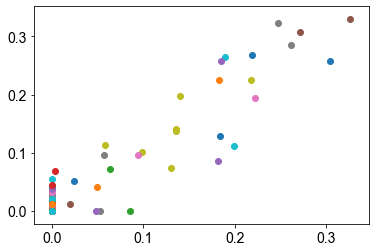

In [1304]:
#nmf x, nmf y
for i in range(100):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

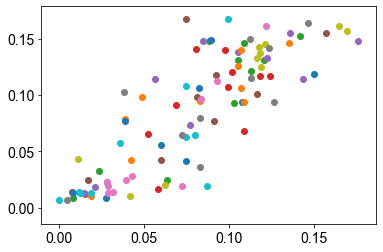

In [1327]:
#nmf x, pca y
for i in range(100):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

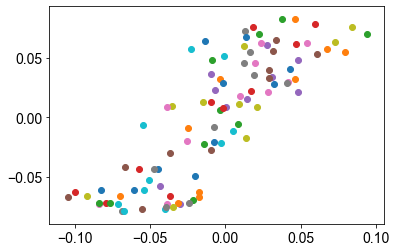

In [1364]:
#nmf x, pca y
for i in range(100):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

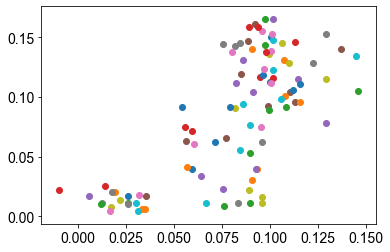

In [1377]:
#pca x, pca y
for i in range(100):
    plt.scatter(recon_x.detach().numpy()[:,0][i], y.detach().numpy()[:,0][i])

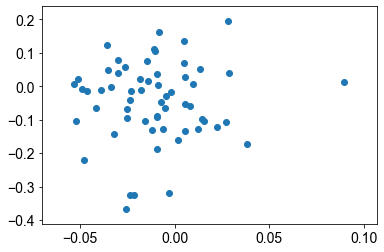

In [1381]:
plt.scatter(recon_x.detach().numpy()[2], y.detach().numpy()[2])

In [1646]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=60)

        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        an = anndata.AnnData(X)
        an.Y= (Y)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=5 
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =10,
                    output_activation='linear', encoder_layer_sizes=[10], decoder_layer_sizes=[], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 1e-2
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
            
        for q in range(10000):
                #print(iteration, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                recon_x, mean, log_var = self.model(x, y)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.857227001218525
0.9772834561835669
0.0010721778041343072 0.007446737378860348
9.352119130094708 376.0
encoder_layer_sizes [240, 10]
decoder_layer_sizes []
latent dim 10
2 ncls
0.2 dr_rate
True ubn
True udr
(376, 577)
(0, 577)
(376, 577)
(0, 577)
281.8516540527344
201.20413208007812
214.90158081054688
168.74012756347656
155.60716247558594
182.04165649414062
88.74210357666016
144.5712890625
122.0079345703125
52.42161178588867
77.91385650634766
59.28693389892578
70.40254211425781
82.097412109375
51.66943359375
56.69328689575195
62.6191291809082
39.39026641845703
33.794212341308594
30.027233123779297
38.7974739074707
38.992000579833984
34.7088623046875
22.100271224975586
30.96945571899414
25.513036727905273
20.227691650390625
16.542316436767578
15.067611694335938
18.563068389892578
14.735330581665039
12.653722763061523
10.855228424072266
10.901044845581055
11.849749565124512
6.740902900695801
9.082621574401855
6.948449611663818
6.789468288421631
7.768511772155762
5.317861557006836
6.2159

0.43164771795272827
0.41245418787002563
0.31621578335762024
0.4445454180240631
0.307037889957428
0.49055638909339905
0.6373623013496399
0.3753923177719116
0.5405086278915405
0.5456962585449219
0.5518852472305298
0.41583341360092163
0.41991010308265686
0.4667840600013733
0.44001731276512146
0.39911431074142456
0.4584551453590393
0.3737773597240448
0.36792057752609253
0.4545203745365143
0.4058617055416107
0.38228732347488403
0.39529603719711304
0.4261447489261627
0.5815657377243042
0.4230545163154602
0.3740726113319397
0.4243597090244293
0.33870023488998413
0.5073286294937134
0.4996078908443451
0.40827760100364685
0.5201875567436218
0.436274915933609
0.45081019401550293
0.45159393548965454
0.4352191984653473
0.5028544068336487
0.4192575514316559
0.39696067571640015
0.3562846779823303
0.4847758412361145
0.46636682748794556
0.389288991689682
0.6167001128196716
0.535891592502594
0.37877291440963745
0.3975164294242859
0.4156203866004944
0.46900588274002075
0.5075465440750122
0.32973152399063

0.3678765892982483
0.5550453066825867
0.33731502294540405
0.3051818013191223
0.41592010855674744
0.42100533843040466
0.4221065640449524
0.38754186034202576
0.27334970235824585
0.4429979920387268
0.5427125692367554
0.2522047758102417
0.36217063665390015
0.5124763250350952
0.3341360092163086
0.3888121247291565
0.39238274097442627
0.40061450004577637
0.41723451018333435
0.3347243666648865
0.3576131761074066
0.4643864631652832
0.42804908752441406
0.33953171968460083
0.278167724609375
0.43359488248825073
0.4816221594810486
0.2871125340461731
0.4588986933231354
0.2755286395549774
0.31027814745903015
0.43190518021583557
0.29192978143692017
0.31718891859054565
0.4093224108219147
0.2977229356765747
0.4446917474269867
0.44313281774520874
0.40373554825782776
0.46184659004211426
0.4377818703651428
0.23776106536388397
0.4417746067047119
0.32782629132270813
0.29187676310539246
0.4674417972564697
0.4677364230155945
0.4775921702384949
0.4404939115047455
0.3271275758743286
0.3273616433143616
0.68550789

0.21336321532726288
0.2668204605579376
0.2812322974205017
0.32287725806236267
0.4343292713165283
0.17752771079540253
0.5059477090835571
0.39016324281692505
0.19950035214424133
0.19543901085853577
0.2905861437320709
0.38325750827789307
0.24995294213294983
0.2135147750377655
0.19649408757686615
0.27355819940567017
0.21843087673187256
0.4738805294036865
0.19685618579387665
0.3453424870967865
0.31638526916503906
0.18941541016101837
0.4490533769130707
0.18995295464992523
0.18459442257881165
0.20450294017791748
0.4014904499053955
0.24938344955444336
0.5483018159866333
0.2539447546005249
0.26053181290626526
0.5342470407485962
0.26255035400390625
0.31581610441207886
0.3409678637981415
0.2655113637447357
0.2038542926311493
0.1749851554632187
0.22203341126441956
0.4088781774044037
0.20006303489208221
0.3275757431983948
0.25510892271995544
0.32242292165756226
0.3382800221443176
0.2597314417362213
0.357575923204422
0.21391110122203827
0.5043314695358276
0.5546723008155823
0.4497157633304596
0.2939

KeyboardInterrupt: 

In [1460]:
ys = y.detach().numpy()
recon_xs  = recon_x.detach().numpy()
np.nanmean([get_loss_paper(ys[i], recon_xs[i]) for i in range(ys.shape[0])])

0.06420132554402255

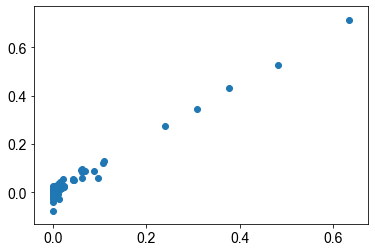

In [1462]:
ys = y.detach().numpy()
recon_xs  = recon_x.detach().numpy()
i  = 1
plt.scatter(ys[i], recon_xs[i])

In [1610]:
def normalize(x):
    keep = np.where(np.linalg.norm(X, axis = 0) != 0)[0]
    
    x = x[:,keep]
    return((x - np.mean(x, axis = 0))/ np.var(x, axis = 0)**(0.5))

from sklearn.preprocessing import StandardScaler

In [1589]:
(np.linalg.norm(x, axis = 0)**2).shape

(240,)

In [1673]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        xnorm = normalize(X)#scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= Y_pca
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=10
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =10,
                    output_activation='linear', encoder_layer_sizes=[10], decoder_layer_sizes=[], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 1e-2
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        for q in range(niter):
                print(iteration, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572308726791598
0.9975135839447252
0.0010721778042753185 0.007446737378860348
9.572947847843546 376.0
encoder_layer_sizes [20, 10]
decoder_layer_sizes []
latent dim 10
2 ncls
0.2 dr_rate
True ubn
True udr
(376, 120)
(0, 120)
(376, 120)
(0, 120)
tensor([[ 7.2630e-01, -1.8157e-01,  1.6226e-01,  ..., -1.4875e-03,
         -5.9343e-03, -1.3069e-02],
        [ 1.2069e-01,  1.6619e-01, -1.4122e-01,  ..., -1.3808e-02,
          1.7744e-03,  1.7136e-02],
        [ 2.9207e-01,  2.0953e-01,  7.2105e-01,  ...,  5.8182e-04,
         -5.4521e-03, -3.8667e-03],
        ...,
        [ 2.9016e-02,  2.2205e-01, -1.4654e-01,  ..., -9.5152e-03,
         -3.9981e-03, -1.2545e-03],
        [ 4.0625e-01,  3.7368e-01,  1.9039e-01,  ...,  1.3345e-02,
          2.2700e-03, -1.5019e-02],
        [ 6.4787e-02,  2.8458e-01,  3.8670e-02,  ..., -2.7427e-03,
          1.0983e-02,  1.0611e-02]], dtype=torch.float64)
0 iteration
53.890228271484375
0 iteration
55.83613967895508
0 iteration
48.37568664550781
0 iterat

0.6713109612464905
0 iteration
0.6415087580680847
0 iteration
0.7039719820022583
0 iteration
0.6434497833251953
0 iteration
0.7147579789161682
0 iteration
0.7704463005065918
0 iteration
0.756483793258667
0 iteration
0.7012549042701721
0 iteration
0.6261699199676514
0 iteration
0.7206796407699585
0 iteration
0.6568032503128052
0 iteration
0.7447652816772461
0 iteration
0.674932599067688
0 iteration
0.7167043089866638
0 iteration
0.6210765838623047
0 iteration
0.6339413523674011
0 iteration
0.7301400899887085
0 iteration
0.7110459208488464
0 iteration
0.6887316703796387
0 iteration
0.5943154096603394
0 iteration
0.7853808999061584
0 iteration
0.6828792691230774
0 iteration
0.692300021648407
0 iteration
0.728063702583313
0 iteration
0.6867590546607971
0 iteration
0.7273434400558472
0 iteration
0.6503699421882629
0 iteration
0.6388412714004517
0 iteration
0.6716066598892212
0 iteration
0.7188882231712341
0 iteration
0.7290107011795044
0 iteration
0.7720575928688049
0 iteration
0.6637775897

0.5923907160758972
0 iteration
0.5751703977584839
0 iteration
0.6426859498023987
0 iteration
0.5835569500923157
0 iteration
0.6260820031166077
0 iteration
0.5516144037246704
0 iteration
0.6121764779090881
0 iteration
0.6438806056976318
0 iteration
0.5998311042785645
0 iteration
0.6302236318588257
0 iteration
0.5896247029304504
0 iteration
0.6360757350921631
0 iteration
0.6824057698249817
0 iteration
0.6596227884292603
0 iteration
0.6597949266433716
0 iteration
0.587279736995697
0 iteration
0.591944694519043
0 iteration
0.6635531187057495
0 iteration
0.6769546270370483
0 iteration
0.6220613718032837
0 iteration
0.5984438061714172
0 iteration
0.6281176805496216
0 iteration
0.5854108929634094
0 iteration
0.5778578519821167
0 iteration
0.5929636359214783
0 iteration
0.6596713662147522
0 iteration
0.7522698640823364
0 iteration
0.5799471735954285
0 iteration
0.6002593636512756
0 iteration
0.561887264251709
0 iteration
0.6946820020675659
0 iteration
0.6015926599502563
0 iteration
0.592300832

0.5049018859863281
0 iteration
0.5635511875152588
0 iteration
0.5925559401512146
0 iteration
0.5249196887016296
0 iteration
0.5035338401794434
0 iteration
0.5340222716331482
0 iteration
0.5804451107978821
0 iteration
0.4529481828212738
0 iteration
0.46599745750427246
0 iteration
0.48721498250961304
0 iteration
0.6309276819229126
0 iteration
0.6543186902999878
0 iteration
0.6583336591720581
0 iteration
0.5315179824829102
0 iteration
0.5400518178939819
0 iteration
0.6077244877815247
0 iteration
0.6511871814727783
0 iteration
0.5955477356910706
0 iteration
0.5370345711708069
0 iteration
0.5335888862609863
0 iteration
0.6703158020973206
0 iteration
0.5446030497550964
0 iteration
0.5213314294815063
0 iteration
0.5147495269775391
0 iteration
0.5572555661201477
0 iteration
0.5302204489707947
0 iteration
0.47717490792274475
0 iteration
0.4924619793891907
0 iteration
0.5874897241592407
0 iteration
0.4684838652610779
0 iteration
0.7076879143714905
0 iteration
0.533776044845581
0 iteration
0.5370

0.5069335699081421
0 iteration
0.6008989810943604
0 iteration
0.48885709047317505
0 iteration
0.5439162254333496
0 iteration
0.49654141068458557
0 iteration
0.48868846893310547
0 iteration
0.503074049949646
0 iteration
0.6489202380180359
0 iteration
0.5248047113418579
0 iteration
0.5919119119644165
0 iteration
0.5181039571762085
0 iteration
0.5487650632858276
0 iteration
0.5691179037094116
0 iteration
0.5987721681594849
0 iteration
0.5139304399490356
0 iteration
0.46553224325180054
0 iteration
0.467820405960083
0 iteration
0.45964035391807556
0 iteration
0.49554675817489624
0 iteration
0.4762941896915436
0 iteration
0.577059805393219
0 iteration
0.5573545694351196
0 iteration
0.48912110924720764
0 iteration
0.4507486820220947
0 iteration
0.6130684018135071
0 iteration
0.4674181342124939
0 iteration
0.5409536957740784
0 iteration
0.47604042291641235
0 iteration
0.4680296778678894
0 iteration
0.4566519260406494
0 iteration
0.6814359426498413
0 iteration
0.47899508476257324
0 iteration
0.

0.4372561573982239
0 iteration
0.48952874541282654
0 iteration
0.5563198328018188
0 iteration
0.4243907928466797
0 iteration
0.558731198310852
0 iteration
0.44611501693725586
0 iteration
0.47288766503334045
0 iteration
0.4406413435935974
0 iteration
0.5363463163375854
0 iteration
0.5210549235343933
0 iteration
0.515501856803894
0 iteration
0.6420824527740479
0 iteration
0.5024899244308472
0 iteration
0.5771278142929077
0 iteration
0.49888449907302856
0 iteration
0.472321093082428
0 iteration
0.5665490031242371
0 iteration
0.5298960208892822
0 iteration
0.5514107942581177
0 iteration
0.5247036218643188
0 iteration
0.4842310845851898
0 iteration
0.49493032693862915
0 iteration
0.5681759119033813
0 iteration
0.4946458339691162
0 iteration
0.5402191281318665
0 iteration
0.5264459252357483
0 iteration
0.6670125126838684
0 iteration
0.43615594506263733
0 iteration
0.4784420132637024
0 iteration
0.43984851241111755
0 iteration
0.4730818271636963
0 iteration
0.44540706276893616
0 iteration
0.3

0.5710180997848511
0 iteration
0.5306468605995178
0 iteration
0.46396008133888245
0 iteration
0.3799892067909241
0 iteration
0.389370858669281
0 iteration
0.38851404190063477
0 iteration
0.4058970808982849
0 iteration
0.5231040716171265
0 iteration
0.3929111063480377
0 iteration
0.4853230118751526
0 iteration
0.3896515965461731
0 iteration
0.4535973072052002
0 iteration
0.3992982506752014
0 iteration
0.43716153502464294
0 iteration
0.43259668350219727
0 iteration
0.42568135261535645
0 iteration
0.5574148893356323
0 iteration
0.3634381890296936
0 iteration
0.40179210901260376
0 iteration
0.35018882155418396
0 iteration
0.4796546399593353
0 iteration
0.5392605066299438
0 iteration
0.41891083121299744
0 iteration
0.5068259835243225
0 iteration
0.561055064201355
0 iteration
0.5585327744483948
0 iteration
0.5228399634361267
0 iteration
0.38468843698501587
0 iteration
0.35411226749420166
0 iteration
0.41138020157814026
0 iteration
0.4577257037162781
0 iteration
0.3335554301738739
0 iteration

0.45517927408218384
0 iteration
0.3438420593738556
0 iteration
0.34050866961479187
0 iteration
0.43183284997940063
0 iteration
0.5504084825515747
0 iteration
0.32692188024520874
0 iteration
0.47126561403274536
0 iteration
0.3262462913990021
0 iteration
0.5216074585914612
0 iteration
0.3595969080924988
0 iteration
0.37343454360961914
0 iteration
0.46730145812034607
0 iteration
0.430617094039917
0 iteration
0.4434545934200287
0 iteration
0.42704686522483826
0 iteration
0.45847368240356445
0 iteration
0.4989837110042572
0 iteration
0.46146059036254883
0 iteration
0.4149620532989502
0 iteration
0.4781954288482666
0 iteration
0.40146151185035706
0 iteration
0.3376278281211853
0 iteration
0.4974277913570404
0 iteration
0.3383944630622864
0 iteration
0.5709104537963867
0 iteration
0.3867760896682739
0 iteration
0.3549697995185852
0 iteration
0.4564533233642578
0 iteration
0.4434511661529541
0 iteration
0.5194528698921204
0 iteration
0.3664686381816864
0 iteration
0.4676872193813324
0 iteratio

0.3775647282600403
0 iteration
0.4115615785121918
0 iteration
0.4808719754219055
0 iteration
0.5052984356880188
0 iteration
0.5401731729507446
0 iteration
0.424957811832428
0 iteration
0.4634076654911041
0 iteration
0.494746595621109
0 iteration
0.4760380685329437
0 iteration
0.4403897821903229
0 iteration
0.3517554700374603
0 iteration
0.5305026769638062
0 iteration
0.4035307765007019
0 iteration
0.5585821270942688
0 iteration
0.552334725856781
0 iteration
0.40166157484054565
0 iteration
0.42687350511550903
0 iteration
0.37162256240844727
0 iteration
0.40126219391822815
0 iteration
0.48728328943252563
0 iteration
0.4441164433956146
0 iteration
0.4154926836490631
0 iteration
0.4330158829689026
0 iteration
0.49412107467651367
0 iteration
0.4863041937351227
0 iteration
0.528901219367981
0 iteration
0.48224639892578125
0 iteration
0.4538620412349701
0 iteration
0.4205320477485657
0 iteration
0.4367407262325287
0 iteration
0.34070640802383423
0 iteration
0.44791388511657715
0 iteration
0.7

0 iteration
0.42303043603897095
0 iteration
0.36399218440055847
0 iteration
0.45959538221359253
0 iteration
0.37650051712989807
0 iteration
0.3677038848400116
0 iteration
0.39908167719841003
0 iteration
0.5105335712432861
0 iteration
0.399384081363678
0 iteration
0.36800768971443176
0 iteration
0.4122317433357239
0 iteration
0.435986191034317
0 iteration
0.4760564863681793
0 iteration
0.354131817817688
0 iteration
0.4275152087211609
0 iteration
0.38881972432136536
0 iteration
0.5607011318206787
0 iteration
0.3559074103832245
0 iteration
0.3857518136501312
0 iteration
0.4787020683288574
0 iteration
0.3705696165561676
0 iteration
0.4306873679161072
0 iteration
0.4142840802669525
0 iteration
0.4931233823299408
0 iteration
0.3551160991191864
0 iteration
0.45353132486343384
0 iteration
0.4197387099266052
0 iteration
0.41577333211898804
0 iteration
0.41531649231910706
0 iteration
0.5284124612808228
0 iteration
0.39453649520874023
0 iteration
0.3404005169868469
0 iteration
0.3812063932418823


0.49288082122802734
0 iteration
0.3605911135673523
0 iteration
0.347860187292099
0 iteration
0.47571808099746704
0 iteration
0.3997291624546051
0 iteration
0.4841534495353699
0 iteration
0.3859044909477234
0 iteration
0.4578688144683838
0 iteration
0.48633718490600586
0 iteration
0.4982132017612457
0 iteration
0.5275372266769409
0 iteration
0.4904060363769531
0 iteration
0.4150547981262207
0 iteration
0.3404986262321472
0 iteration
0.543528139591217
0 iteration
0.4669126570224762
0 iteration
0.481527715921402
0 iteration
0.36381521821022034
0 iteration
0.5344370007514954
0 iteration
0.42387598752975464
0 iteration
0.4245368540287018
0 iteration
0.4930897355079651
0 iteration
0.36974793672561646
0 iteration
0.4401697516441345
0 iteration
0.3858575224876404
0 iteration
0.3906462788581848
0 iteration
0.37209099531173706
0 iteration
0.4107092022895813
0 iteration
0.37107452750205994
0 iteration
0.47764530777931213
0 iteration
0.42201822996139526
0 iteration
0.5099491477012634
0 iteration
0

0.5003945827484131
0 iteration
0.34992074966430664
0 iteration
0.5205596089363098
0 iteration
0.5589150786399841
0 iteration
0.4239639639854431
0 iteration
0.3485361635684967
0 iteration
0.44371867179870605
0 iteration
0.434115469455719
0 iteration
0.49651116132736206
0 iteration
0.3742663264274597
0 iteration
0.5625172257423401
0 iteration
0.42965641617774963
0 iteration
0.4999774098396301
0 iteration
0.4325769543647766
0 iteration
0.4009285867214203
0 iteration
0.4109528660774231
0 iteration
0.3769993782043457
0 iteration
0.39231473207473755
0 iteration
0.4379105567932129
0 iteration
0.3180093467235565
0 iteration
0.45480877161026
0 iteration
0.36445438861846924
0 iteration
0.43543529510498047
0 iteration
0.3887532353401184
0 iteration
0.4840715527534485
0 iteration
0.35386088490486145
0 iteration
0.42839890718460083
0 iteration
0.5230455994606018
0 iteration
0.37497028708457947
0 iteration
0.4917212426662445
0 iteration
0.3576579689979553
0 iteration
0.2915688455104828
0 iteration
0

0.49286699295043945
0 iteration
0.41997209191322327
0 iteration
0.4466075301170349
0 iteration
0.5537224411964417
0 iteration
0.3750750720500946
0 iteration
0.3855551779270172
0 iteration
0.5025228261947632
0 iteration
0.4259777069091797
0 iteration
0.5114351511001587
0 iteration
0.44505614042282104
0 iteration
0.42721953988075256
0 iteration
0.4455562233924866
0 iteration
0.37207794189453125
0 iteration
0.5819876790046692
0 iteration
0.3439778983592987
0 iteration
0.48350638151168823
0 iteration
0.4852537512779236
0 iteration
0.4132707118988037
0 iteration
0.3602279722690582
0 iteration
0.4917365610599518
0 iteration
0.34325408935546875
0 iteration
0.4599439203739166
0 iteration
0.5353195667266846
0 iteration
0.3470226228237152
0 iteration
0.5717438459396362
0 iteration
0.3914201855659485
0 iteration
0.39909952878952026
0 iteration
0.4136281907558441
0 iteration
0.3925214409828186
0 iteration
0.40312474966049194
0 iteration
0.4217139780521393
0 iteration
0.462481826543808
0 iteration


0.4493151307106018
0 iteration
0.4123261868953705
0 iteration
0.47129639983177185
0 iteration
0.42315101623535156
0 iteration
0.3733803331851959
0 iteration
0.34113603830337524
0 iteration
0.4115498960018158
0 iteration
0.49897852540016174
0 iteration
0.4067784249782562
0 iteration
0.35294675827026367
0 iteration
0.4673127233982086
0 iteration
0.35456201434135437
0 iteration
0.4265558123588562
0 iteration
0.4566892087459564
0 iteration
0.34276220202445984
0 iteration
0.4418420195579529
0 iteration
0.40780797600746155
0 iteration
0.4457721710205078
0 iteration
0.43828481435775757
0 iteration
0.4130631983280182
0 iteration
0.46839410066604614
0 iteration
0.5040666460990906
0 iteration
0.42888402938842773
0 iteration
0.5304645299911499
0 iteration
0.36367130279541016
0 iteration
0.3541871905326843
0 iteration
0.3892269432544708
0 iteration
0.38172414898872375
0 iteration
0.5571518540382385
0 iteration
0.478701651096344
0 iteration
0.5517660975456238
0 iteration
0.5664531588554382
0 iterat

0.5301968455314636
0 iteration
0.3661957383155823
0 iteration
0.3536214232444763
0 iteration
0.4548022150993347
0 iteration
0.3441484570503235
0 iteration
0.3414459526538849
0 iteration
0.4775797724723816
0 iteration
0.37370699644088745
0 iteration
0.3278554081916809
0 iteration
0.45642003417015076
0 iteration
0.5329081416130066
0 iteration
0.37091371417045593
0 iteration
0.4121996760368347
0 iteration
0.4735957086086273
0 iteration
0.3763338327407837
0 iteration
0.382412314414978
0 iteration
0.5044921636581421
0 iteration
0.32914578914642334
0 iteration
0.38259589672088623
0 iteration
0.41020268201828003
0 iteration
0.43378692865371704
0 iteration
0.4666162133216858
0 iteration
0.5812769532203674
0 iteration
0.4864279627799988
0 iteration
0.39072123169898987
0 iteration
0.37061718106269836
0 iteration
0.4407421946525574
0 iteration
0.3423343300819397
0 iteration
0.42403021454811096
0 iteration
0.46927952766418457
0 iteration
0.32366079092025757
0 iteration
0.3540019392967224
0 iterati

0.43856120109558105
0 iteration
0.4028731882572174
0 iteration
0.5066149234771729
0 iteration
0.4760980010032654
0 iteration
0.41983088850975037
0 iteration
0.49944034218788147
0 iteration
0.45623978972435
0 iteration
0.3598700165748596
0 iteration
0.3531312048435211
0 iteration
0.4341263175010681
0 iteration
0.6167548298835754
0 iteration
0.44778791069984436
0 iteration
0.347922682762146
0 iteration
0.5469927787780762
0 iteration
0.5853043794631958
0 iteration
0.3329993784427643
0 iteration
0.35739362239837646
0 iteration
0.5973597168922424
0 iteration
0.35245102643966675
0 iteration
0.400404155254364
0 iteration
0.48677998781204224
0 iteration
0.5292729139328003
0 iteration
0.3870004117488861
0 iteration
0.40705522894859314
0 iteration
0.32153597474098206
0 iteration
0.4783555567264557
0 iteration
0.4652937352657318
0 iteration
0.38169974088668823
0 iteration
0.45484670996665955
0 iteration
0.5448635816574097
0 iteration
0.36007818579673767
0 iteration
0.33998680114746094
0 iteration

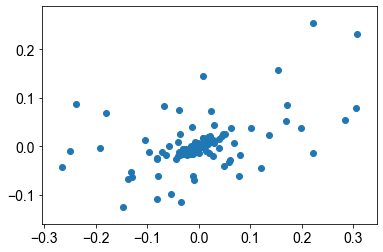

In [1713]:
ys = y.detach().numpy()
recon_xs  = recon_x.detach().numpy()
i  = 7
plt.scatter(ys[i], recon_xs[i])

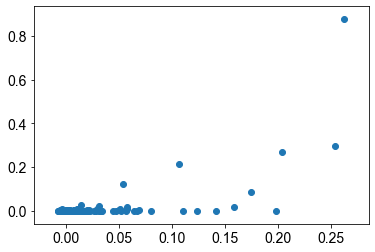

In [1707]:
matchind  = np.argsort(np.linalg.norm(Y_pca  - y.detach().numpy()[i] , axis = 1))[0]
ys = y.detach().numpy()
recon_xs  = recon_x.detach().numpy()
reconY =  pcaY.inverse_transform(recon_xs)
plt.scatter(reconY[i], Y[matchind])

In [1708]:
get_loss_paper(reconY[i], Y[matchind])

0.8117190042767474

In [1709]:
creline[315][exp_toinclude][matchind]

'Ntsr1-Cre_GN220'

In [1745]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        xnorm = normalize(X)#scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= Y_pca
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=10
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =10,
                    output_activation='linear', encoder_layer_sizes=[30], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 1e-2
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        for q in range(niter):
                print(iteration, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572411070290118
0.9975144911109096
0.00107217780425319 0.007446737378860348
9.489793897170719 376.0
encoder_layer_sizes [20, 30]
decoder_layer_sizes [45]
latent dim 10
2 ncls
0.2 dr_rate
True ubn
True udr
(376, 120)
(0, 120)
(376, 120)
(0, 120)
tensor([[ 3.2895e-01,  1.4671e-01,  5.2805e-01,  ..., -2.7674e-03,
         -7.9769e-03, -3.8468e-03],
        [ 1.0934e-01,  2.0866e-01, -1.6679e-01,  ..., -1.9069e-02,
          1.0341e-02,  3.7163e-03],
        [ 2.1413e-01,  2.6571e-01, -2.2486e-01,  ..., -2.8089e-03,
         -5.5262e-03,  5.2447e-03],
        ...,
        [ 5.0388e-01,  2.8289e-01,  3.6675e-01,  ...,  7.1098e-04,
         -1.1629e-02,  3.8341e-03],
        [ 7.2766e-02,  3.2754e-01, -1.8849e-01,  ..., -7.3072e-03,
         -1.0796e-03,  2.5244e-03],
        [ 6.3950e-01, -3.1506e-01, -1.2420e-01,  ...,  5.1470e-03,
         -8.4161e-03, -3.0864e-04]], dtype=torch.float64)
0 iteration
23.276166915893555
0 iteration
18.763492584228516
0 iteration
14.140798568725586
0 iter

0.5321301817893982
0 iteration
0.5566139221191406
0 iteration
0.544044017791748
0 iteration
0.581031858921051
0 iteration
0.5360333919525146
0 iteration
0.591780424118042
0 iteration
0.5367901921272278
0 iteration
0.543958306312561
0 iteration
0.5497687458992004
0 iteration
0.5800641775131226
0 iteration
0.5296474099159241
0 iteration
0.5447878241539001
0 iteration
0.5391912460327148
0 iteration
0.5385494232177734
0 iteration
0.5564823746681213
0 iteration
0.565374493598938
0 iteration
0.5503708720207214
0 iteration
0.5775764584541321
0 iteration
0.5690474510192871
0 iteration
0.5623836517333984
0 iteration
0.5368735194206238
0 iteration
0.524327278137207
0 iteration
0.5396972298622131
0 iteration
0.5423566102981567
0 iteration
0.519586980342865
0 iteration
0.5676574110984802
0 iteration
0.5383796095848083
0 iteration
0.5252432227134705
0 iteration
0.5416829586029053
0 iteration
0.5796818137168884
0 iteration
0.5700668096542358
0 iteration
0.5535057783126831
0 iteration
0.5556505918502

0.43099743127822876
0 iteration
0.427661657333374
0 iteration
0.4215576648712158
0 iteration
0.43972843885421753
0 iteration
0.44103509187698364
0 iteration
0.4504694938659668
0 iteration
0.4812208116054535
0 iteration
0.44342175126075745
0 iteration
0.41521644592285156
0 iteration
0.4310433268547058
0 iteration
0.40589436888694763
0 iteration
0.4493149220943451
0 iteration
0.41131433844566345
0 iteration
0.4346516728401184
0 iteration
0.48313188552856445
0 iteration
0.43193474411964417
0 iteration
0.4247998297214508
0 iteration
0.4741395115852356
0 iteration
0.4031282365322113
0 iteration
0.4613974094390869
0 iteration
0.41401082277297974
0 iteration
0.4545101523399353
0 iteration
0.4084770083427429
0 iteration
0.42666369676589966
0 iteration
0.4004153609275818
0 iteration
0.4456143379211426
0 iteration
0.42906349897384644
0 iteration
0.418069064617157
0 iteration
0.4566565155982971
0 iteration
0.4089050889015198
0 iteration
0.43185633420944214
0 iteration
0.4285365641117096
0 iterati

0.413128137588501
0 iteration
0.4243794083595276
0 iteration
0.4622407555580139
0 iteration
0.3846137523651123
0 iteration
0.41751188039779663
0 iteration
0.4042723774909973
0 iteration
0.4153288006782532
0 iteration
0.38748618960380554
0 iteration
0.370820552110672
0 iteration
0.4369630813598633
0 iteration
0.3945436179637909
0 iteration
0.4041810929775238
0 iteration
0.4073253571987152
0 iteration
0.3733336329460144
0 iteration
0.442117840051651
0 iteration
0.4438799023628235
0 iteration
0.3700307011604309
0 iteration
0.40569037199020386
0 iteration
0.37993162870407104
0 iteration
0.3903872072696686
0 iteration
0.41266417503356934
0 iteration
0.37194588780403137
0 iteration
0.3729609549045563
0 iteration
0.3677431344985962
0 iteration
0.4407285153865814
0 iteration
0.40737074613571167
0 iteration
0.44400376081466675
0 iteration
0.3926807940006256
0 iteration
0.39492228627204895
0 iteration
0.45802125334739685
0 iteration
0.40333253145217896
0 iteration
0.42238688468933105
0 iteration

0.39819225668907166
0 iteration
0.40076136589050293
0 iteration
0.3598483204841614
0 iteration
0.3389391601085663
0 iteration
0.3708033263683319
0 iteration
0.3399573266506195
0 iteration
0.3442503809928894
0 iteration
0.3671627938747406
0 iteration
0.3741312026977539
0 iteration
0.40489354729652405
0 iteration
0.38223856687545776
0 iteration
0.4015612006187439
0 iteration
0.38191190361976624
0 iteration
0.35943207144737244
0 iteration
0.41017788648605347
0 iteration
0.3527452051639557
0 iteration
0.38142624497413635
0 iteration
0.35125792026519775
0 iteration
0.4013381898403168
0 iteration
0.35405462980270386
0 iteration
0.35812100768089294
0 iteration
0.3822350800037384
0 iteration
0.3563941717147827
0 iteration
0.3373485505580902
0 iteration
0.4063441753387451
0 iteration
0.3357810974121094
0 iteration
0.35642844438552856
0 iteration
0.39729779958724976
0 iteration
0.34750741720199585
0 iteration
0.34875744581222534
0 iteration
0.3931157886981964
0 iteration
0.3954336643218994
0 ite

0.3603115677833557
0 iteration
0.31054267287254333
0 iteration
0.34929871559143066
0 iteration
0.2938433289527893
0 iteration
0.3152616620063782
0 iteration
0.3943946659564972
0 iteration
0.32831519842147827
0 iteration
0.3762243688106537
0 iteration
0.33248370885849
0 iteration
0.3249221742153168
0 iteration
0.3302294909954071
0 iteration
0.30985555052757263
0 iteration
0.37349289655685425
0 iteration
0.3377552032470703
0 iteration
0.3470250964164734
0 iteration
0.33407455682754517
0 iteration
0.4351016581058502
0 iteration
0.29794567823410034
0 iteration
0.3387806713581085
0 iteration
0.35860997438430786
0 iteration
0.3349406123161316
0 iteration
0.3411264419555664
0 iteration
0.406008780002594
0 iteration
0.3187975585460663
0 iteration
0.33872324228286743
0 iteration
0.3322105407714844
0 iteration
0.36261120438575745
0 iteration
0.2864733636379242
0 iteration
0.32411226630210876
0 iteration
0.345018595457077
0 iteration
0.35379382967948914
0 iteration
0.3521845042705536
0 iteration


0.36208096146583557
0 iteration
0.2619593143463135
0 iteration
0.2955157458782196
0 iteration
0.2826431691646576
0 iteration
0.3306189179420471
0 iteration
0.33440354466438293
0 iteration
0.3063666820526123
0 iteration
0.337962806224823
0 iteration
0.3150191009044647
0 iteration
0.27150946855545044
0 iteration
0.297652006149292
0 iteration
0.37410420179367065
0 iteration
0.2896782457828522
0 iteration
0.3304387331008911
0 iteration
0.35187679529190063
0 iteration
0.3763353228569031
0 iteration
0.38554951548576355
0 iteration
0.2956133186817169
0 iteration
0.29401081800460815
0 iteration
0.34277135133743286
0 iteration
0.38891953229904175
0 iteration
0.3962950110435486
0 iteration
0.4296753406524658
0 iteration
0.3589690625667572
0 iteration
0.285734087228775
0 iteration
0.3848663866519928
0 iteration
0.3975065350532532
0 iteration
0.32941052317619324
0 iteration
0.416769802570343
0 iteration
0.3470812141895294
0 iteration
0.33313697576522827
0 iteration
0.36979252099990845
0 iteration


0.34418028593063354
0 iteration
0.2471996247768402
0 iteration
0.314542293548584
0 iteration
0.3677999973297119
0 iteration
0.4688262939453125
0 iteration
0.2996571660041809
0 iteration
0.3197910189628601
0 iteration
0.28777068853378296
0 iteration
0.3638455271720886
0 iteration
0.3085102438926697
0 iteration
0.3339737057685852
0 iteration
0.3685421347618103
0 iteration
0.30781278014183044
0 iteration
0.3454490303993225
0 iteration
0.321204274892807
0 iteration
0.3344263434410095
0 iteration
0.28375762701034546
0 iteration
0.3499888777732849
0 iteration
0.3785094916820526
0 iteration
0.3387398421764374
0 iteration
0.3017233908176422
0 iteration
0.3283100724220276
0 iteration
0.3201269805431366
0 iteration
0.3423084616661072
0 iteration
0.3083374798297882
0 iteration
0.2910921275615692
0 iteration
0.29368364810943604
0 iteration
0.3133806884288788
0 iteration
0.36812520027160645
0 iteration
0.36902254819869995
0 iteration
0.2754635214805603
0 iteration
0.2960566282272339
0 iteration
0.3

0.3612825274467468
0 iteration
0.2909950613975525
0 iteration
0.31441599130630493
0 iteration
0.3384552001953125
0 iteration
0.36547496914863586
0 iteration
0.34196433424949646
0 iteration
0.31574830412864685
0 iteration
0.3143990635871887
0 iteration
0.3634834885597229
0 iteration
0.29506152868270874
0 iteration
0.29816481471061707
0 iteration
0.36753901839256287
0 iteration
0.30180612206459045
0 iteration
0.3193374276161194
0 iteration
0.2872229218482971
0 iteration
0.2944510579109192
0 iteration
0.2533457577228546
0 iteration
0.3037009835243225
0 iteration
0.28113579750061035
0 iteration
0.2867787778377533
0 iteration
0.3141966164112091
0 iteration
0.29127365350723267
0 iteration
0.2919553518295288
0 iteration
0.30970150232315063
0 iteration
0.3636961281299591
0 iteration
0.3357025980949402
0 iteration
0.3251574635505676
0 iteration
0.33661097288131714
0 iteration
0.30230194330215454
0 iteration
0.3070814609527588
0 iteration
0.28916212916374207
0 iteration
0.3399586081504822
0 iter

0.3260142207145691
0 iteration
0.31661099195480347
0 iteration
0.34207794070243835
0 iteration
0.3203752338886261
0 iteration
0.2851995527744293
0 iteration
0.2548832893371582
0 iteration
0.3129860758781433
0 iteration
0.34791457653045654
0 iteration
0.29326653480529785
0 iteration
0.31214332580566406
0 iteration
0.33496445417404175
0 iteration
0.3298778831958771
0 iteration
0.3305056691169739
0 iteration
0.39871805906295776
0 iteration
0.31403157114982605
0 iteration
0.27128779888153076
0 iteration
0.3153798580169678
0 iteration
0.30339187383651733
0 iteration
0.29758158326148987
0 iteration
0.2992390990257263
0 iteration
0.28345853090286255
0 iteration
0.317717969417572
0 iteration
0.29481416940689087
0 iteration
0.4015800952911377
0 iteration
0.32293784618377686
0 iteration
0.3770747482776642
0 iteration
0.31330475211143494
0 iteration
0.2803955674171448
0 iteration
0.2728874385356903
0 iteration
0.35208311676979065
0 iteration
0.30817461013793945
0 iteration
0.32938721776008606
0 i

0.26851922273635864
0 iteration
0.34131166338920593
0 iteration
0.329250305891037
0 iteration
0.3442040979862213
0 iteration
0.3280515968799591
0 iteration
0.3308377265930176
0 iteration
0.2767784893512726
0 iteration
0.3528798222541809
0 iteration
0.29574379324913025
0 iteration
0.34237706661224365
0 iteration
0.3843831419944763
0 iteration
0.31931328773498535
0 iteration
0.36468690633773804
0 iteration
0.3062957227230072
0 iteration
0.33536192774772644
0 iteration
0.3189082145690918
0 iteration
0.27613288164138794
0 iteration
0.29662656784057617
0 iteration
0.3198769986629486
0 iteration
0.30636343359947205
0 iteration
0.33292388916015625
0 iteration
0.24686205387115479
0 iteration
0.3415132462978363
0 iteration
0.2987532615661621
0 iteration
0.2840365767478943
0 iteration
0.28113141655921936
0 iteration
0.28936126828193665
0 iteration
0.2957744300365448
0 iteration
0.3380555212497711
0 iteration
0.3072931170463562
0 iteration
0.32809051871299744
0 iteration
0.2870773673057556
0 iter

0.3152652084827423
0 iteration
0.31829267740249634
0 iteration
0.3061445355415344
0 iteration
0.3090113699436188
0 iteration
0.26890963315963745
0 iteration
0.3228279650211334
0 iteration
0.2988998293876648
0 iteration
0.32318198680877686
0 iteration
0.32169583439826965
0 iteration
0.31440988183021545
0 iteration
0.2876361012458801
0 iteration
0.27518367767333984
0 iteration
0.29942572116851807
0 iteration
0.33418217301368713
0 iteration
0.3703640103340149
0 iteration
0.31944411993026733
0 iteration
0.2876717150211334
0 iteration
0.3474407494068146
0 iteration
0.2967754304409027
0 iteration
0.26491132378578186
0 iteration
0.3344242572784424
0 iteration
0.3181714713573456
0 iteration
0.2761858105659485
0 iteration
0.2794557511806488
0 iteration
0.3192521333694458
0 iteration
0.25405895709991455
0 iteration
0.29741907119750977
0 iteration
0.2731497585773468
0 iteration
0.3011501431465149
0 iteration
0.31719037890434265
0 iteration
0.3118954002857208
0 iteration
0.27325406670570374
0 iter

0.2906745374202728
0 iteration
0.33446991443634033
0 iteration
0.28438228368759155
0 iteration
0.2871330678462982
0 iteration
0.4601730704307556
0 iteration
0.3192218840122223
0 iteration
0.288464218378067
0 iteration
0.30646559596061707
0 iteration
0.2893640100955963
0 iteration
0.30770015716552734
0 iteration
0.277306467294693
0 iteration
0.2724932134151459
0 iteration
0.2887352705001831
0 iteration
0.27986976504325867
0 iteration
0.30707472562789917
0 iteration
0.29259753227233887
0 iteration
0.28099876642227173
0 iteration
0.3587552011013031
0 iteration
0.33094650506973267
0 iteration
0.29490941762924194
0 iteration
0.2977307438850403
0 iteration
0.2923012375831604
0 iteration
0.3248198926448822
0 iteration
0.3413850665092468
0 iteration
0.2850211560726166
0 iteration
0.2871219515800476
0 iteration
0.33906829357147217
0 iteration
0.2669470012187958
0 iteration
0.28111645579338074
0 iteration
0.32263845205307007
0 iteration
0.3253127336502075
0 iteration
0.3138861656188965
0 iterati

0.2728325426578522
0 iteration
0.3312225937843323
0 iteration
0.259300172328949
0 iteration
0.33930885791778564
0 iteration
0.35349780321121216
0 iteration
0.3107738792896271
0 iteration
0.3176687955856323
0 iteration
0.3023437559604645
0 iteration
0.31272071599960327
0 iteration
0.3291322588920593
0 iteration
0.32508403062820435
0 iteration
0.30995380878448486
0 iteration
0.24990740418434143
0 iteration
0.26192158460617065
0 iteration
0.29354327917099
0 iteration
0.2810342311859131
0 iteration
0.3502710461616516
0 iteration
0.33525335788726807
0 iteration
0.3012402653694153
0 iteration
0.2952171564102173
0 iteration
0.32723695039749146
0 iteration
0.3564363121986389
0 iteration
0.27776283025741577
0 iteration
0.30058208107948303
0 iteration
0.29698410630226135
0 iteration
0.2871355414390564
0 iteration
0.2853139042854309
0 iteration
0.3724077045917511
0 iteration
0.2379961460828781
0 iteration
0.3002265393733978
0 iteration
0.2746949791908264
0 iteration
0.28101950883865356
0 iteratio

0.2772754728794098
0 iteration
0.3460513949394226
0 iteration
0.3265617787837982
0 iteration
0.27858081459999084
0 iteration
0.25945034623146057
0 iteration
0.27806591987609863
0 iteration
0.2801540791988373
0 iteration
0.263500839471817
0 iteration
0.29042306542396545
0 iteration
0.2811344563961029
0 iteration
0.2816298305988312
0 iteration
0.2590809762477875
0 iteration
0.28965821862220764
0 iteration
0.3186625838279724
0 iteration
0.29222747683525085
0 iteration
0.37173885107040405
0 iteration
0.3125748038291931
0 iteration
0.2934114336967468
0 iteration
0.30870601534843445
0 iteration
0.26111021637916565
0 iteration
0.3085799813270569
0 iteration
0.3030998110771179
0 iteration
0.2694936692714691
0 iteration
0.2916451096534729
0 iteration
0.2840641438961029
0 iteration
0.290539413690567
0 iteration
0.3011070489883423
0 iteration
0.3020208477973938
0 iteration
0.2870462238788605
0 iteration
0.31026560068130493
0 iteration
0.2958680987358093
0 iteration
0.3520301878452301
0 iteration


0.3318120539188385
0 iteration
0.35548239946365356
0 iteration
0.2763855457305908
0 iteration
0.331145703792572
0 iteration
0.2989816665649414
0 iteration
0.3078851103782654
0 iteration
0.27836158871650696
0 iteration
0.24990522861480713
0 iteration
0.3003697991371155
0 iteration
0.26881441473960876
0 iteration
0.31174856424331665
0 iteration
0.2979982793331146
0 iteration
0.2753174304962158
0 iteration
0.2629994750022888
0 iteration
0.3270566463470459
0 iteration
0.3500889241695404
0 iteration
0.35936349630355835
0 iteration
0.3074873089790344
0 iteration
0.2943863570690155
0 iteration
0.3449031412601471
0 iteration
0.3195943534374237
0 iteration
0.2808743119239807
0 iteration
0.2815034091472626
0 iteration
0.2546895146369934
0 iteration
0.26792728900909424
0 iteration
0.23315680027008057
0 iteration
0.27134937047958374
0 iteration
0.24368230998516083
0 iteration
0.2962907552719116
0 iteration
0.2935495376586914
0 iteration
0.3265170753002167
0 iteration
0.2846928536891937
0 iteration

0.2794976830482483
0 iteration
0.29187315702438354
0 iteration
0.3161819279193878
0 iteration
0.3388140797615051
0 iteration
0.2919533848762512
0 iteration
0.2863057553768158
0 iteration
0.2789080739021301
0 iteration
0.35224223136901855
0 iteration
0.35331231355667114
0 iteration
0.2840169370174408
0 iteration
0.2852464020252228
0 iteration
0.2562171220779419
0 iteration
0.3085818290710449
0 iteration
0.3071528971195221
0 iteration
0.2544265389442444
0 iteration
0.31312689185142517
0 iteration
0.27446579933166504
0 iteration
0.277488648891449
0 iteration
0.3129052221775055
0 iteration
0.28124624490737915
0 iteration
0.30731117725372314
0 iteration
0.30234190821647644
0 iteration
0.26195573806762695
0 iteration
0.30275943875312805
0 iteration
0.27382320165634155
0 iteration
0.2905796468257904
0 iteration
0.2909735143184662
0 iteration
0.27684450149536133
0 iteration
0.2736835777759552
0 iteration
0.29824838042259216
0 iteration
0.25576454401016235
0 iteration
0.24946196377277374
0 iter

0.2757588028907776
0 iteration
0.28618714213371277
0 iteration
0.2947523295879364
0 iteration
0.28055861592292786
0 iteration
0.26898452639579773
0 iteration
0.33271732926368713
0 iteration
0.33412647247314453
0 iteration
0.281513512134552
0 iteration
0.3120938539505005
0 iteration
0.27542561292648315
0 iteration
0.3223394751548767
0 iteration
0.31422027945518494
0 iteration
0.2539133131504059
0 iteration
0.33647772669792175
0 iteration
0.3971210718154907
0 iteration
0.2668357491493225
0 iteration
0.2881069481372833
0 iteration
0.3248841464519501
0 iteration
0.2827093005180359
0 iteration
0.30282530188560486
0 iteration
0.3169231116771698
0 iteration
0.31373873353004456
0 iteration
0.34094637632369995
0 iteration
0.3003219962120056
0 iteration
0.28685417771339417
0 iteration
0.3465295433998108
0 iteration
0.29843923449516296
0 iteration
0.33817610144615173
0 iteration
0.27615052461624146
0 iteration
0.2977333664894104
0 iteration
0.27568569779396057
0 iteration
0.32815951108932495
0 it

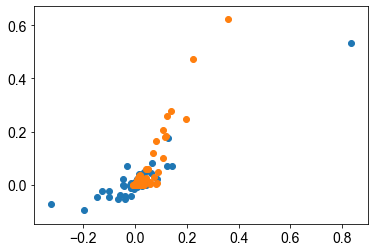

In [1751]:
ys = y.detach().numpy()
recon_xs  = recon_x.detach().numpy()
i  = 1
plt.scatter(ys[i], recon_xs[i])

matchind  = np.argsort(np.linalg.norm(Y_pca  - y.detach().numpy()[i] , axis = 1))[0]
ys = y.detach().numpy()
recon_xs  = recon_x.detach().numpy()
reconY =  pcaY.inverse_transform(recon_xs)
plt.scatter(reconY[i], Y[matchind])

losses= np.zeros(batch_size)
for i in range(batch_size):
    matchind  = np.argsort(np.linalg.norm(Y_pca  - y.detach().numpy()[i] , axis = 1))[0]
    losses[i] = get_loss_paper(reconY[i], Y[matchind])
    
print(np.nanmean(losses))

0.38430495411756554

In [1770]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        xnorm = normalize(X)#scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= Y_pca
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=20
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572341404942835
0.997513412322834
0.0010721778036538877 0.007446737378860348
9.562737042476522 376.0
encoder_layer_sizes [20, 100]
decoder_layer_sizes [45]
latent dim 20
2 ncls
0.2 dr_rate
True ubn
True udr
(376, 120)
(0, 120)
(376, 120)
(0, 120)
tensor([[ 0.0853,  0.4251, -0.2761,  ..., -0.0011,  0.0124,  0.0010],
        [ 0.0343,  0.1954, -0.1294,  ..., -0.0177, -0.0023, -0.0098],
        [ 0.1725,  0.2084, -0.1744,  ..., -0.0114, -0.0018, -0.0092],
        ...,
        [ 0.4089,  0.0401, -0.2699,  ..., -0.0197,  0.0063,  0.0124],
        [ 0.5319,  0.2021, -0.3821,  ...,  0.0020, -0.0033,  0.0010],
        [ 0.4515,  0.0090, -0.2441,  ..., -0.0078,  0.0103,  0.0051]],
       dtype=torch.float64)
1 iteration
27.275625228881836
2 iteration
23.773181915283203
3 iteration
20.80792808532715
4 iteration
17.06075668334961
5 iteration
14.59449577331543
6 iteration
13.792218208312988
7 iteration
12.164373397827148
8 iteration
12.713183403015137
9 iteration
9.272115707397461
10 iteration


0.5679832696914673
264 iteration
0.4965190887451172
265 iteration
0.48087573051452637
266 iteration
0.5027408003807068
267 iteration
0.5031793713569641
268 iteration
0.5233458876609802
269 iteration
0.5088765025138855
270 iteration
0.48941048979759216
271 iteration
0.5053644180297852
272 iteration
0.5164164304733276
273 iteration
0.4810810983181
274 iteration
0.5028084516525269
275 iteration
0.49934259057044983
276 iteration
0.500745952129364
277 iteration
0.49192652106285095
278 iteration
0.495776504278183
279 iteration
0.4995090365409851
280 iteration
0.4807203710079193
281 iteration
0.5010454654693604
282 iteration
0.4878655970096588
283 iteration
0.47326841950416565
284 iteration
0.49134334921836853
285 iteration
0.4676729738712311
286 iteration
0.4802228808403015
287 iteration
0.47037023305892944
288 iteration
0.48581987619400024
289 iteration
0.49952441453933716
290 iteration
0.5102474093437195
291 iteration
0.5173632502555847
292 iteration
0.4692767560482025
293 iteration
0.4686

0.3772686719894409
536 iteration
0.3925042152404785
537 iteration
0.4235115647315979
538 iteration
0.38460928201675415
539 iteration
0.42818427085876465
540 iteration
0.3811558783054352
541 iteration
0.3882243037223816
542 iteration
0.40487655997276306
543 iteration
0.40071767568588257
544 iteration
0.37873080372810364
545 iteration
0.3696005940437317
546 iteration
0.3957448899745941
547 iteration
0.3757111132144928
548 iteration
0.3999565541744232
549 iteration
0.3720502257347107
550 iteration
0.40230250358581543
551 iteration
0.37894585728645325
552 iteration
0.4165400564670563
553 iteration
0.3872973322868347
554 iteration
0.3988652527332306
555 iteration
0.3681676387786865
556 iteration
0.4033133089542389
557 iteration
0.38360247015953064
558 iteration
0.4074903428554535
559 iteration
0.3850521445274353
560 iteration
0.3740035593509674
561 iteration
0.4014096260070801
562 iteration
0.37109774351119995
563 iteration
0.4232378602027893
564 iteration
0.3960150480270386
565 iteration
0

0.36824533343315125
789 iteration
0.3792289197444916
790 iteration
0.38502997159957886
791 iteration
0.37112170457839966
792 iteration
0.37738195061683655
793 iteration
0.38861149549484253
794 iteration
0.3707512617111206
795 iteration
0.35656028985977173
796 iteration
0.36378544569015503
797 iteration
0.37567275762557983
798 iteration
0.36091986298561096
799 iteration
0.3811818063259125
800 iteration
0.3759903311729431
801 iteration
0.3945462107658386
802 iteration
0.3620970547199249
803 iteration
0.3595084547996521
804 iteration
0.38884463906288147
805 iteration
0.3815914988517761
806 iteration
0.3696301281452179
807 iteration
0.43408745527267456
808 iteration
0.34991028904914856
809 iteration
0.37195175886154175
810 iteration
0.3728412687778473
811 iteration
0.38861456513404846
812 iteration
0.36496955156326294
813 iteration
0.3808455467224121
814 iteration
0.35595181584358215
815 iteration
0.35856136679649353
816 iteration
0.36552247405052185
817 iteration
0.3907814919948578
818 it

0.35085585713386536
1051 iteration
0.3697950541973114
1052 iteration
0.3523525595664978
1053 iteration
0.37685680389404297
1054 iteration
0.3431507647037506
1055 iteration
0.35303089022636414
1056 iteration
0.329502671957016
1057 iteration
0.3784004747867584
1058 iteration
0.37025827169418335
1059 iteration
0.36570796370506287
1060 iteration
0.39990726113319397
1061 iteration
0.3594462275505066
1062 iteration
0.34584149718284607
1063 iteration
0.37897631525993347
1064 iteration
0.3753200173377991
1065 iteration
0.37150198221206665
1066 iteration
0.36155131459236145
1067 iteration
0.3611001968383789
1068 iteration
0.35358965396881104
1069 iteration
0.37696874141693115
1070 iteration
0.36574941873550415
1071 iteration
0.3566453456878662
1072 iteration
0.3573510944843292
1073 iteration
0.3736724257469177
1074 iteration
0.3749605417251587
1075 iteration
0.385961651802063
1076 iteration
0.3713740408420563
1077 iteration
0.36150550842285156
1078 iteration
0.33682146668434143
1079 iteration
0

0.38226041197776794
1310 iteration
0.3731735646724701
1311 iteration
0.4090041518211365
1312 iteration
0.40020233392715454
1313 iteration
0.37851881980895996
1314 iteration
0.33949774503707886
1315 iteration
0.3698570430278778
1316 iteration
0.3576365113258362
1317 iteration
0.3506040573120117
1318 iteration
0.35792285203933716
1319 iteration
0.36507517099380493
1320 iteration
0.32080045342445374
1321 iteration
0.4035751223564148
1322 iteration
0.40106090903282166
1323 iteration
0.39778873324394226
1324 iteration
0.3681238889694214
1325 iteration
0.37756937742233276
1326 iteration
0.3805828392505646
1327 iteration
0.3619609475135803
1328 iteration
0.4049326777458191
1329 iteration
0.3700978755950928
1330 iteration
0.3475056290626526
1331 iteration
0.35688772797584534
1332 iteration
0.38721200823783875
1333 iteration
0.34683656692504883
1334 iteration
0.3860516846179962
1335 iteration
0.3595154285430908
1336 iteration
0.3692145049571991
1337 iteration
0.34767022728919983
1338 iteration


0.3557150065898895
1572 iteration
0.36004263162612915
1573 iteration
0.33828386664390564
1574 iteration
0.34436169266700745
1575 iteration
0.3513025641441345
1576 iteration
0.3451029360294342
1577 iteration
0.38016998767852783
1578 iteration
0.33825773000717163
1579 iteration
0.3623991906642914
1580 iteration
0.35249704122543335
1581 iteration
0.3591420650482178
1582 iteration
0.37671858072280884
1583 iteration
0.3274330198764801
1584 iteration
0.36860692501068115
1585 iteration
0.3659532964229584
1586 iteration
0.34758225083351135
1587 iteration
0.3376478850841522
1588 iteration
0.3622036874294281
1589 iteration
0.3470305800437927
1590 iteration
0.334615021944046
1591 iteration
0.3546665906906128
1592 iteration
0.3584199547767639
1593 iteration
0.3614017367362976
1594 iteration
0.35068875551223755
1595 iteration
0.3771088123321533
1596 iteration
0.3617390990257263
1597 iteration
0.3390004336833954
1598 iteration
0.34949764609336853
1599 iteration
0.35457611083984375
1600 iteration
0.3

0.35040897130966187
1827 iteration
0.34619444608688354
1828 iteration
0.34084352850914
1829 iteration
0.3432181477546692
1830 iteration
0.3715909719467163
1831 iteration
0.34617894887924194
1832 iteration
0.35053688287734985
1833 iteration
0.32690948247909546
1834 iteration
0.3178836703300476
1835 iteration
0.3508703112602234
1836 iteration
0.3239336311817169
1837 iteration
0.32812634110450745
1838 iteration
0.3492487967014313
1839 iteration
0.327059805393219
1840 iteration
0.3420167565345764
1841 iteration
0.3941589593887329
1842 iteration
0.32810717821121216
1843 iteration
0.3694785237312317
1844 iteration
0.3177705407142639
1845 iteration
0.32740598917007446
1846 iteration
0.3334983289241791
1847 iteration
0.3739069402217865
1848 iteration
0.3539964556694031
1849 iteration
0.3178378939628601
1850 iteration
0.3492043614387512
1851 iteration
0.3703905940055847
1852 iteration
0.3901109993457794
1853 iteration
0.34887605905532837
1854 iteration
0.3295343816280365
1855 iteration
0.355549

0.32689496874809265
2085 iteration
0.3447466194629669
2086 iteration
0.34135952591896057
2087 iteration
0.32967108488082886
2088 iteration
0.3623148798942566
2089 iteration
0.3204246163368225
2090 iteration
0.3546193242073059
2091 iteration
0.331850528717041
2092 iteration
0.33137696981430054
2093 iteration
0.3263678252696991
2094 iteration
0.3364039361476898
2095 iteration
0.30894735455513
2096 iteration
0.3247024416923523
2097 iteration
0.3310985863208771
2098 iteration
0.32779669761657715
2099 iteration
0.35523706674575806
2100 iteration
0.3544173538684845
2101 iteration
0.31587734818458557
2102 iteration
0.3292311728000641
2103 iteration
0.3056289851665497
2104 iteration
0.34039443731307983
2105 iteration
0.31806832551956177
2106 iteration
0.37251147627830505
2107 iteration
0.359191358089447
2108 iteration
0.31667381525039673
2109 iteration
0.3469564616680145
2110 iteration
0.3324526846408844
2111 iteration
0.3098026514053345
2112 iteration
0.30957722663879395
2113 iteration
0.3221

0.3381330966949463
2348 iteration
0.325431764125824
2349 iteration
0.33869194984436035
2350 iteration
0.2890797257423401
2351 iteration
0.32247471809387207
2352 iteration
0.3072036802768707
2353 iteration
0.33931487798690796
2354 iteration
0.31174856424331665
2355 iteration
0.33377188444137573
2356 iteration
0.33008337020874023
2357 iteration
0.3726527988910675
2358 iteration
0.3073052763938904
2359 iteration
0.2937847077846527
2360 iteration
0.3518639802932739
2361 iteration
0.33070650696754456
2362 iteration
0.31593233346939087
2363 iteration
0.3224068284034729
2364 iteration
0.30866366624832153
2365 iteration
0.30438297986984253
2366 iteration
0.3379025459289551
2367 iteration
0.3274535834789276
2368 iteration
0.3009510636329651
2369 iteration
0.3110635280609131
2370 iteration
0.3238447308540344
2371 iteration
0.3015122711658478
2372 iteration
0.3350467085838318
2373 iteration
0.32218286395072937
2374 iteration
0.33257541060447693
2375 iteration
0.28505000472068787
2376 iteration
0.

0.2954176664352417
2607 iteration
0.34336283802986145
2608 iteration
0.305725634098053
2609 iteration
0.31474068760871887
2610 iteration
0.31938743591308594
2611 iteration
0.2963234484195709
2612 iteration
0.30752986669540405
2613 iteration
0.3542492389678955
2614 iteration
0.31132587790489197
2615 iteration
0.31243154406547546
2616 iteration
0.3184325098991394
2617 iteration
0.32806146144866943
2618 iteration
0.284184992313385
2619 iteration
0.30762916803359985
2620 iteration
0.30292919278144836
2621 iteration
0.3530151844024658
2622 iteration
0.2992580533027649
2623 iteration
0.28428709506988525
2624 iteration
0.3020080626010895
2625 iteration
0.3220349848270416
2626 iteration
0.28026407957077026
2627 iteration
0.2946205735206604
2628 iteration
0.2911446690559387
2629 iteration
0.2993353605270386
2630 iteration
0.28647327423095703
2631 iteration
0.30502447485923767
2632 iteration
0.29732638597488403
2633 iteration
0.3088952302932739
2634 iteration
0.31072062253952026
2635 iteration
0

0.3279891312122345
2870 iteration
0.315867155790329
2871 iteration
0.32586321234703064
2872 iteration
0.31135672330856323
2873 iteration
0.3408084809780121
2874 iteration
0.3031606674194336
2875 iteration
0.34063512086868286
2876 iteration
0.3245863914489746
2877 iteration
0.31405019760131836
2878 iteration
0.30549129843711853
2879 iteration
0.33042314648628235
2880 iteration
0.3168832063674927
2881 iteration
0.36156314611434937
2882 iteration
0.3479457497596741
2883 iteration
0.29138827323913574
2884 iteration
0.3012273907661438
2885 iteration
0.30853673815727234
2886 iteration
0.30880361795425415
2887 iteration
0.31304484605789185
2888 iteration
0.31010860204696655
2889 iteration
0.29774051904678345
2890 iteration
0.2719423472881317
2891 iteration
0.3004123270511627
2892 iteration
0.2916839122772217
2893 iteration
0.29721787571907043
2894 iteration
0.3164338171482086
2895 iteration
0.31895115971565247
2896 iteration
0.3028348386287689
2897 iteration
0.3300475776195526
2898 iteration


0.3373817801475525
3129 iteration
0.31218060851097107
3130 iteration
0.30561563372612
3131 iteration
0.3110042214393616
3132 iteration
0.2899610996246338
3133 iteration
0.32124385237693787
3134 iteration
0.2931261956691742
3135 iteration
0.3032436966896057
3136 iteration
0.3179618716239929
3137 iteration
0.2957064211368561
3138 iteration
0.29163631796836853
3139 iteration
0.3153248429298401
3140 iteration
0.2942703366279602
3141 iteration
0.3206867575645447
3142 iteration
0.33232182264328003
3143 iteration
0.2838868796825409
3144 iteration
0.3195525109767914
3145 iteration
0.28931018710136414
3146 iteration
0.27648597955703735
3147 iteration
0.2842521071434021
3148 iteration
0.3889738917350769
3149 iteration
0.33754152059555054
3150 iteration
0.28927189111709595
3151 iteration
0.29182538390159607
3152 iteration
0.3147056996822357
3153 iteration
0.3331262171268463
3154 iteration
0.317832887172699
3155 iteration
0.31357505917549133
3156 iteration
0.34238284826278687
3157 iteration
0.3389

0.33070388436317444
3388 iteration
0.2836199402809143
3389 iteration
0.32097068428993225
3390 iteration
0.28894490003585815
3391 iteration
0.3383544981479645
3392 iteration
0.28977683186531067
3393 iteration
0.30416178703308105
3394 iteration
0.3284921944141388
3395 iteration
0.33938902616500854
3396 iteration
0.272716760635376
3397 iteration
0.33263295888900757
3398 iteration
0.32817432284355164
3399 iteration
0.28511542081832886
3400 iteration
0.30287593603134155
3401 iteration
0.26887047290802
3402 iteration
0.2900760769844055
3403 iteration
0.3035503029823303
3404 iteration
0.31449002027511597
3405 iteration
0.3291746973991394
3406 iteration
0.30360227823257446
3407 iteration
0.2962643504142761
3408 iteration
0.2651602625846863
3409 iteration
0.28107085824012756
3410 iteration
0.3335166275501251
3411 iteration
0.28468263149261475
3412 iteration
0.2803397476673126
3413 iteration
0.29078564047813416
3414 iteration
0.28718605637550354
3415 iteration
0.3065474033355713
3416 iteration
0

0.3107343018054962
3648 iteration
0.3114376664161682
3649 iteration
0.3403967618942261
3650 iteration
0.29370689392089844
3651 iteration
0.3001304268836975
3652 iteration
0.28267142176628113
3653 iteration
0.2816947102546692
3654 iteration
0.3315536677837372
3655 iteration
0.2849508821964264
3656 iteration
0.2895725965499878
3657 iteration
0.3040144145488739
3658 iteration
0.30412665009498596
3659 iteration
0.315563827753067
3660 iteration
0.2892032265663147
3661 iteration
0.29164376854896545
3662 iteration
0.31579655408859253
3663 iteration
0.3455519378185272
3664 iteration
0.29460906982421875
3665 iteration
0.2879572808742523
3666 iteration
0.3019011318683624
3667 iteration
0.2956882119178772
3668 iteration
0.2824442386627197
3669 iteration
0.28852909803390503
3670 iteration
0.2890503406524658
3671 iteration
0.28868672251701355
3672 iteration
0.29548507928848267
3673 iteration
0.3265811502933502
3674 iteration
0.3272275924682617
3675 iteration
0.31101760268211365
3676 iteration
0.276

0.32012709975242615
3904 iteration
0.31148701906204224
3905 iteration
0.28256985545158386
3906 iteration
0.3252302408218384
3907 iteration
0.3108615279197693
3908 iteration
0.3092491030693054
3909 iteration
0.33156877756118774
3910 iteration
0.2856956422328949
3911 iteration
0.30755332112312317
3912 iteration
0.31419435143470764
3913 iteration
0.2822071611881256
3914 iteration
0.2663469910621643
3915 iteration
0.2911810278892517
3916 iteration
0.29179614782333374
3917 iteration
0.28789326548576355
3918 iteration
0.2790132164955139
3919 iteration
0.30605992674827576
3920 iteration
0.29547613859176636
3921 iteration
0.3534170985221863
3922 iteration
0.3313634395599365
3923 iteration
0.29282334446907043
3924 iteration
0.28943341970443726
3925 iteration
0.27071091532707214
3926 iteration
0.2898278534412384
3927 iteration
0.2972513735294342
3928 iteration
0.2953052222728729
3929 iteration
0.301418274641037
3930 iteration
0.302215039730072
3931 iteration
0.294682115316391
3932 iteration
0.32

0.2942921817302704
4165 iteration
0.28801313042640686
4166 iteration
0.29360446333885193
4167 iteration
0.31392738223075867
4168 iteration
0.2900957763195038
4169 iteration
0.3264520764350891
4170 iteration
0.2786332964897156
4171 iteration
0.2757711410522461
4172 iteration
0.26573291420936584
4173 iteration
0.3004454970359802
4174 iteration
0.28889140486717224
4175 iteration
0.2934536337852478
4176 iteration
0.28099626302719116
4177 iteration
0.28452277183532715
4178 iteration
0.3010764718055725
4179 iteration
0.30535605549812317
4180 iteration
0.2979992926120758
4181 iteration
0.31756141781806946
4182 iteration
0.2728813886642456
4183 iteration
0.30013999342918396
4184 iteration
0.27226030826568604
4185 iteration
0.3018609583377838
4186 iteration
0.31544384360313416
4187 iteration
0.2974836230278015
4188 iteration
0.3004382848739624
4189 iteration
0.28902336955070496
4190 iteration
0.3083679974079132
4191 iteration
0.2990270256996155
4192 iteration
0.3003663420677185
4193 iteration
0

0.2829746603965759
4423 iteration
0.2694496810436249
4424 iteration
0.3270244002342224
4425 iteration
0.3172660171985626
4426 iteration
0.27802643179893494
4427 iteration
0.3059583902359009
4428 iteration
0.2565283179283142
4429 iteration
0.28958043456077576
4430 iteration
0.29591184854507446
4431 iteration
0.2901879549026489
4432 iteration
0.28767240047454834
4433 iteration
0.27467232942581177
4434 iteration
0.3113161027431488
4435 iteration
0.27367350459098816
4436 iteration
0.28962817788124084
4437 iteration
0.3277294635772705
4438 iteration
0.29707974195480347
4439 iteration
0.3090255856513977
4440 iteration
0.30003002285957336
4441 iteration
0.3097015619277954
4442 iteration
0.2660263776779175
4443 iteration
0.29639071226119995
4444 iteration
0.30678173899650574
4445 iteration
0.2756246030330658
4446 iteration
0.29787832498550415
4447 iteration
0.2562791705131531
4448 iteration
0.2556484043598175
4449 iteration
0.2908659875392914
4450 iteration
0.3061061501502991
4451 iteration
0.

0.2797624468803406
4663 iteration
0.29600340127944946
4664 iteration
0.2909107506275177
4665 iteration
0.2910662293434143
4666 iteration
0.28130072355270386
4667 iteration
0.29091963171958923
4668 iteration
0.2946398854255676
4669 iteration
0.279602587223053
4670 iteration
0.3293389678001404
4671 iteration
0.2775896191596985
4672 iteration
0.2695978581905365
4673 iteration
0.2800954282283783
4674 iteration
0.292736679315567
4675 iteration
0.28545576333999634
4676 iteration
0.29850679636001587
4677 iteration
0.3074197471141815
4678 iteration
0.3153422474861145
4679 iteration
0.3427601158618927
4680 iteration
0.27453121542930603
4681 iteration
0.2640525698661804
4682 iteration
0.31244760751724243
4683 iteration
0.2854933440685272
4684 iteration
0.266446590423584
4685 iteration
0.3092230558395386
4686 iteration
0.25998032093048096
4687 iteration
0.33145400881767273
4688 iteration
0.34689006209373474
4689 iteration
0.3104570508003235
4690 iteration
0.30660349130630493
4691 iteration
0.3347

0.2838393449783325
4904 iteration
0.287271648645401
4905 iteration
0.2659071087837219
4906 iteration
0.2956204414367676
4907 iteration
0.28507450222969055
4908 iteration
0.30526959896087646
4909 iteration
0.28934383392333984
4910 iteration
0.28253576159477234
4911 iteration
0.25571340322494507
4912 iteration
0.26686957478523254
4913 iteration
0.2781617045402527
4914 iteration
0.2846073508262634
4915 iteration
0.31776243448257446
4916 iteration
0.2781483232975006
4917 iteration
0.2862975597381592
4918 iteration
0.30079734325408936
4919 iteration
0.2875312864780426
4920 iteration
0.29003188014030457
4921 iteration
0.2911408543586731
4922 iteration
0.27154412865638733
4923 iteration
0.30446696281433105
4924 iteration
0.32032814621925354
4925 iteration
0.2803066372871399
4926 iteration
0.2979699373245239
4927 iteration
0.3081611692905426
4928 iteration
0.3027826249599457
4929 iteration
0.29963499307632446
4930 iteration
0.28827103972435
4931 iteration
0.294485479593277
4932 iteration
0.280

0.42359230176945256


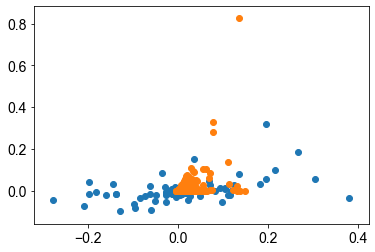

In [1771]:
ys = y.detach().numpy()
recon_xs  = recon_x.detach().numpy()
i  = 1
plt.scatter(ys[i], recon_xs[i])

matchind  = np.argsort(np.linalg.norm(Y_pca  - y.detach().numpy()[i] , axis = 1))[0]
ys = y.detach().numpy()
recon_xs  = recon_x.detach().numpy()
reconY =  pcaY.inverse_transform(recon_xs)
plt.scatter(reconY[i], Y[matchind])

losses= np.zeros(batch_size)
for i in range(batch_size):
    matchind  = np.argsort(np.linalg.norm(Y_pca  - y.detach().numpy()[i] , axis = 1))[0]
    losses[i] = get_loss_paper(reconY[i], Y[matchind])
    
print(np.nanmean(losses))

In [1773]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =50000
        xnorm = normalize(X)#scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= Y_pca
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=20
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,
                    output_activation='linear', encoder_layer_sizes=[100,20], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.85722394855171
0.9975149953949212
0.0010721778035746939 0.007446737378860348
9.577694476341117 376.0
encoder_layer_sizes [20, 100, 20]
decoder_layer_sizes [45]
latent dim 20
2 ncls
0.2 dr_rate
True ubn
True udr
(376, 120)
(0, 120)
(376, 120)
(0, 120)
tensor([[ 9.7553e-02,  5.4574e-01, -2.3699e-01,  ..., -3.4597e-03,
         -3.4566e-03, -3.8049e-02],
        [ 5.0393e-01, -1.2922e-01, -5.4185e-02,  ...,  2.1803e-05,
          2.5311e-03, -4.2461e-03],
        [ 8.4650e-01, -2.7183e-01, -7.7115e-03,  ...,  5.1577e-03,
         -3.7751e-03, -2.1417e-05],
        ...,
        [ 5.6170e-02,  3.3311e-01, -1.9599e-02,  ...,  9.7898e-03,
         -2.0862e-03,  2.1238e-02],
        [ 6.5367e-01,  1.8413e-01, -4.2797e-01,  ...,  1.3938e-02,
         -2.8750e-05, -8.3169e-03],
        [ 7.2630e-01, -1.8157e-01,  1.6226e-01,  ..., -3.5939e-03,
         -4.2917e-03,  1.1211e-02]], dtype=torch.float64)
1 iteration
27.12177085876465
2 iteration
23.77039909362793
3 iteration
18.671863555908203
4 i

0.6517583727836609
239 iteration
0.6488841772079468
240 iteration
0.621431291103363
241 iteration
0.614533543586731
242 iteration
0.5796775817871094
243 iteration
0.6174771785736084
244 iteration
0.6197614073753357
245 iteration
0.6100143194198608
246 iteration
0.5653010606765747
247 iteration
0.6010392904281616
248 iteration
0.5778597593307495
249 iteration
0.6212741136550903
250 iteration
0.6341190934181213
251 iteration
0.5812760591506958
252 iteration
0.6123892068862915
253 iteration
0.6111061573028564
254 iteration
0.573684573173523
255 iteration
0.6264640092849731
256 iteration
0.5929285883903503
257 iteration
0.60288006067276
258 iteration
0.5907412171363831
259 iteration
0.6157404780387878
260 iteration
0.6262837052345276
261 iteration
0.6019906401634216
262 iteration
0.6365944147109985
263 iteration
0.5754716992378235
264 iteration
0.5863451361656189
265 iteration
0.5898338556289673
266 iteration
0.6032074093818665
267 iteration
0.5968019962310791
268 iteration
0.6065071821212

0.4916819632053375
508 iteration
0.5116497874259949
509 iteration
0.3957587778568268
510 iteration
0.4271915853023529
511 iteration
0.4664941430091858
512 iteration
0.4520875811576843
513 iteration
0.46016812324523926
514 iteration
0.47415217757225037
515 iteration
0.4619405269622803
516 iteration
0.44102972745895386
517 iteration
0.43736448884010315
518 iteration
0.4452435374259949
519 iteration
0.502837061882019
520 iteration
0.4556168019771576
521 iteration
0.40773993730545044
522 iteration
0.408253014087677
523 iteration
0.3896116614341736
524 iteration
0.5026665925979614
525 iteration
0.4230259954929352
526 iteration
0.47474732995033264
527 iteration
0.4594612121582031
528 iteration
0.38323789834976196
529 iteration
0.43633145093917847
530 iteration
0.40175861120224
531 iteration
0.4222091734409332
532 iteration
0.43606671690940857
533 iteration
0.45339488983154297
534 iteration
0.4105752408504486
535 iteration
0.4989796280860901
536 iteration
0.40342751145362854
537 iteration
0.4

0.4930388033390045
778 iteration
0.32256120443344116
779 iteration
0.42933011054992676
780 iteration
0.3569585084915161
781 iteration
0.3391609787940979
782 iteration
0.3665948510169983
783 iteration
0.3474520146846771
784 iteration
0.3900699019432068
785 iteration
0.37540462613105774
786 iteration
0.42804837226867676
787 iteration
0.41537824273109436
788 iteration
0.33106493949890137
789 iteration
0.33826619386672974
790 iteration
0.40397462248802185
791 iteration
0.3716716170310974
792 iteration
0.4513423442840576
793 iteration
0.4196809232234955
794 iteration
0.41709357500076294
795 iteration
0.3584674596786499
796 iteration
0.4276067614555359
797 iteration
0.3823445737361908
798 iteration
0.34680989384651184
799 iteration
0.4329718053340912
800 iteration
0.3848707675933838
801 iteration
0.40716391801834106
802 iteration
0.3324926495552063
803 iteration
0.41256657242774963
804 iteration
0.3489153981208801
805 iteration
0.36853671073913574
806 iteration
0.39262086153030396
807 iterat

0.3734188675880432
1044 iteration
0.32200923562049866
1045 iteration
0.3398863673210144
1046 iteration
0.4004126489162445
1047 iteration
0.31577640771865845
1048 iteration
0.2720082402229309
1049 iteration
0.301513135433197
1050 iteration
0.34335970878601074
1051 iteration
0.36561471223831177
1052 iteration
0.3672191798686981
1053 iteration
0.3144523501396179
1054 iteration
0.32640811800956726
1055 iteration
0.33487558364868164
1056 iteration
0.36475250124931335
1057 iteration
0.29169848561286926
1058 iteration
0.369452565908432
1059 iteration
0.3346464931964874
1060 iteration
0.30285051465034485
1061 iteration
0.3900441527366638
1062 iteration
0.34908491373062134
1063 iteration
0.32515066862106323
1064 iteration
0.33560115098953247
1065 iteration
0.266065388917923
1066 iteration
0.3893459439277649
1067 iteration
0.3152824342250824
1068 iteration
0.31753021478652954
1069 iteration
0.3357026278972626
1070 iteration
0.3397158980369568
1071 iteration
0.4336538314819336
1072 iteration
0.34

0.3795725703239441
1285 iteration
0.3345614969730377
1286 iteration
0.3566623330116272
1287 iteration
0.33819764852523804
1288 iteration
0.31036144495010376
1289 iteration
0.3044489026069641
1290 iteration
0.30919569730758667
1291 iteration
0.31033873558044434
1292 iteration
0.3113937973976135
1293 iteration
0.33674001693725586
1294 iteration
0.31907209753990173
1295 iteration
0.29503679275512695
1296 iteration
0.34858936071395874
1297 iteration
0.29254114627838135
1298 iteration
0.30537718534469604
1299 iteration
0.2819385528564453
1300 iteration
0.3091716170310974
1301 iteration
0.30901938676834106
1302 iteration
0.3555641770362854
1303 iteration
0.31294888257980347
1304 iteration
0.2856450080871582
1305 iteration
0.3358921706676483
1306 iteration
0.27915266156196594
1307 iteration
0.2895137369632721
1308 iteration
0.2816850543022156
1309 iteration
0.26865294575691223
1310 iteration
0.33167198300361633
1311 iteration
0.32677415013313293
1312 iteration
0.29497164487838745
1313 iterati

0.29782649874687195
1549 iteration
0.28101640939712524
1550 iteration
0.27217409014701843
1551 iteration
0.2876294255256653
1552 iteration
0.28263968229293823
1553 iteration
0.2784285247325897
1554 iteration
0.2977595627307892
1555 iteration
0.29943710565567017
1556 iteration
0.28483039140701294
1557 iteration
0.25722676515579224
1558 iteration
0.29611214995384216
1559 iteration
0.28635668754577637
1560 iteration
0.31378069519996643
1561 iteration
0.2926071286201477
1562 iteration
0.2693961560726166
1563 iteration
0.32152825593948364
1564 iteration
0.29915887117385864
1565 iteration
0.2572905421257019
1566 iteration
0.26799535751342773
1567 iteration
0.2828250825405121
1568 iteration
0.29425615072250366
1569 iteration
0.3318702280521393
1570 iteration
0.3183782696723938
1571 iteration
0.3017110228538513
1572 iteration
0.2791989743709564
1573 iteration
0.32686904072761536
1574 iteration
0.2594430446624756
1575 iteration
0.2738059163093567
1576 iteration
0.2830659747123718
1577 iteration

0.21448227763175964
1792 iteration
0.3046581447124481
1793 iteration
0.2743186950683594
1794 iteration
0.2635379433631897
1795 iteration
0.28861960768699646
1796 iteration
0.308769553899765
1797 iteration
0.2682199776172638
1798 iteration
0.2853837311267853
1799 iteration
0.26872962713241577
1800 iteration
0.27025336027145386
1801 iteration
0.30225643515586853
1802 iteration
0.23754985630512238
1803 iteration
0.28294962644577026
1804 iteration
0.33197057247161865
1805 iteration
0.2787134051322937
1806 iteration
0.3402007222175598
1807 iteration
0.25759008526802063
1808 iteration
0.24953527748584747
1809 iteration
0.2590439021587372
1810 iteration
0.2783767580986023
1811 iteration
0.2830507755279541
1812 iteration
0.2510961592197418
1813 iteration
0.2662507891654968
1814 iteration
0.26666006445884705
1815 iteration
0.23833386600017548
1816 iteration
0.23967726528644562
1817 iteration
0.25269782543182373
1818 iteration
0.265662282705307
1819 iteration
0.2583634853363037
1820 iteration
0.

0.23080913722515106
2034 iteration
0.2745211124420166
2035 iteration
0.2439780980348587
2036 iteration
0.25095173716545105
2037 iteration
0.27034127712249756
2038 iteration
0.20084071159362793
2039 iteration
0.2463892698287964
2040 iteration
0.2423897087574005
2041 iteration
0.2719264328479767
2042 iteration
0.2396712601184845
2043 iteration
0.26160162687301636
2044 iteration
0.30430638790130615
2045 iteration
0.24447938799858093
2046 iteration
0.23210561275482178
2047 iteration
0.26687929034233093
2048 iteration
0.28304752707481384
2049 iteration
0.2721766531467438
2050 iteration
0.2377321720123291
2051 iteration
0.29078564047813416
2052 iteration
0.27002406120300293
2053 iteration
0.27835163474082947
2054 iteration
0.2729535698890686
2055 iteration
0.22539472579956055
2056 iteration
0.2803516685962677
2057 iteration
0.23940739035606384
2058 iteration
0.2863551676273346
2059 iteration
0.26513049006462097
2060 iteration
0.29151204228401184
2061 iteration
0.2518593370914459
2062 iterati

0.21182993054389954
2300 iteration
0.22393524646759033
2301 iteration
0.25365957617759705
2302 iteration
0.2377055138349533
2303 iteration
0.2644186019897461
2304 iteration
0.25582224130630493
2305 iteration
0.2669558525085449
2306 iteration
0.28877559304237366
2307 iteration
0.25309649109840393
2308 iteration
0.2435224950313568
2309 iteration
0.2220337688922882
2310 iteration
0.24660873413085938
2311 iteration
0.20703637599945068
2312 iteration
0.2564419209957123
2313 iteration
0.2445361614227295
2314 iteration
0.3134201765060425
2315 iteration
0.2530958950519562
2316 iteration
0.2528654932975769
2317 iteration
0.29755598306655884
2318 iteration
0.24130721390247345
2319 iteration
0.27489766478538513
2320 iteration
0.24272222816944122
2321 iteration
0.2629842758178711
2322 iteration
0.2646523714065552
2323 iteration
0.27468886971473694
2324 iteration
0.21716952323913574
2325 iteration
0.25830620527267456
2326 iteration
0.2334071844816208
2327 iteration
0.21208862960338593
2328 iteratio

0.2557677626609802
2553 iteration
0.25953033566474915
2554 iteration
0.2118903398513794
2555 iteration
0.3118172585964203
2556 iteration
0.27296876907348633
2557 iteration
0.2547808289527893
2558 iteration
0.2408372163772583
2559 iteration
0.27132466435432434
2560 iteration
0.2612300217151642
2561 iteration
0.2897227108478546
2562 iteration
0.25412610173225403
2563 iteration
0.23270562291145325
2564 iteration
0.3447574973106384
2565 iteration
0.30366867780685425
2566 iteration
0.26661446690559387
2567 iteration
0.20691072940826416
2568 iteration
0.22914013266563416
2569 iteration
0.2865445613861084
2570 iteration
0.24507996439933777
2571 iteration
0.22094710171222687
2572 iteration
0.27041199803352356
2573 iteration
0.24338474869728088
2574 iteration
0.2546902000904083
2575 iteration
0.2228533774614334
2576 iteration
0.24387308955192566
2577 iteration
0.25527462363243103
2578 iteration
0.22154736518859863
2579 iteration
0.22939471900463104
2580 iteration
0.20180365443229675
2581 iterat

0.23870401084423065
2792 iteration
0.2337510585784912
2793 iteration
0.27715975046157837
2794 iteration
0.2694137990474701
2795 iteration
0.24491722881793976
2796 iteration
0.2514536380767822
2797 iteration
0.2781742811203003
2798 iteration
0.26948082447052
2799 iteration
0.22938565909862518
2800 iteration
0.27936962246894836
2801 iteration
0.2170673906803131
2802 iteration
0.25499227643013
2803 iteration
0.2515527904033661
2804 iteration
0.2857244312763214
2805 iteration
0.21860285103321075
2806 iteration
0.22916178405284882
2807 iteration
0.243844673037529
2808 iteration
0.2023736983537674
2809 iteration
0.23970802128314972
2810 iteration
0.2511647343635559
2811 iteration
0.28589582443237305
2812 iteration
0.24524405598640442
2813 iteration
0.2782798111438751
2814 iteration
0.2529330253601074
2815 iteration
0.27566879987716675
2816 iteration
0.23310081660747528
2817 iteration
0.24879510700702667
2818 iteration
0.2099432647228241
2819 iteration
0.22295372188091278
2820 iteration
0.210

0.22577106952667236
3036 iteration
0.24359068274497986
3037 iteration
0.2146020382642746
3038 iteration
0.24854417145252228
3039 iteration
0.240701824426651
3040 iteration
0.26052066683769226
3041 iteration
0.23297441005706787
3042 iteration
0.23053598403930664
3043 iteration
0.26536083221435547
3044 iteration
0.25348547101020813
3045 iteration
0.2612115442752838
3046 iteration
0.2539609670639038
3047 iteration
0.33592286705970764
3048 iteration
0.26859134435653687
3049 iteration
0.24371027946472168
3050 iteration
0.23124662041664124
3051 iteration
0.21495160460472107
3052 iteration
0.21516947448253632
3053 iteration
0.23547542095184326
3054 iteration
0.2320055067539215
3055 iteration
0.25430744886398315
3056 iteration
0.2516220211982727
3057 iteration
0.2276749163866043
3058 iteration
0.2700551450252533
3059 iteration
0.21410159766674042
3060 iteration
0.24356837570667267
3061 iteration
0.21778073906898499
3062 iteration
0.2424735277891159
3063 iteration
0.23287267982959747
3064 itera

0.25156980752944946
3282 iteration
0.2506776452064514
3283 iteration
0.2868782877922058
3284 iteration
0.2545921206474304
3285 iteration
0.21273890137672424
3286 iteration
0.22880308330059052
3287 iteration
0.2590683400630951
3288 iteration
0.256173700094223
3289 iteration
0.2345542460680008
3290 iteration
0.2290152758359909
3291 iteration
0.24477919936180115
3292 iteration
0.22509273886680603
3293 iteration
0.2562803030014038
3294 iteration
0.2422734797000885
3295 iteration
0.22967727482318878
3296 iteration
0.228838250041008
3297 iteration
0.2521333396434784
3298 iteration
0.2609004080295563
3299 iteration
0.23330426216125488
3300 iteration
0.24670135974884033
3301 iteration
0.22233645617961884
3302 iteration
0.23598328232765198
3303 iteration
0.24570636451244354
3304 iteration
0.2616370618343353
3305 iteration
0.20594613254070282
3306 iteration
0.2308698147535324
3307 iteration
0.2323233187198639
3308 iteration
0.30383482575416565
3309 iteration
0.21730253100395203
3310 iteration
0.

0.22193999588489532
3526 iteration
0.22373619675636292
3527 iteration
0.2914992868900299
3528 iteration
0.22599466145038605
3529 iteration
0.2119998037815094
3530 iteration
0.2532508373260498
3531 iteration
0.24763543903827667
3532 iteration
0.2555566430091858
3533 iteration
0.21514984965324402
3534 iteration
0.23821505904197693
3535 iteration
0.23366813361644745
3536 iteration
0.24268512427806854
3537 iteration
0.23507794737815857
3538 iteration
0.3268735110759735
3539 iteration
0.22235289216041565
3540 iteration
0.2409001588821411
3541 iteration
0.23504769802093506
3542 iteration
0.21204861998558044
3543 iteration
0.25628092885017395
3544 iteration
0.19137592613697052
3545 iteration
0.29045426845550537
3546 iteration
0.25077757239341736
3547 iteration
0.22936217486858368
3548 iteration
0.20714743435382843
3549 iteration
0.2397548407316208
3550 iteration
0.24368074536323547
3551 iteration
0.23182427883148193
3552 iteration
0.24183373153209686
3553 iteration
0.24298140406608582
3554 it

0.24170653522014618
3764 iteration
0.1996789425611496
3765 iteration
0.26924628019332886
3766 iteration
0.26435157656669617
3767 iteration
0.2255924493074417
3768 iteration
0.21307644248008728
3769 iteration
0.1989918202161789
3770 iteration
0.21094612777233124
3771 iteration
0.23083367943763733
3772 iteration
0.23316402733325958
3773 iteration
0.25130122900009155
3774 iteration
0.2077556550502777
3775 iteration
0.24283795058727264
3776 iteration
0.23477184772491455
3777 iteration
0.2619132697582245
3778 iteration
0.206283301115036
3779 iteration
0.2307623326778412
3780 iteration
0.20255354046821594
3781 iteration
0.18923819065093994
3782 iteration
0.26588326692581177
3783 iteration
0.2328922003507614
3784 iteration
0.24449820816516876
3785 iteration
0.23592622578144073
3786 iteration
0.23734958469867706
3787 iteration
0.27277547121047974
3788 iteration
0.2517116367816925
3789 iteration
0.27468109130859375
3790 iteration
0.22044873237609863
3791 iteration
0.23625680804252625
3792 itera

0.23522350192070007
4009 iteration
0.2565746605396271
4010 iteration
0.2304181605577469
4011 iteration
0.20320168137550354
4012 iteration
0.24908402562141418
4013 iteration
0.23871922492980957
4014 iteration
0.2592622637748718
4015 iteration
0.2256123572587967
4016 iteration
0.21383702754974365
4017 iteration
0.22665169835090637
4018 iteration
0.24001018702983856
4019 iteration
0.23922094702720642
4020 iteration
0.21142998337745667
4021 iteration
0.2505415976047516
4022 iteration
0.19688640534877777
4023 iteration
0.2589467465877533
4024 iteration
0.2683786153793335
4025 iteration
0.23989610373973846
4026 iteration
0.24272453784942627
4027 iteration
0.2962357997894287
4028 iteration
0.2549821138381958
4029 iteration
0.23511290550231934
4030 iteration
0.20972740650177002
4031 iteration
0.22958143055438995
4032 iteration
0.25182217359542847
4033 iteration
0.22186267375946045
4034 iteration
0.21788516640663147
4035 iteration
0.2591962516307831
4036 iteration
0.23730090260505676
4037 itera

0.2191907912492752
4255 iteration
0.278847873210907
4256 iteration
0.23879864811897278
4257 iteration
0.2438211441040039
4258 iteration
0.2088850438594818
4259 iteration
0.21807360649108887
4260 iteration
0.2382064312696457
4261 iteration
0.26920267939567566
4262 iteration
0.24075856804847717
4263 iteration
0.24637910723686218
4264 iteration
0.27941054105758667
4265 iteration
0.251389741897583
4266 iteration
0.2537676990032196
4267 iteration
0.27465948462486267
4268 iteration
0.23573088645935059
4269 iteration
0.21425378322601318
4270 iteration
0.26825833320617676
4271 iteration
0.21205854415893555
4272 iteration
0.20836293697357178
4273 iteration
0.2018212378025055
4274 iteration
0.20653481781482697
4275 iteration
0.21212990581989288
4276 iteration
0.21923944354057312
4277 iteration
0.23538067936897278
4278 iteration
0.21386805176734924
4279 iteration
0.22213831543922424
4280 iteration
0.2785388231277466
4281 iteration
0.28141626715660095
4282 iteration
0.2277349978685379
4283 iterati

0.24599075317382812
4496 iteration
0.21392521262168884
4497 iteration
0.1980733871459961
4498 iteration
0.19634731113910675
4499 iteration
0.2375304400920868
4500 iteration
0.2531241774559021
4501 iteration
0.2398950606584549
4502 iteration
0.20613177120685577
4503 iteration
0.25169697403907776
4504 iteration
0.24285170435905457
4505 iteration
0.2253657579421997
4506 iteration
0.27533668279647827
4507 iteration
0.22097504138946533
4508 iteration
0.21848011016845703
4509 iteration
0.22823193669319153
4510 iteration
0.22746434807777405
4511 iteration
0.271934449672699
4512 iteration
0.21435315907001495
4513 iteration
0.2702469825744629
4514 iteration
0.249180406332016
4515 iteration
0.21358832716941833
4516 iteration
0.24703283607959747
4517 iteration
0.23219192028045654
4518 iteration
0.2242335081100464
4519 iteration
0.2613102197647095
4520 iteration
0.2307898998260498
4521 iteration
0.21682651340961456
4522 iteration
0.19109508395195007
4523 iteration
0.26889559626579285
4524 iteratio

0.28292250633239746
4740 iteration
0.24634242057800293
4741 iteration
0.2310422956943512
4742 iteration
0.2528304159641266
4743 iteration
0.2559562921524048
4744 iteration
0.21266309916973114
4745 iteration
0.28511708974838257
4746 iteration
0.25276878476142883
4747 iteration
0.26546603441238403
4748 iteration
0.20660626888275146
4749 iteration
0.2314440757036209
4750 iteration
0.2625616192817688
4751 iteration
0.23741082847118378
4752 iteration
0.23709622025489807
4753 iteration
0.2499254196882248
4754 iteration
0.265475332736969
4755 iteration
0.2570021152496338
4756 iteration
0.20277556777000427
4757 iteration
0.22063398361206055
4758 iteration
0.22304031252861023
4759 iteration
0.2560104727745056
4760 iteration
0.2682636082172394
4761 iteration
0.2532923221588135
4762 iteration
0.21730391681194305
4763 iteration
0.19591042399406433
4764 iteration
0.21045581996440887
4765 iteration
0.22410628199577332
4766 iteration
0.24431785941123962
4767 iteration
0.2513746917247772
4768 iteratio

0.21263423562049866
4981 iteration
0.18634112179279327
4982 iteration
0.1915748119354248
4983 iteration
0.2123483121395111
4984 iteration
0.2546937167644501
4985 iteration
0.25439947843551636
4986 iteration
0.23848798871040344
4987 iteration
0.2140880823135376
4988 iteration
0.22798919677734375
4989 iteration
0.22880864143371582
4990 iteration
0.2135896235704422
4991 iteration
0.24412886798381805
4992 iteration
0.21164369583129883
4993 iteration
0.2129628211259842
4994 iteration
0.22280582785606384
4995 iteration
0.18444280326366425
4996 iteration
0.24043269455432892
4997 iteration
0.21306264400482178
4998 iteration
0.1723978966474533
4999 iteration
0.21858127415180206
5000 iteration
0.25462743639945984
5001 iteration
0.23766155540943146
5002 iteration
0.26770371198654175
5003 iteration
0.23613300919532776
5004 iteration
0.25825995206832886
5005 iteration
0.22109398245811462
5006 iteration
0.226957768201828
5007 iteration
0.2388124018907547
5008 iteration
0.21762681007385254
5009 itera

0.21283891797065735
5228 iteration
0.21676170825958252
5229 iteration
0.22317151725292206
5230 iteration
0.27457451820373535
5231 iteration
0.21352258324623108
5232 iteration
0.2068008929491043
5233 iteration
0.2036556750535965
5234 iteration
0.22640375792980194
5235 iteration
0.22062928974628448
5236 iteration
0.24811914563179016
5237 iteration
0.2371278703212738
5238 iteration
0.22146043181419373
5239 iteration
0.25359174609184265
5240 iteration
0.226189523935318
5241 iteration
0.253489226102829
5242 iteration
0.23334458470344543
5243 iteration
0.24735894799232483
5244 iteration
0.2384369820356369
5245 iteration
0.20435099303722382
5246 iteration
0.19651484489440918
5247 iteration
0.22103381156921387
5248 iteration
0.23830845952033997
5249 iteration
0.20322072505950928
5250 iteration
0.21952013671398163
5251 iteration
0.23000815510749817
5252 iteration
0.2652600407600403
5253 iteration
0.18583276867866516
5254 iteration
0.22036762535572052
5255 iteration
0.2441384494304657
5256 itera

0.20994225144386292
5474 iteration
0.20054621994495392
5475 iteration
0.24529416859149933
5476 iteration
0.24847383797168732
5477 iteration
0.20087747275829315
5478 iteration
0.2183668613433838
5479 iteration
0.2791898846626282
5480 iteration
0.26103830337524414
5481 iteration
0.23465435206890106
5482 iteration
0.19773413240909576
5483 iteration
0.20407333970069885
5484 iteration
0.2031930387020111
5485 iteration
0.22032245993614197
5486 iteration
0.24762685596942902
5487 iteration
0.27092331647872925
5488 iteration
0.20865722000598907
5489 iteration
0.21969854831695557
5490 iteration
0.2221238911151886
5491 iteration
0.24595531821250916
5492 iteration
0.22505638003349304
5493 iteration
0.2534659206867218
5494 iteration
0.22505004703998566
5495 iteration
0.21434469521045685
5496 iteration
0.26527729630470276
5497 iteration
0.23980025947093964
5498 iteration
0.23093505203723907
5499 iteration
0.2377466857433319
5500 iteration
0.22175326943397522
5501 iteration
0.20789094269275665
5502 i

0.2479674071073532
5715 iteration
0.21293134987354279
5716 iteration
0.21502089500427246
5717 iteration
0.19240346550941467
5718 iteration
0.20514731109142303
5719 iteration
0.24573233723640442
5720 iteration
0.21758177876472473
5721 iteration
0.181315079331398
5722 iteration
0.23282214999198914
5723 iteration
0.22025823593139648
5724 iteration
0.20804738998413086
5725 iteration
0.20915651321411133
5726 iteration
0.20126493275165558
5727 iteration
0.20192067325115204
5728 iteration
0.3045889139175415
5729 iteration
0.2544441223144531
5730 iteration
0.19831597805023193
5731 iteration
0.24842555820941925
5732 iteration
0.22618286311626434
5733 iteration
0.25650787353515625
5734 iteration
0.21751174330711365
5735 iteration
0.20351704955101013
5736 iteration
0.2360200583934784
5737 iteration
0.2965233623981476
5738 iteration
0.2260994166135788
5739 iteration
0.2173500806093216
5740 iteration
0.18496830761432648
5741 iteration
0.25888198614120483
5742 iteration
0.2259192019701004
5743 itera

0.22414115071296692
5968 iteration
0.18442457914352417
5969 iteration
0.23095159232616425
5970 iteration
0.23566682636737823
5971 iteration
0.21551720798015594
5972 iteration
0.25602981448173523
5973 iteration
0.20209722220897675
5974 iteration
0.22760725021362305
5975 iteration
0.21443188190460205
5976 iteration
0.28358402848243713
5977 iteration
0.22964712977409363
5978 iteration
0.27398622035980225
5979 iteration
0.23635706305503845
5980 iteration
0.21226677298545837
5981 iteration
0.213832825422287
5982 iteration
0.25219547748565674
5983 iteration
0.24098658561706543
5984 iteration
0.3017140328884125
5985 iteration
0.2554537057876587
5986 iteration
0.25371208786964417
5987 iteration
0.18752676248550415
5988 iteration
0.2521345019340515
5989 iteration
0.22842121124267578
5990 iteration
0.22096402943134308
5991 iteration
0.25680607557296753
5992 iteration
0.19894887506961823
5993 iteration
0.20747950673103333
5994 iteration
0.23251676559448242
5995 iteration
0.2696651220321655
5996 i

0.20450350642204285
6220 iteration
0.2122565507888794
6221 iteration
0.23581814765930176
6222 iteration
0.243121936917305
6223 iteration
0.2526548206806183
6224 iteration
0.22775223851203918
6225 iteration
0.18224398791790009
6226 iteration
0.21072332561016083
6227 iteration
0.19625304639339447
6228 iteration
0.21605198085308075
6229 iteration
0.21188978850841522
6230 iteration
0.19502106308937073
6231 iteration
0.23687076568603516
6232 iteration
0.25386956334114075
6233 iteration
0.22216200828552246
6234 iteration
0.19727899134159088
6235 iteration
0.19832447171211243
6236 iteration
0.2472076416015625
6237 iteration
0.23442821204662323
6238 iteration
0.22227421402931213
6239 iteration
0.21142864227294922
6240 iteration
0.25836044549942017
6241 iteration
0.25089865922927856
6242 iteration
0.23462143540382385
6243 iteration
0.234811931848526
6244 iteration
0.22733359038829803
6245 iteration
0.21547961235046387
6246 iteration
0.24610750377178192
6247 iteration
0.19708773493766785
6248 it

0.2087109088897705
6460 iteration
0.2127380669116974
6461 iteration
0.21514372527599335
6462 iteration
0.1885962337255478
6463 iteration
0.2339569330215454
6464 iteration
0.2243930548429489
6465 iteration
0.2360266000032425
6466 iteration
0.2068217545747757
6467 iteration
0.24219194054603577
6468 iteration
0.19310994446277618
6469 iteration
0.20856812596321106
6470 iteration
0.19412478804588318
6471 iteration
0.22814011573791504
6472 iteration
0.2040494978427887
6473 iteration
0.21682028472423553
6474 iteration
0.2240455150604248
6475 iteration
0.21560099720954895
6476 iteration
0.20986397564411163
6477 iteration
0.209369495511055
6478 iteration
0.25450021028518677
6479 iteration
0.1939358413219452
6480 iteration
0.2239367514848709
6481 iteration
0.2610512375831604
6482 iteration
0.2366340458393097
6483 iteration
0.19803336262702942
6484 iteration
0.21622595191001892
6485 iteration
0.20505666732788086
6486 iteration
0.23944655060768127
6487 iteration
0.22767028212547302
6488 iteration


0.19948959350585938
6708 iteration
0.2545677125453949
6709 iteration
0.20780782401561737
6710 iteration
0.2443527728319168
6711 iteration
0.25570914149284363
6712 iteration
0.21048513054847717
6713 iteration
0.23699279129505157
6714 iteration
0.2555285096168518
6715 iteration
0.2478899508714676
6716 iteration
0.2062276154756546
6717 iteration
0.19220535457134247
6718 iteration
0.25909507274627686
6719 iteration
0.20376770198345184
6720 iteration
0.1954675167798996
6721 iteration
0.2602533996105194
6722 iteration
0.21404218673706055
6723 iteration
0.252672016620636
6724 iteration
0.22092659771442413
6725 iteration
0.20565450191497803
6726 iteration
0.22190716862678528
6727 iteration
0.22104768455028534
6728 iteration
0.2996958792209625
6729 iteration
0.24467666447162628
6730 iteration
0.22959394752979279
6731 iteration
0.26502326130867004
6732 iteration
0.2548109292984009
6733 iteration
0.23013241589069366
6734 iteration
0.19099964201450348
6735 iteration
0.2534061372280121
6736 iterati

0.22552020847797394
6961 iteration
0.19063127040863037
6962 iteration
0.2623632252216339
6963 iteration
0.24304862320423126
6964 iteration
0.23299741744995117
6965 iteration
0.24178604781627655
6966 iteration
0.22694289684295654
6967 iteration
0.2029893398284912
6968 iteration
0.2470642626285553
6969 iteration
0.2888515591621399
6970 iteration
0.25027212500572205
6971 iteration
0.2501875162124634
6972 iteration
0.2230565994977951
6973 iteration
0.22965466976165771
6974 iteration
0.21392759680747986
6975 iteration
0.21882620453834534
6976 iteration
0.21615400910377502
6977 iteration
0.21946246922016144
6978 iteration
0.21334755420684814
6979 iteration
0.22188034653663635
6980 iteration
0.19692569971084595
6981 iteration
0.22518107295036316
6982 iteration
0.23942995071411133
6983 iteration
0.22872371971607208
6984 iteration
0.1959584504365921
6985 iteration
0.2565574049949646
6986 iteration
0.21066829562187195
6987 iteration
0.19071654975414276
6988 iteration
0.22678303718566895
6989 ite

0.19306784868240356
7207 iteration
0.22185401618480682
7208 iteration
0.24867554008960724
7209 iteration
0.22667381167411804
7210 iteration
0.24149870872497559
7211 iteration
0.18849167227745056
7212 iteration
0.22970512509346008
7213 iteration
0.22024686634540558
7214 iteration
0.20528657734394073
7215 iteration
0.22476860880851746
7216 iteration
0.24345484375953674
7217 iteration
0.19958147406578064
7218 iteration
0.22069677710533142
7219 iteration
0.19098414480686188
7220 iteration
0.2187543362379074
7221 iteration
0.22950997948646545
7222 iteration
0.23812651634216309
7223 iteration
0.20333853363990784
7224 iteration
0.24616102874279022
7225 iteration
0.24480852484703064
7226 iteration
0.2180875539779663
7227 iteration
0.19347772002220154
7228 iteration
0.20840103924274445
7229 iteration
0.23341432213783264
7230 iteration
0.21591515839099884
7231 iteration
0.2135482281446457
7232 iteration
0.18058092892169952
7233 iteration
0.20448732376098633
7234 iteration
0.22412410378456116
723

0.2326856404542923
7451 iteration
0.20840904116630554
7452 iteration
0.2318652868270874
7453 iteration
0.208727166056633
7454 iteration
0.20675095915794373
7455 iteration
0.2156156748533249
7456 iteration
0.19798316061496735
7457 iteration
0.19849488139152527
7458 iteration
0.2362864464521408
7459 iteration
0.22440186142921448
7460 iteration
0.1925405114889145
7461 iteration
0.2293778359889984
7462 iteration
0.21681518852710724
7463 iteration
0.17875881493091583
7464 iteration
0.2172938883304596
7465 iteration
0.21751277148723602
7466 iteration
0.2224436104297638
7467 iteration
0.20780488848686218
7468 iteration
0.20503182709217072
7469 iteration
0.263682097196579
7470 iteration
0.19578777253627777
7471 iteration
0.2405085563659668
7472 iteration
0.2085752934217453
7473 iteration
0.21170580387115479
7474 iteration
0.23462431132793427
7475 iteration
0.18219980597496033
7476 iteration
0.21274085342884064
7477 iteration
0.24206042289733887
7478 iteration
0.22377583384513855
7479 iteration

0.21387331187725067
7689 iteration
0.19847707450389862
7690 iteration
0.203940749168396
7691 iteration
0.2264239490032196
7692 iteration
0.18552838265895844
7693 iteration
0.22195859253406525
7694 iteration
0.2905355989933014
7695 iteration
0.2022477388381958
7696 iteration
0.20535030961036682
7697 iteration
0.23409509658813477
7698 iteration
0.23303961753845215
7699 iteration
0.22945329546928406
7700 iteration
0.23128393292427063
7701 iteration
0.22759480774402618
7702 iteration
0.24260075390338898
7703 iteration
0.22400443255901337
7704 iteration
0.23187336325645447
7705 iteration
0.22006294131278992
7706 iteration
0.2124437838792801
7707 iteration
0.24223501980304718
7708 iteration
0.20291343331336975
7709 iteration
0.20355162024497986
7710 iteration
0.1769583523273468
7711 iteration
0.22307586669921875
7712 iteration
0.20563730597496033
7713 iteration
0.2308368682861328
7714 iteration
0.22238370776176453
7715 iteration
0.23103025555610657
7716 iteration
0.25644099712371826
7717 ite

0.20758803188800812
7929 iteration
0.24027998745441437
7930 iteration
0.19752779603004456
7931 iteration
0.24662967026233673
7932 iteration
0.20262864232063293
7933 iteration
0.24496802687644958
7934 iteration
0.2299821823835373
7935 iteration
0.220504492521286
7936 iteration
0.305666446685791
7937 iteration
0.2678344249725342
7938 iteration
0.24116012454032898
7939 iteration
0.2388637810945511
7940 iteration
0.21483895182609558
7941 iteration
0.22995491325855255
7942 iteration
0.20868635177612305
7943 iteration
0.2058248072862625
7944 iteration
0.24354557693004608
7945 iteration
0.238882377743721
7946 iteration
0.20836026966571808
7947 iteration
0.22423303127288818
7948 iteration
0.2462407797574997
7949 iteration
0.22380800545215607
7950 iteration
0.205537348985672
7951 iteration
0.20497223734855652
7952 iteration
0.19722101092338562
7953 iteration
0.20631170272827148
7954 iteration
0.20647530257701874
7955 iteration
0.20630662143230438
7956 iteration
0.19599679112434387
7957 iteratio

0.20366451144218445
8166 iteration
0.18176837265491486
8167 iteration
0.2283341884613037
8168 iteration
0.20927123725414276
8169 iteration
0.23078148066997528
8170 iteration
0.211714506149292
8171 iteration
0.2175922393798828
8172 iteration
0.18245406448841095
8173 iteration
0.21646711230278015
8174 iteration
0.25245293974876404
8175 iteration
0.19327816367149353
8176 iteration
0.2250322550535202
8177 iteration
0.21131542325019836
8178 iteration
0.2077125608921051
8179 iteration
0.2526076138019562
8180 iteration
0.20987820625305176
8181 iteration
0.20733706653118134
8182 iteration
0.22106938064098358
8183 iteration
0.2326240986585617
8184 iteration
0.20595619082450867
8185 iteration
0.2564036548137665
8186 iteration
0.20288273692131042
8187 iteration
0.19625577330589294
8188 iteration
0.26257187128067017
8189 iteration
0.21172311902046204
8190 iteration
0.2156873643398285
8191 iteration
0.23671209812164307
8192 iteration
0.250247985124588
8193 iteration
0.18297436833381653
8194 iterati

0.2530178427696228
8405 iteration
0.21831238269805908
8406 iteration
0.19157573580741882
8407 iteration
0.21587280929088593
8408 iteration
0.22136838734149933
8409 iteration
0.20744149386882782
8410 iteration
0.2593967318534851
8411 iteration
0.2161615639925003
8412 iteration
0.2291070520877838
8413 iteration
0.19584819674491882
8414 iteration
0.1821112334728241
8415 iteration
0.2283027470111847
8416 iteration
0.1769239604473114
8417 iteration
0.22611768543720245
8418 iteration
0.24448683857917786
8419 iteration
0.21108445525169373
8420 iteration
0.2710835635662079
8421 iteration
0.21743229031562805
8422 iteration
0.2230847179889679
8423 iteration
0.2305489033460617
8424 iteration
0.19030313193798065
8425 iteration
0.2337343990802765
8426 iteration
0.212066650390625
8427 iteration
0.18008938431739807
8428 iteration
0.24009275436401367
8429 iteration
0.20834824442863464
8430 iteration
0.2622338831424713
8431 iteration
0.23505643010139465
8432 iteration
0.2135160267353058
8433 iteration


0.23457396030426025
8654 iteration
0.2111283540725708
8655 iteration
0.2072761505842209
8656 iteration
0.21098268032073975
8657 iteration
0.1916167438030243
8658 iteration
0.1940997987985611
8659 iteration
0.18922825157642365
8660 iteration
0.21001510322093964
8661 iteration
0.23670002818107605
8662 iteration
0.21852095425128937
8663 iteration
0.22834594547748566
8664 iteration
0.240878626704216
8665 iteration
0.24035179615020752
8666 iteration
0.20335480570793152
8667 iteration
0.2251630276441574
8668 iteration
0.22422468662261963
8669 iteration
0.21390347182750702
8670 iteration
0.25301769375801086
8671 iteration
0.24228079617023468
8672 iteration
0.21945440769195557
8673 iteration
0.20189230144023895
8674 iteration
0.20044434070587158
8675 iteration
0.20169952511787415
8676 iteration
0.2301391363143921
8677 iteration
0.19135938584804535
8678 iteration
0.22613446414470673
8679 iteration
0.24271166324615479
8680 iteration
0.21963980793952942
8681 iteration
0.22064784169197083
8682 ite

0.2820381224155426
8892 iteration
0.2573855519294739
8893 iteration
0.26872557401657104
8894 iteration
0.25666218996047974
8895 iteration
0.25849753618240356
8896 iteration
0.18006126582622528
8897 iteration
0.2467295229434967
8898 iteration
0.21328549087047577
8899 iteration
0.2351338118314743
8900 iteration
0.21210220456123352
8901 iteration
0.18934056162834167
8902 iteration
0.21983888745307922
8903 iteration
0.22577321529388428
8904 iteration
0.25774186849594116
8905 iteration
0.21847109496593475
8906 iteration
0.21638278663158417
8907 iteration
0.23698274791240692
8908 iteration
0.1890285760164261
8909 iteration
0.2023836076259613
8910 iteration
0.2636212408542633
8911 iteration
0.207450270652771
8912 iteration
0.2180252969264984
8913 iteration
0.22460079193115234
8914 iteration
0.24175584316253662
8915 iteration
0.24505352973937988
8916 iteration
0.20350484549999237
8917 iteration
0.20566634833812714
8918 iteration
0.1973538100719452
8919 iteration
0.22798006236553192
8920 iterat

0.20612666010856628
9133 iteration
0.2156049907207489
9134 iteration
0.26520565152168274
9135 iteration
0.20077797770500183
9136 iteration
0.1997103989124298
9137 iteration
0.21733757853507996
9138 iteration
0.2598312795162201
9139 iteration
0.26322275400161743
9140 iteration
0.20527544617652893
9141 iteration
0.2135074883699417
9142 iteration
0.2298433780670166
9143 iteration
0.2758713662624359
9144 iteration
0.18369272351264954
9145 iteration
0.27009716629981995
9146 iteration
0.2249586582183838
9147 iteration
0.2395651787519455
9148 iteration
0.19759297370910645
9149 iteration
0.22078314423561096
9150 iteration
0.21111616492271423
9151 iteration
0.22897687554359436
9152 iteration
0.17445233464241028
9153 iteration
0.2557153105735779
9154 iteration
0.2524755001068115
9155 iteration
0.22668442130088806
9156 iteration
0.26490920782089233
9157 iteration
0.2521997392177582
9158 iteration
0.24653887748718262
9159 iteration
0.20305375754833221
9160 iteration
0.1808585673570633
9161 iterati

0.24511031806468964
9384 iteration
0.19463597238063812
9385 iteration
0.22058387100696564
9386 iteration
0.20431391894817352
9387 iteration
0.21160490810871124
9388 iteration
0.2191658914089203
9389 iteration
0.22534003853797913
9390 iteration
0.20241808891296387
9391 iteration
0.19439342617988586
9392 iteration
0.20181217789649963
9393 iteration
0.25507479906082153
9394 iteration
0.22312307357788086
9395 iteration
0.23647911846637726
9396 iteration
0.22798410058021545
9397 iteration
0.22645370662212372
9398 iteration
0.21009819209575653
9399 iteration
0.24556633830070496
9400 iteration
0.18976950645446777
9401 iteration
0.207848459482193
9402 iteration
0.20961208641529083
9403 iteration
0.20236614346504211
9404 iteration
0.18586838245391846
9405 iteration
0.23759181797504425
9406 iteration
0.2118792086839676
9407 iteration
0.19193622469902039
9408 iteration
0.19388823211193085
9409 iteration
0.2230808287858963
9410 iteration
0.2152804583311081
9411 iteration
0.20475928485393524
9412 i

KeyboardInterrupt: 

In [1779]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =50000
        xnorm = normalize(X)#scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= Y_pca
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=20
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572360476177812
0.9975116239935473
0.0010721778029925608 0.007446737378860348
9.565142612682955 376.0
encoder_layer_sizes [20, 100]
decoder_layer_sizes [45]
latent dim 20
2 ncls
0.2 dr_rate
True ubn
True udr
(376, 120)
(0, 120)
(376, 120)
(0, 120)
tensor([[ 7.6172e-01, -1.8955e-01, -2.9665e-01,  ...,  2.7406e-03,
          2.4136e-03,  2.5267e-03],
        [ 6.8427e-01,  9.7817e-02,  2.8275e-01,  ..., -2.9293e-03,
         -7.7572e-03,  7.6589e-03],
        [ 6.5474e-02,  3.2826e-01, -2.8203e-02,  ..., -1.0460e-02,
          3.6476e-03, -6.2522e-03],
        ...,
        [ 6.9107e-01, -3.7338e-01, -2.8363e-03,  ..., -8.5858e-03,
         -9.1915e-04, -3.1808e-04],
        [ 5.0388e-01,  2.8289e-01,  3.6675e-01,  ...,  2.5243e-03,
         -9.4740e-03, -2.1619e-03],
        [ 2.8447e-01,  2.3020e-01,  6.8558e-01,  ..., -2.5107e-03,
         -7.9668e-05, -5.7163e-03]], dtype=torch.float64)
1 iteration
24.912277221679688
2 iteration
22.476362228393555
3 iteration
17.73703384399414
4 it

0.5508753061294556
240 iteration
0.6385829448699951
241 iteration
0.6184688806533813
242 iteration
0.6296747922897339
243 iteration
0.6118935346603394
244 iteration
0.6280990839004517
245 iteration
0.6390370726585388
246 iteration
0.5955182909965515
247 iteration
0.611335039138794
248 iteration
0.6385524868965149
249 iteration
0.6450852155685425
250 iteration
0.6262530088424683
251 iteration
0.6445081233978271
252 iteration
0.6299538612365723
253 iteration
0.6176146864891052
254 iteration
0.577241063117981
255 iteration
0.5944398641586304
256 iteration
0.5936875939369202
257 iteration
0.6030895113945007
258 iteration
0.6607890725135803
259 iteration
0.5779076218605042
260 iteration
0.6303436756134033
261 iteration
0.6542203426361084
262 iteration
0.608768105506897
263 iteration
0.6081274747848511
264 iteration
0.582058846950531
265 iteration
0.6138875484466553
266 iteration
0.5686415433883667
267 iteration
0.5779756307601929
268 iteration
0.5638033151626587
269 iteration
0.592435538768

0.46213871240615845
513 iteration
0.4472893178462982
514 iteration
0.44169312715530396
515 iteration
0.4352085590362549
516 iteration
0.42737287282943726
517 iteration
0.43779975175857544
518 iteration
0.418242871761322
519 iteration
0.4687224328517914
520 iteration
0.4638827443122864
521 iteration
0.4571978449821472
522 iteration
0.4330727458000183
523 iteration
0.4560343623161316
524 iteration
0.44968611001968384
525 iteration
0.43899884819984436
526 iteration
0.4497259259223938
527 iteration
0.4502016007900238
528 iteration
0.44816985726356506
529 iteration
0.44991809129714966
530 iteration
0.4451187551021576
531 iteration
0.4318029284477234
532 iteration
0.4350201189517975
533 iteration
0.4652450680732727
534 iteration
0.43181222677230835
535 iteration
0.4884130358695984
536 iteration
0.43731197714805603
537 iteration
0.42462295293807983
538 iteration
0.413785457611084
539 iteration
0.4277913570404053
540 iteration
0.4258635640144348
541 iteration
0.42611318826675415
542 iteration


0.4093244671821594
761 iteration
0.42261284589767456
762 iteration
0.4400312900543213
763 iteration
0.3859303593635559
764 iteration
0.42282143235206604
765 iteration
0.4038420617580414
766 iteration
0.39294272661209106
767 iteration
0.41277486085891724
768 iteration
0.43874257802963257
769 iteration
0.38724130392074585
770 iteration
0.4410187602043152
771 iteration
0.4123637080192566
772 iteration
0.3838154375553131
773 iteration
0.37072935700416565
774 iteration
0.418999582529068
775 iteration
0.45555442571640015
776 iteration
0.4049932062625885
777 iteration
0.41771823167800903
778 iteration
0.4195694029331207
779 iteration
0.4102955460548401
780 iteration
0.4616971015930176
781 iteration
0.43506091833114624
782 iteration
0.4002125859260559
783 iteration
0.3891838788986206
784 iteration
0.38039836287498474
785 iteration
0.40454578399658203
786 iteration
0.4182214140892029
787 iteration
0.4019273817539215
788 iteration
0.4294077455997467
789 iteration
0.3985539972782135
790 iteration

0.38978010416030884
1032 iteration
0.39091014862060547
1033 iteration
0.41732802987098694
1034 iteration
0.38871726393699646
1035 iteration
0.4187965989112854
1036 iteration
0.4308396875858307
1037 iteration
0.4393625855445862
1038 iteration
0.36855435371398926
1039 iteration
0.43087783455848694
1040 iteration
0.4346211552619934
1041 iteration
0.4452084004878998
1042 iteration
0.39811763167381287
1043 iteration
0.3651880621910095
1044 iteration
0.3865382969379425
1045 iteration
0.3652191758155823
1046 iteration
0.4140229821205139
1047 iteration
0.38724154233932495
1048 iteration
0.35305291414260864
1049 iteration
0.37697431445121765
1050 iteration
0.40548086166381836
1051 iteration
0.37917953729629517
1052 iteration
0.36562079191207886
1053 iteration
0.34858447313308716
1054 iteration
0.3684331476688385
1055 iteration
0.38184621930122375
1056 iteration
0.3670895993709564
1057 iteration
0.3754836320877075
1058 iteration
0.37437450885772705
1059 iteration
0.3884688913822174
1060 iteratio

0.32322022318840027
1274 iteration
0.3497278094291687
1275 iteration
0.3696818947792053
1276 iteration
0.39095538854599
1277 iteration
0.3701081871986389
1278 iteration
0.38316553831100464
1279 iteration
0.3228664994239807
1280 iteration
0.42262864112854004
1281 iteration
0.3679289221763611
1282 iteration
0.36724209785461426
1283 iteration
0.3992875814437866
1284 iteration
0.345214307308197
1285 iteration
0.3699459135532379
1286 iteration
0.3633311092853546
1287 iteration
0.3979005217552185
1288 iteration
0.381206214427948
1289 iteration
0.3974716365337372
1290 iteration
0.3916681408882141
1291 iteration
0.3427082598209381
1292 iteration
0.3280879855155945
1293 iteration
0.34022021293640137
1294 iteration
0.3710058033466339
1295 iteration
0.3692436218261719
1296 iteration
0.3749026358127594
1297 iteration
0.3440275490283966
1298 iteration
0.3638606369495392
1299 iteration
0.35435348749160767
1300 iteration
0.34738534688949585
1301 iteration
0.34749993681907654
1302 iteration
0.33185127

0.35864922404289246
1518 iteration
0.36482495069503784
1519 iteration
0.33586350083351135
1520 iteration
0.3525519371032715
1521 iteration
0.3524368405342102
1522 iteration
0.3531416356563568
1523 iteration
0.3730592429637909
1524 iteration
0.3688157796859741
1525 iteration
0.33908864855766296
1526 iteration
0.33479422330856323
1527 iteration
0.3453027307987213
1528 iteration
0.39685362577438354
1529 iteration
0.36734291911125183
1530 iteration
0.3436274826526642
1531 iteration
0.333545446395874
1532 iteration
0.3598606288433075
1533 iteration
0.3909475803375244
1534 iteration
0.3716701865196228
1535 iteration
0.3596206307411194
1536 iteration
0.3518182635307312
1537 iteration
0.3646741509437561
1538 iteration
0.3669751286506653
1539 iteration
0.3240569233894348
1540 iteration
0.31900593638420105
1541 iteration
0.3659037947654724
1542 iteration
0.3243413269519806
1543 iteration
0.3596721291542053
1544 iteration
0.3358607590198517
1545 iteration
0.34459131956100464
1546 iteration
0.3059

0.33883851766586304
1764 iteration
0.35285764932632446
1765 iteration
0.3501797318458557
1766 iteration
0.3604375720024109
1767 iteration
0.3902996778488159
1768 iteration
0.37286481261253357
1769 iteration
0.3555981516838074
1770 iteration
0.3868885636329651
1771 iteration
0.3198820948600769
1772 iteration
0.4077402651309967
1773 iteration
0.3728278875350952
1774 iteration
0.32786309719085693
1775 iteration
0.3762732148170471
1776 iteration
0.3540782928466797
1777 iteration
0.37929654121398926
1778 iteration
0.340751588344574
1779 iteration
0.3498442769050598
1780 iteration
0.3676779568195343
1781 iteration
0.3885105848312378
1782 iteration
0.352642297744751
1783 iteration
0.36781206727027893
1784 iteration
0.3229855000972748
1785 iteration
0.3812134861946106
1786 iteration
0.3589683473110199
1787 iteration
0.3806893825531006
1788 iteration
0.3978114128112793
1789 iteration
0.36626291275024414
1790 iteration
0.3448849320411682
1791 iteration
0.34455230832099915
1792 iteration
0.344450

0.33201315999031067
2007 iteration
0.3392711877822876
2008 iteration
0.3550858199596405
2009 iteration
0.3456243574619293
2010 iteration
0.37902748584747314
2011 iteration
0.42632150650024414
2012 iteration
0.35453903675079346
2013 iteration
0.3059467375278473
2014 iteration
0.3386368453502655
2015 iteration
0.3287571668624878
2016 iteration
0.319654643535614
2017 iteration
0.37009161710739136
2018 iteration
0.32824140787124634
2019 iteration
0.3611451983451843
2020 iteration
0.3703116476535797
2021 iteration
0.36118096113204956
2022 iteration
0.3664120137691498
2023 iteration
0.3171094059944153
2024 iteration
0.34062859416007996
2025 iteration
0.33243387937545776
2026 iteration
0.3458772301673889
2027 iteration
0.3621295988559723
2028 iteration
0.3738633394241333
2029 iteration
0.3437768816947937
2030 iteration
0.3507722020149231
2031 iteration
0.3346761167049408
2032 iteration
0.35398873686790466
2033 iteration
0.3502699136734009
2034 iteration
0.35754334926605225
2035 iteration
0.34

0.3676670491695404
2254 iteration
0.36211639642715454
2255 iteration
0.304420530796051
2256 iteration
0.32675665616989136
2257 iteration
0.3338925838470459
2258 iteration
0.3214358389377594
2259 iteration
0.3240918815135956
2260 iteration
0.3551129698753357
2261 iteration
0.3727497160434723
2262 iteration
0.3383086621761322
2263 iteration
0.34352874755859375
2264 iteration
0.3240855634212494
2265 iteration
0.2974153459072113
2266 iteration
0.352480947971344
2267 iteration
0.32023027539253235
2268 iteration
0.3298467993736267
2269 iteration
0.33144643902778625
2270 iteration
0.31037116050720215
2271 iteration
0.3306308388710022
2272 iteration
0.3613366484642029
2273 iteration
0.30076372623443604
2274 iteration
0.3314705789089203
2275 iteration
0.38382187485694885
2276 iteration
0.36980921030044556
2277 iteration
0.33394089341163635
2278 iteration
0.30815184116363525
2279 iteration
0.324404776096344
2280 iteration
0.31620779633522034
2281 iteration
0.33592674136161804
2282 iteration
0.35

0.39493241906166077
2499 iteration
0.33379048109054565
2500 iteration
0.29525071382522583
2501 iteration
0.34203392267227173
2502 iteration
0.31174802780151367
2503 iteration
0.36561405658721924
2504 iteration
0.34973061084747314
2505 iteration
0.3519636392593384
2506 iteration
0.3535540699958801
2507 iteration
0.29754364490509033
2508 iteration
0.3313852846622467
2509 iteration
0.3545053005218506
2510 iteration
0.3086218237876892
2511 iteration
0.34527072310447693
2512 iteration
0.30350783467292786
2513 iteration
0.320524662733078
2514 iteration
0.3071869909763336
2515 iteration
0.34203243255615234
2516 iteration
0.3272722363471985
2517 iteration
0.30787360668182373
2518 iteration
0.38297197222709656
2519 iteration
0.34403884410858154
2520 iteration
0.3930489420890808
2521 iteration
0.34532636404037476
2522 iteration
0.3515681028366089
2523 iteration
0.36273330450057983
2524 iteration
0.3051682710647583
2525 iteration
0.3346307873725891
2526 iteration
0.3642251789569855
2527 iteration

0.31116098165512085
2744 iteration
0.327562540769577
2745 iteration
0.2950436770915985
2746 iteration
0.27837762236595154
2747 iteration
0.3052818179130554
2748 iteration
0.2916562259197235
2749 iteration
0.2861544191837311
2750 iteration
0.39128655195236206
2751 iteration
0.3654176592826843
2752 iteration
0.34181609749794006
2753 iteration
0.3796086311340332
2754 iteration
0.3206344246864319
2755 iteration
0.2975035309791565
2756 iteration
0.28803199529647827
2757 iteration
0.3425767123699188
2758 iteration
0.3312692940235138
2759 iteration
0.32215553522109985
2760 iteration
0.33872556686401367
2761 iteration
0.3481988310813904
2762 iteration
0.3188949525356293
2763 iteration
0.30597299337387085
2764 iteration
0.3215837776660919
2765 iteration
0.29808109998703003
2766 iteration
0.28163784742355347
2767 iteration
0.3139268457889557
2768 iteration
0.31112250685691833
2769 iteration
0.29626309871673584
2770 iteration
0.2979007661342621
2771 iteration
0.2932601273059845
2772 iteration
0.3

0.3467356860637665
3002 iteration
0.3246125876903534
3003 iteration
0.29774999618530273
3004 iteration
0.3117365539073944
3005 iteration
0.28683751821517944
3006 iteration
0.3140750825405121
3007 iteration
0.290777325630188
3008 iteration
0.3380855917930603
3009 iteration
0.29926544427871704
3010 iteration
0.30995216965675354
3011 iteration
0.31784939765930176
3012 iteration
0.35545647144317627
3013 iteration
0.29339006543159485
3014 iteration
0.3151039481163025
3015 iteration
0.3246264159679413
3016 iteration
0.2793087363243103
3017 iteration
0.35994991660118103
3018 iteration
0.32222968339920044
3019 iteration
0.3070947527885437
3020 iteration
0.2884594798088074
3021 iteration
0.3059268593788147
3022 iteration
0.3043111264705658
3023 iteration
0.3339068293571472
3024 iteration
0.3450547158718109
3025 iteration
0.30638858675956726
3026 iteration
0.31475013494491577
3027 iteration
0.2774394154548645
3028 iteration
0.2798449695110321
3029 iteration
0.29892152547836304
3030 iteration
0.3

0.31505319476127625
3255 iteration
0.29533013701438904
3256 iteration
0.29719337821006775
3257 iteration
0.29295361042022705
3258 iteration
0.30059677362442017
3259 iteration
0.2921622395515442
3260 iteration
0.2944798171520233
3261 iteration
0.2895679473876953
3262 iteration
0.3174375295639038
3263 iteration
0.298221230506897
3264 iteration
0.28844040632247925
3265 iteration
0.31508952379226685
3266 iteration
0.31593984365463257
3267 iteration
0.2880442142486572
3268 iteration
0.2802761495113373
3269 iteration
0.29879945516586304
3270 iteration
0.33148065209388733
3271 iteration
0.27666041254997253
3272 iteration
0.30899059772491455
3273 iteration
0.29501575231552124
3274 iteration
0.28901562094688416
3275 iteration
0.2809146046638489
3276 iteration
0.300413578748703
3277 iteration
0.289247989654541
3278 iteration
0.34126168489456177
3279 iteration
0.30579501390457153
3280 iteration
0.3145963251590729
3281 iteration
0.26841452717781067
3282 iteration
0.29440540075302124
3283 iteration

0.2854538559913635
3510 iteration
0.29107779264450073
3511 iteration
0.2939375340938568
3512 iteration
0.2622905373573303
3513 iteration
0.30359548330307007
3514 iteration
0.2736508250236511
3515 iteration
0.3087976276874542
3516 iteration
0.3272605538368225
3517 iteration
0.31468644738197327
3518 iteration
0.2788543105125427
3519 iteration
0.3066273033618927
3520 iteration
0.30337557196617126
3521 iteration
0.2949872314929962
3522 iteration
0.32912057638168335
3523 iteration
0.28110331296920776
3524 iteration
0.28481525182724
3525 iteration
0.30440062284469604
3526 iteration
0.3188783526420593
3527 iteration
0.34972459077835083
3528 iteration
0.2723988890647888
3529 iteration
0.3270387053489685
3530 iteration
0.28318583965301514
3531 iteration
0.2911520004272461
3532 iteration
0.3265419006347656
3533 iteration
0.27680128812789917
3534 iteration
0.3014467656612396
3535 iteration
0.29743024706840515
3536 iteration
0.27137893438339233
3537 iteration
0.294206440448761
3538 iteration
0.323

0.2854786515235901
3760 iteration
0.23578086495399475
3761 iteration
0.27389997243881226
3762 iteration
0.28903090953826904
3763 iteration
0.29701218008995056
3764 iteration
0.3493996858596802
3765 iteration
0.32996106147766113
3766 iteration
0.3020651936531067
3767 iteration
0.2747774124145508
3768 iteration
0.3123090863227844
3769 iteration
0.3407978117465973
3770 iteration
0.28881028294563293
3771 iteration
0.2920987606048584
3772 iteration
0.2856394350528717
3773 iteration
0.32225483655929565
3774 iteration
0.3124238848686218
3775 iteration
0.29154694080352783
3776 iteration
0.3248363733291626
3777 iteration
0.29554498195648193
3778 iteration
0.2689515948295593
3779 iteration
0.28145861625671387
3780 iteration
0.31564873456954956
3781 iteration
0.3104790151119232
3782 iteration
0.30758610367774963
3783 iteration
0.3205782473087311
3784 iteration
0.2920580506324768
3785 iteration
0.2845461964607239
3786 iteration
0.30227524042129517
3787 iteration
0.33029329776763916
3788 iteration


0.2983270287513733
4018 iteration
0.31300628185272217
4019 iteration
0.2565371096134186
4020 iteration
0.3030032515525818
4021 iteration
0.2735533118247986
4022 iteration
0.2601485252380371
4023 iteration
0.35635843873023987
4024 iteration
0.27426403760910034
4025 iteration
0.2702937722206116
4026 iteration
0.3044469356536865
4027 iteration
0.26649731397628784
4028 iteration
0.26473793387413025
4029 iteration
0.32602518796920776
4030 iteration
0.2986431121826172
4031 iteration
0.2971416115760803
4032 iteration
0.30144840478897095
4033 iteration
0.262151300907135
4034 iteration
0.27760326862335205
4035 iteration
0.3176354765892029
4036 iteration
0.25311794877052307
4037 iteration
0.2811417579650879
4038 iteration
0.2902988791465759
4039 iteration
0.2977829575538635
4040 iteration
0.3179730772972107
4041 iteration
0.28441014885902405
4042 iteration
0.28762322664260864
4043 iteration
0.2674514651298523
4044 iteration
0.27368640899658203
4045 iteration
0.29623502492904663
4046 iteration
0.

0.31235939264297485
4273 iteration
0.33668941259384155
4274 iteration
0.26119107007980347
4275 iteration
0.2738693058490753
4276 iteration
0.28391578793525696
4277 iteration
0.29625338315963745
4278 iteration
0.28189021348953247
4279 iteration
0.2920472025871277
4280 iteration
0.3166560232639313
4281 iteration
0.28904014825820923
4282 iteration
0.2634555697441101
4283 iteration
0.2827865779399872
4284 iteration
0.2963964343070984
4285 iteration
0.272119402885437
4286 iteration
0.28267160058021545
4287 iteration
0.2878074645996094
4288 iteration
0.2688060402870178
4289 iteration
0.27411940693855286
4290 iteration
0.3157741129398346
4291 iteration
0.3129251301288605
4292 iteration
0.2576591372489929
4293 iteration
0.27264347672462463
4294 iteration
0.2864116132259369
4295 iteration
0.2944681942462921
4296 iteration
0.26339077949523926
4297 iteration
0.2654361128807068
4298 iteration
0.29576945304870605
4299 iteration
0.24734409153461456
4300 iteration
0.27338773012161255
4301 iteration
0

0.30292558670043945
4524 iteration
0.2892701029777527
4525 iteration
0.2569441497325897
4526 iteration
0.2553139328956604
4527 iteration
0.2854675352573395
4528 iteration
0.26108425855636597
4529 iteration
0.2537630498409271
4530 iteration
0.2904265224933624
4531 iteration
0.3126368522644043
4532 iteration
0.28202182054519653
4533 iteration
0.2733369469642639
4534 iteration
0.2795414626598358
4535 iteration
0.27150312066078186
4536 iteration
0.28034207224845886
4537 iteration
0.2583225667476654
4538 iteration
0.2629268169403076
4539 iteration
0.2684730887413025
4540 iteration
0.26641935110092163
4541 iteration
0.3065434992313385
4542 iteration
0.2729876935482025
4543 iteration
0.24584579467773438
4544 iteration
0.2899901866912842
4545 iteration
0.30525705218315125
4546 iteration
0.27767306566238403
4547 iteration
0.2918684482574463
4548 iteration
0.2975155711174011
4549 iteration
0.2732224762439728
4550 iteration
0.2668030858039856
4551 iteration
0.2672800123691559
4552 iteration
0.256

0.2645368278026581
4783 iteration
0.3045044541358948
4784 iteration
0.3009626865386963
4785 iteration
0.29133838415145874
4786 iteration
0.3023071885108948
4787 iteration
0.26449406147003174
4788 iteration
0.29960328340530396
4789 iteration
0.2876581847667694
4790 iteration
0.2916998863220215
4791 iteration
0.28767165541648865
4792 iteration
0.26519355177879333
4793 iteration
0.27492642402648926
4794 iteration
0.26228418946266174
4795 iteration
0.3686978816986084
4796 iteration
0.24223676323890686
4797 iteration
0.3036515712738037
4798 iteration
0.23993799090385437
4799 iteration
0.2604682147502899
4800 iteration
0.2340773642063141
4801 iteration
0.29875093698501587
4802 iteration
0.2698104977607727
4803 iteration
0.30011168122291565
4804 iteration
0.29069626331329346
4805 iteration
0.30434054136276245
4806 iteration
0.31578168272972107
4807 iteration
0.2624857723712921
4808 iteration
0.2947571873664856
4809 iteration
0.27593523263931274
4810 iteration
0.2721584141254425
4811 iteration

0.3102481961250305
5028 iteration
0.2810288667678833
5029 iteration
0.2540125250816345
5030 iteration
0.2799721658229828
5031 iteration
0.2892377972602844
5032 iteration
0.32911020517349243
5033 iteration
0.24965199828147888
5034 iteration
0.25139275193214417
5035 iteration
0.2710147798061371
5036 iteration
0.2947511076927185
5037 iteration
0.28194206953048706
5038 iteration
0.2709517180919647
5039 iteration
0.30277055501937866
5040 iteration
0.25386589765548706
5041 iteration
0.29710644483566284
5042 iteration
0.25553008913993835
5043 iteration
0.28512871265411377
5044 iteration
0.2808650732040405
5045 iteration
0.26328521966934204
5046 iteration
0.2671172022819519
5047 iteration
0.31345462799072266
5048 iteration
0.3020505905151367
5049 iteration
0.2533610761165619
5050 iteration
0.2615589499473572
5051 iteration
0.2696979343891144
5052 iteration
0.31261712312698364
5053 iteration
0.24639181792736053
5054 iteration
0.2897478938102722
5055 iteration
0.2631917893886566
5056 iteration
0

0.2992148697376251
5276 iteration
0.298804372549057
5277 iteration
0.27335402369499207
5278 iteration
0.25600796937942505
5279 iteration
0.2635189890861511
5280 iteration
0.2661815583705902
5281 iteration
0.2629091739654541
5282 iteration
0.2783162295818329
5283 iteration
0.27547502517700195
5284 iteration
0.2566123902797699
5285 iteration
0.25165432691574097
5286 iteration
0.2652052044868469
5287 iteration
0.24086162447929382
5288 iteration
0.33820459246635437
5289 iteration
0.25548750162124634
5290 iteration
0.2646191418170929
5291 iteration
0.2543427348136902
5292 iteration
0.2871360778808594
5293 iteration
0.252265602350235
5294 iteration
0.26341357827186584
5295 iteration
0.3395013213157654
5296 iteration
0.2132292538881302
5297 iteration
0.28088682889938354
5298 iteration
0.3212566673755646
5299 iteration
0.2581636309623718
5300 iteration
0.26979368925094604
5301 iteration
0.25791916251182556
5302 iteration
0.24692101776599884
5303 iteration
0.2868799567222595
5304 iteration
0.28

0.27966782450675964
5528 iteration
0.261196106672287
5529 iteration
0.2731470465660095
5530 iteration
0.2561638057231903
5531 iteration
0.26561054587364197
5532 iteration
0.25625908374786377
5533 iteration
0.3009795546531677
5534 iteration
0.2756114602088928
5535 iteration
0.31042808294296265
5536 iteration
0.2683672308921814
5537 iteration
0.2580947279930115
5538 iteration
0.2499319314956665
5539 iteration
0.29458338022232056
5540 iteration
0.28166788816452026
5541 iteration
0.2666741907596588
5542 iteration
0.2815787196159363
5543 iteration
0.25130242109298706
5544 iteration
0.29524853825569153
5545 iteration
0.24787361919879913
5546 iteration
0.28191834688186646
5547 iteration
0.2859785854816437
5548 iteration
0.2762871980667114
5549 iteration
0.25690406560897827
5550 iteration
0.27400854229927063
5551 iteration
0.3350110948085785
5552 iteration
0.25541025400161743
5553 iteration
0.28478091955184937
5554 iteration
0.28124159574508667
5555 iteration
0.2561996579170227
5556 iteration


0.2631698250770569
5771 iteration
0.3051782548427582
5772 iteration
0.2872884273529053
5773 iteration
0.2715206444263458
5774 iteration
0.23199796676635742
5775 iteration
0.27972784638404846
5776 iteration
0.25124305486679077
5777 iteration
0.2605923116207123
5778 iteration
0.2653173804283142
5779 iteration
0.2595358192920685
5780 iteration
0.28205060958862305
5781 iteration
0.2593846023082733
5782 iteration
0.2567203938961029
5783 iteration
0.25059935450553894
5784 iteration
0.2620908319950104
5785 iteration
0.27758485078811646
5786 iteration
0.3436654210090637
5787 iteration
0.24495622515678406
5788 iteration
0.308387815952301
5789 iteration
0.24569149315357208
5790 iteration
0.2964833676815033
5791 iteration
0.2860545516014099
5792 iteration
0.23076336085796356
5793 iteration
0.30504700541496277
5794 iteration
0.24605771899223328
5795 iteration
0.23041932284832
5796 iteration
0.28492945432662964
5797 iteration
0.2908638119697571
5798 iteration
0.2443845272064209
5799 iteration
0.261

0.30965882539749146
6019 iteration
0.2665969729423523
6020 iteration
0.2638252377510071
6021 iteration
0.2532854676246643
6022 iteration
0.2832537889480591
6023 iteration
0.29069215059280396
6024 iteration
0.28333207964897156
6025 iteration
0.29323044419288635
6026 iteration
0.25612714886665344
6027 iteration
0.29645034670829773
6028 iteration
0.2936437726020813
6029 iteration
0.28001144528388977
6030 iteration
0.26016107201576233
6031 iteration
0.28066349029541016
6032 iteration
0.26596418023109436
6033 iteration
0.2524546682834625
6034 iteration
0.22880294919013977
6035 iteration
0.24083217978477478
6036 iteration
0.29479995369911194
6037 iteration
0.2934187948703766
6038 iteration
0.23468053340911865
6039 iteration
0.26461881399154663
6040 iteration
0.2640218138694763
6041 iteration
0.23937585949897766
6042 iteration
0.3120715618133545
6043 iteration
0.2349063903093338
6044 iteration
0.23021206259727478
6045 iteration
0.32091206312179565
6046 iteration
0.27058282494544983
6047 itera

0.259071409702301
6262 iteration
0.28083956241607666
6263 iteration
0.25624603033065796
6264 iteration
0.2609414756298065
6265 iteration
0.261251837015152
6266 iteration
0.26412180066108704
6267 iteration
0.27321308851242065
6268 iteration
0.22333893179893494
6269 iteration
0.254775732755661
6270 iteration
0.2580711245536804
6271 iteration
0.23768603801727295
6272 iteration
0.28304627537727356
6273 iteration
0.2620914876461029
6274 iteration
0.23673447966575623
6275 iteration
0.2612217664718628
6276 iteration
0.26296260952949524
6277 iteration
0.3002297282218933
6278 iteration
0.281780868768692
6279 iteration
0.3000198006629944
6280 iteration
0.2740800082683563
6281 iteration
0.28189677000045776
6282 iteration
0.3113095164299011
6283 iteration
0.2468527853488922
6284 iteration
0.3024595379829407
6285 iteration
0.26541459560394287
6286 iteration
0.24058178067207336
6287 iteration
0.248573899269104
6288 iteration
0.25868356227874756
6289 iteration
0.27498912811279297
6290 iteration
0.276

0.2449103146791458
6508 iteration
0.2915341854095459
6509 iteration
0.26691243052482605
6510 iteration
0.2628004252910614
6511 iteration
0.26177334785461426
6512 iteration
0.217049241065979
6513 iteration
0.2819555997848511
6514 iteration
0.24128839373588562
6515 iteration
0.30480605363845825
6516 iteration
0.2332746684551239
6517 iteration
0.26847532391548157
6518 iteration
0.2736349403858185
6519 iteration
0.2687126100063324
6520 iteration
0.26879075169563293
6521 iteration
0.25421208143234253
6522 iteration
0.2597106695175171
6523 iteration
0.3059609830379486
6524 iteration
0.2765483558177948
6525 iteration
0.2864302098751068
6526 iteration
0.30461472272872925
6527 iteration
0.23376111686229706
6528 iteration
0.2682322859764099
6529 iteration
0.3131650686264038
6530 iteration
0.24991822242736816
6531 iteration
0.2672876715660095
6532 iteration
0.25141623616218567
6533 iteration
0.2597880959510803
6534 iteration
0.2561911642551422
6535 iteration
0.26446741819381714
6536 iteration
0.2

0.3184174597263336
6752 iteration
0.22644273936748505
6753 iteration
0.2612808644771576
6754 iteration
0.2728055417537689
6755 iteration
0.32718122005462646
6756 iteration
0.2374064028263092
6757 iteration
0.27381953597068787
6758 iteration
0.31748470664024353
6759 iteration
0.26388630270957947
6760 iteration
0.3084101676940918
6761 iteration
0.2455635517835617
6762 iteration
0.23558227717876434
6763 iteration
0.28493332862854004
6764 iteration
0.24666115641593933
6765 iteration
0.24365019798278809
6766 iteration
0.2473524808883667
6767 iteration
0.28894513845443726
6768 iteration
0.2582594156265259
6769 iteration
0.28922945261001587
6770 iteration
0.27268627285957336
6771 iteration
0.2888566553592682
6772 iteration
0.24789270758628845
6773 iteration
0.3003372550010681
6774 iteration
0.2854485511779785
6775 iteration
0.25507959723472595
6776 iteration
0.32854944467544556
6777 iteration
0.28175875544548035
6778 iteration
0.2770988643169403
6779 iteration
0.30337849259376526
6780 iterati

0.27503857016563416
6999 iteration
0.236263245344162
7000 iteration
0.279355525970459
7001 iteration
0.2717345356941223
7002 iteration
0.2867073714733124
7003 iteration
0.27697649598121643
7004 iteration
0.2519342303276062
7005 iteration
0.28788092732429504
7006 iteration
0.25762075185775757
7007 iteration
0.2525721788406372
7008 iteration
0.24309897422790527
7009 iteration
0.2639720141887665
7010 iteration
0.24140039086341858
7011 iteration
0.25462615489959717
7012 iteration
0.23782303929328918
7013 iteration
0.21543332934379578
7014 iteration
0.2789577841758728
7015 iteration
0.2501000165939331
7016 iteration
0.24059529602527618
7017 iteration
0.261295348405838
7018 iteration
0.2802831530570984
7019 iteration
0.2674432396888733
7020 iteration
0.266761839389801
7021 iteration
0.293169230222702
7022 iteration
0.2768843472003937
7023 iteration
0.22340711951255798
7024 iteration
0.28371745347976685
7025 iteration
0.2776646614074707
7026 iteration
0.25326594710350037
7027 iteration
0.2245

0.2891610264778137
7248 iteration
0.2428474724292755
7249 iteration
0.29816386103630066
7250 iteration
0.24504224956035614
7251 iteration
0.2418825924396515
7252 iteration
0.26261410117149353
7253 iteration
0.24312981963157654
7254 iteration
0.22113001346588135
7255 iteration
0.28732115030288696
7256 iteration
0.2511579096317291
7257 iteration
0.2325516641139984
7258 iteration
0.27182498574256897
7259 iteration
0.24348168075084686
7260 iteration
0.263016015291214
7261 iteration
0.3103169798851013
7262 iteration
0.3013859987258911
7263 iteration
0.26702770590782166
7264 iteration
0.29634055495262146
7265 iteration
0.264164537191391
7266 iteration
0.2626340091228485
7267 iteration
0.2783209979534149
7268 iteration
0.23307359218597412
7269 iteration
0.284207284450531
7270 iteration
0.2925802767276764
7271 iteration
0.26709675788879395
7272 iteration
0.2828749120235443
7273 iteration
0.2721633017063141
7274 iteration
0.2914643883705139
7275 iteration
0.2364942729473114
7276 iteration
0.261

0.26505130529403687
7493 iteration
0.22605085372924805
7494 iteration
0.2895926237106323
7495 iteration
0.23716413974761963
7496 iteration
0.2529537081718445
7497 iteration
0.26222044229507446
7498 iteration
0.27329927682876587
7499 iteration
0.2925013601779938
7500 iteration
0.2596226632595062
7501 iteration
0.2363535612821579
7502 iteration
0.2810247540473938
7503 iteration
0.26605430245399475
7504 iteration
0.2538682520389557
7505 iteration
0.27062126994132996
7506 iteration
0.3089221119880676
7507 iteration
0.3139794170856476
7508 iteration
0.28737324476242065
7509 iteration
0.22489944100379944
7510 iteration
0.23574411869049072
7511 iteration
0.2261979877948761
7512 iteration
0.3345838487148285
7513 iteration
0.26734763383865356
7514 iteration
0.2571731507778168
7515 iteration
0.2941611409187317
7516 iteration
0.2732880711555481
7517 iteration
0.23113760352134705
7518 iteration
0.2668062448501587
7519 iteration
0.24394401907920837
7520 iteration
0.27269425988197327
7521 iteration


0.24665994942188263
7735 iteration
0.25107017159461975
7736 iteration
0.282247394323349
7737 iteration
0.2347297966480255
7738 iteration
0.22968840599060059
7739 iteration
0.2929052710533142
7740 iteration
0.28962019085884094
7741 iteration
0.2401529848575592
7742 iteration
0.24914324283599854
7743 iteration
0.2669767737388611
7744 iteration
0.2796902060508728
7745 iteration
0.251353919506073
7746 iteration
0.23785504698753357
7747 iteration
0.23347249627113342
7748 iteration
0.25163424015045166
7749 iteration
0.2576015591621399
7750 iteration
0.2525007128715515
7751 iteration
0.25667667388916016
7752 iteration
0.2607271075248718
7753 iteration
0.25864019989967346
7754 iteration
0.24892540276050568
7755 iteration
0.2569451332092285
7756 iteration
0.2925415337085724
7757 iteration
0.22465817630290985
7758 iteration
0.24529246985912323
7759 iteration
0.2395039051771164
7760 iteration
0.3045809268951416
7761 iteration
0.2799602746963501
7762 iteration
0.23803511261940002
7763 iteration
0.

0.23901984095573425
7979 iteration
0.23056761920452118
7980 iteration
0.23676061630249023
7981 iteration
0.25797542929649353
7982 iteration
0.26059192419052124
7983 iteration
0.24420897662639618
7984 iteration
0.25242939591407776
7985 iteration
0.23377585411071777
7986 iteration
0.2664583921432495
7987 iteration
0.23805752396583557
7988 iteration
0.2984360456466675
7989 iteration
0.2585393786430359
7990 iteration
0.24775424599647522
7991 iteration
0.24396085739135742
7992 iteration
0.3022371530532837
7993 iteration
0.24041275680065155
7994 iteration
0.25613173842430115
7995 iteration
0.25904327630996704
7996 iteration
0.22255761921405792
7997 iteration
0.23845979571342468
7998 iteration
0.23570363223552704
7999 iteration
0.27657848596572876
8000 iteration
0.29037660360336304
8001 iteration
0.24915747344493866
8002 iteration
0.2505683898925781
8003 iteration
0.26238712668418884
8004 iteration
0.239972323179245
8005 iteration
0.26065483689308167
8006 iteration
0.22571606934070587
8007 it

0.30166029930114746
8226 iteration
0.2330114096403122
8227 iteration
0.3012797236442566
8228 iteration
0.2604120075702667
8229 iteration
0.24256303906440735
8230 iteration
0.3037348687648773
8231 iteration
0.2546806335449219
8232 iteration
0.2464798241853714
8233 iteration
0.2981087267398834
8234 iteration
0.2531422972679138
8235 iteration
0.26397573947906494
8236 iteration
0.22459585964679718
8237 iteration
0.2641051411628723
8238 iteration
0.26008257269859314
8239 iteration
0.2629476487636566
8240 iteration
0.24388091266155243
8241 iteration
0.24610599875450134
8242 iteration
0.296652615070343
8243 iteration
0.28642818331718445
8244 iteration
0.275339812040329
8245 iteration
0.24123969674110413
8246 iteration
0.22419407963752747
8247 iteration
0.3260553777217865
8248 iteration
0.29209548234939575
8249 iteration
0.2692277729511261
8250 iteration
0.2427075356245041
8251 iteration
0.22159318625926971
8252 iteration
0.24931089580059052
8253 iteration
0.30860573053359985
8254 iteration
0.

0.24116253852844238
8474 iteration
0.2657995820045471
8475 iteration
0.22132179141044617
8476 iteration
0.26789116859436035
8477 iteration
0.23558664321899414
8478 iteration
0.3084288537502289
8479 iteration
0.24884453415870667
8480 iteration
0.23560115694999695
8481 iteration
0.29548731446266174
8482 iteration
0.28744208812713623
8483 iteration
0.23418255150318146
8484 iteration
0.26989999413490295
8485 iteration
0.23256747424602509
8486 iteration
0.2655150592327118
8487 iteration
0.2685428559780121
8488 iteration
0.28117814660072327
8489 iteration
0.3033202290534973
8490 iteration
0.248916894197464
8491 iteration
0.23869583010673523
8492 iteration
0.229427307844162
8493 iteration
0.29145535826683044
8494 iteration
0.2297341525554657
8495 iteration
0.22334575653076172
8496 iteration
0.33775222301483154
8497 iteration
0.26964497566223145
8498 iteration
0.2949904799461365
8499 iteration
0.2259438931941986
8500 iteration
0.24895772337913513
8501 iteration
0.22412152588367462
8502 iterati

0.2572057545185089
8717 iteration
0.2880006432533264
8718 iteration
0.3251371383666992
8719 iteration
0.23830477893352509
8720 iteration
0.25884872674942017
8721 iteration
0.26334553956985474
8722 iteration
0.2365669459104538
8723 iteration
0.24857032299041748
8724 iteration
0.2303076684474945
8725 iteration
0.29934921860694885
8726 iteration
0.2555055618286133
8727 iteration
0.24976448714733124
8728 iteration
0.2674277722835541
8729 iteration
0.26169371604919434
8730 iteration
0.2577688694000244
8731 iteration
0.22661709785461426
8732 iteration
0.2612980604171753
8733 iteration
0.22177156805992126
8734 iteration
0.26668280363082886
8735 iteration
0.31552404165267944
8736 iteration
0.25019583106040955
8737 iteration
0.23212794959545135
8738 iteration
0.30227112770080566
8739 iteration
0.25255414843559265
8740 iteration
0.2691676914691925
8741 iteration
0.2732822299003601
8742 iteration
0.30641236901283264
8743 iteration
0.23657086491584778
8744 iteration
0.26107826828956604
8745 iterat

0.2504314184188843
8960 iteration
0.26797160506248474
8961 iteration
0.31102123856544495
8962 iteration
0.23665396869182587
8963 iteration
0.30881425738334656
8964 iteration
0.26168936491012573
8965 iteration
0.27927854657173157
8966 iteration
0.2580028176307678
8967 iteration
0.24713902175426483
8968 iteration
0.2597779929637909
8969 iteration
0.2866705656051636
8970 iteration
0.2836261987686157
8971 iteration
0.22409097850322723
8972 iteration
0.28299713134765625
8973 iteration
0.2752182185649872
8974 iteration
0.25699156522750854
8975 iteration
0.23761704564094543
8976 iteration
0.23664939403533936
8977 iteration
0.22428175806999207
8978 iteration
0.22680576145648956
8979 iteration
0.2919074296951294
8980 iteration
0.2695707380771637
8981 iteration
0.2282564342021942
8982 iteration
0.22624202072620392
8983 iteration
0.24980051815509796
8984 iteration
0.2520900070667267
8985 iteration
0.2538621425628662
8986 iteration
0.24514906108379364
8987 iteration
0.2898646295070648
8988 iterati

0.24300901591777802
9208 iteration
0.26038336753845215
9209 iteration
0.25079765915870667
9210 iteration
0.24711592495441437
9211 iteration
0.2554386258125305
9212 iteration
0.30627894401550293
9213 iteration
0.2870069146156311
9214 iteration
0.26323407888412476
9215 iteration
0.31002670526504517
9216 iteration
0.2532338798046112
9217 iteration
0.23337140679359436
9218 iteration
0.2407442331314087
9219 iteration
0.2717383801937103
9220 iteration
0.2401573657989502
9221 iteration
0.255420982837677
9222 iteration
0.27070459723472595
9223 iteration
0.2725457549095154
9224 iteration
0.2384631335735321
9225 iteration
0.22304758429527283
9226 iteration
0.24170668423175812
9227 iteration
0.2519782781600952
9228 iteration
0.27026721835136414
9229 iteration
0.2600531578063965
9230 iteration
0.2849568724632263
9231 iteration
0.3030299246311188
9232 iteration
0.22603604197502136
9233 iteration
0.2725244462490082
9234 iteration
0.2705480456352234
9235 iteration
0.22704677283763885
9236 iteration
0

0.2544274926185608
9468 iteration
0.24213913083076477
9469 iteration
0.25989046692848206
9470 iteration
0.262451708316803
9471 iteration
0.25268012285232544
9472 iteration
0.24427524209022522
9473 iteration
0.24579696357250214
9474 iteration
0.31660082936286926
9475 iteration
0.2562907636165619
9476 iteration
0.23988346755504608
9477 iteration
0.2496132105588913
9478 iteration
0.2633085548877716
9479 iteration
0.2703849673271179
9480 iteration
0.26103514432907104
9481 iteration
0.2350022792816162
9482 iteration
0.2759416103363037
9483 iteration
0.21723023056983948
9484 iteration
0.2712569832801819
9485 iteration
0.27881568670272827
9486 iteration
0.29342684149742126
9487 iteration
0.2652757167816162
9488 iteration
0.2824331820011139
9489 iteration
0.23159745335578918
9490 iteration
0.2623678147792816
9491 iteration
0.28140679001808167
9492 iteration
0.2793657183647156
9493 iteration
0.2959137558937073
9494 iteration
0.288715124130249
9495 iteration
0.25193649530410767
9496 iteration
0.

0.2544812262058258
9714 iteration
0.2490500509738922
9715 iteration
0.26434868574142456
9716 iteration
0.2686156630516052
9717 iteration
0.29099148511886597
9718 iteration
0.2715231776237488
9719 iteration
0.279556542634964
9720 iteration
0.26822206377983093
9721 iteration
0.2815459370613098
9722 iteration
0.2815092206001282
9723 iteration
0.2379368543624878
9724 iteration
0.25803014636039734
9725 iteration
0.2607159912586212
9726 iteration
0.3443889021873474
9727 iteration
0.25059130787849426
9728 iteration
0.25527775287628174
9729 iteration
0.3426797091960907
9730 iteration
0.29849663376808167
9731 iteration
0.24540778994560242
9732 iteration
0.26816171407699585
9733 iteration
0.2348736822605133
9734 iteration
0.2616196274757385
9735 iteration
0.244899719953537
9736 iteration
0.26876965165138245
9737 iteration
0.2516764998435974
9738 iteration
0.287895530462265
9739 iteration
0.28030574321746826
9740 iteration
0.28288477659225464
9741 iteration
0.3110426664352417
9742 iteration
0.251

0.24024507403373718
9969 iteration
0.21863135695457458
9970 iteration
0.26747754216194153
9971 iteration
0.2709333896636963
9972 iteration
0.2669057250022888
9973 iteration
0.30679091811180115
9974 iteration
0.27533313632011414
9975 iteration
0.2951454222202301
9976 iteration
0.2510199248790741
9977 iteration
0.22909188270568848
9978 iteration
0.2612569332122803
9979 iteration
0.2731077969074249
9980 iteration
0.3318098187446594
9981 iteration
0.2532307505607605
9982 iteration
0.24467232823371887
9983 iteration
0.2899860143661499
9984 iteration
0.23090824484825134
9985 iteration
0.24161982536315918
9986 iteration
0.28846901655197144
9987 iteration
0.27947598695755005
9988 iteration
0.2687033414840698
9989 iteration
0.2527798116207123
9990 iteration
0.25136449933052063
9991 iteration
0.24690023064613342
9992 iteration
0.279952734708786
9993 iteration
0.2485896646976471
9994 iteration
0.2534615099430084
9995 iteration
0.3012197017669678
9996 iteration
0.24004507064819336
9997 iteration
0

KeyboardInterrupt: 

In [ ]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =50000
        xnorm = normalize(X)#scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        batch_size=20
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

(array([65., 11.,  6.,  4.,  2.,  2.,  2.,  2.,  3.,  3.]),
 array([0.        , 0.03296629, 0.06593257, 0.09889886, 0.13186515,
        0.16483144, 0.19779772, 0.23076401, 0.2637303 , 0.29669658,
        0.32966287]),
 <a list of 10 Patch objects>)

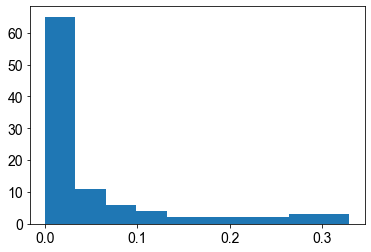

In [1221]:
plt.hist(y.detach().numpy())

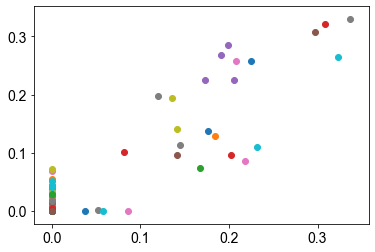

In [1202]:
for i in range(100):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [1203]:
get_loss_paper(recon_x.detach().numpy()[i], y.detach().numpy()[i])

2.0

In [ ]:
#try quantile
#is quantile kernel regression?

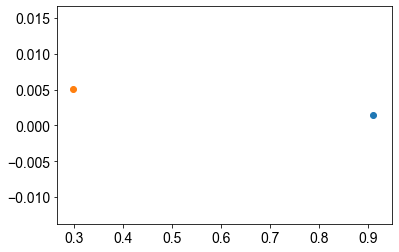

In [429]:
for i in range(2):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [508]:
((y.detach().numpy())**2).sum() / 2

0.0002875122440446679

In [420]:
recon_x.detach().numpy()

array([[0.],
       [0.]], dtype=float32)

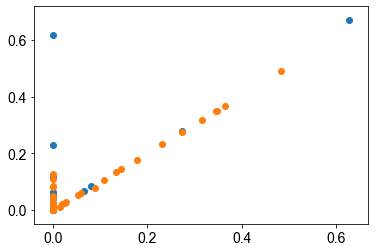

In [292]:
for i in range(2):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

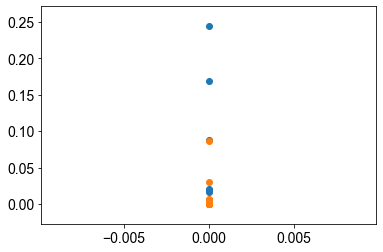

In [328]:
for i in range(2):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

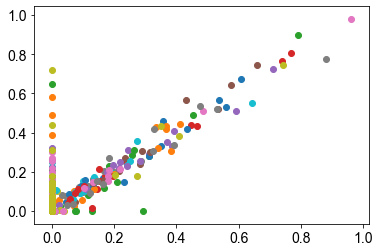

In [223]:
for i in range(19):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

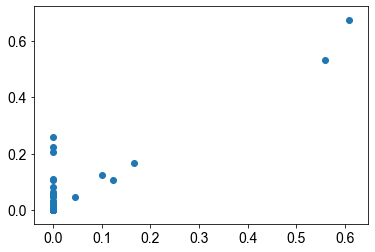

In [222]:
plt.scatter(recon_x.detach().numpy()[0], y.detach().numpy()[0])

In [ ]:
#         asdf = []
#         n_epochs = 1
#         self.logs['loss_train'] = []
#         for epoch in range(n_epochs):
#             print('epoch', epoch)
#             train_loss = 0
#             train_rec = 0
#             train_kl = 0
#             train_mmd = 0
#             for iteration, (x, y,l) in enumerate(data_loader_train):
#                 print(x)
#                 print(iteration, 'iteration')
#                 if l is not None:
#                     x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
#                 else:
#                     x = x.to(self.device)#, y = y.to(self.device)
#                 print(x.shape, y.shape)
#                 recon_x, mean, log_var, y_mmd = self.model(x, y)
#                 #print(torch.norm(recon_x - y))
#                 loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 train_loss = loss.item()
#                 train_rec = reconstruction_loss.item()
#                 train_kl = kl_loss.item()
#                 print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
#                             epoch, n_epochs, iteration, len(data_loader_train) - 1,
#                             loss.item(), reconstruction_loss.item(), kl_loss.item()))
#                 self.logs['loss_train'].append([train_loss])#, iteration)
#                 self.logs['rec_loss_train'].append([train_rec])#, iteration])
#                 self.logs['KL_loss_train'].append([train_kl])#, iteration])
#                 asdf = np.append(asdf,iteration)
#                 if iteration == 20:
#                     break
# #             self.logs['loss_train'].append(train_loss / iteration)
# #             self.logs["rec_loss_train"].append(train_rec / iteration)
# #             self.logs["KL_loss_train"].append(train_kl / iteration)
# #             valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid)
# #             self.logs['loss_valid'].append(valid_loss)
# #             self.logs["rec_loss_valid"].append(valid_rec)
# #             self.logs["KL_loss_valid"].append(valid_kl)

In [185]:
np.linalg.norm(y, axis = 1)

array([0.00187494, 0.00329602, 0.02913826, 0.00741057, 0.00477505,
       0.00351941, 0.00324235, 0.00758736, 0.00512677, 0.00710007,
       0.00323753, 0.01860915, 0.01701778, 0.00398599, 0.0157742 ,
       0.00642402, 0.04437099, 0.00485797, 0.00548362])

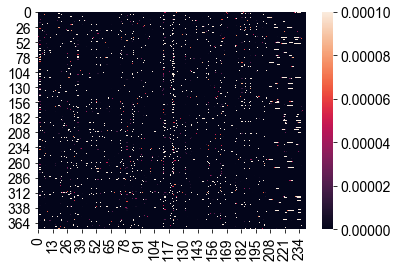

In [134]:
sns.heatmap(trainer.adata.X, vmax= .0001)

In [ ]:
#try visp or other top region (see figure)
#try nmf to reduce number of parameters

In [124]:
help(self.model)

Help on CVAE in module __main__ object:

class CVAE(torch.nn.modules.module.Module)
 |  CVAE(input_dim, output_dim, num_classes=None, encoder_layer_sizes=[64, 32], latent_dim=10, decoder_layer_sizes=[32, 64], alpha=0.001, use_batch_norm=True, dr_rate=0.2, use_mmd=True, beta=1, output_activation='ReLU')
 |  
 |  CVAE class. This class contains the implementation Conditional
 |  Variational Auto-encoder.
 |  # Parameters
 |  
 |      input_dim: integer
 |          Number of input features (i.e. gene in case of scRNA-seq).
 |      num_classes: integer
 |          Number of classes (conditions) the data contain. if `None` the model
 |          will be a normal VAE instead of conditional VAE.
 |      encoder_layer_sizes: List
 |          A list of hidden layer sizes for encoder network.
 |      latent_dim: integer
 |          Bottleneck layer (z)  size.
 |      decoder_layer_sizes: List
 |          A list of hidden layer sizes for decoder network.
 |      alpha: float
 |           alpha coe

In [121]:
asdf

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [122]:
self.logs['loss_train']

[[39.319541931152344],
 [38.16410827636719],
 [32.2147331237793],
 [28.921100616455078],
 [27.084062576293945],
 [22.857070922851562],
 [23.208209991455078],
 [20.72170639038086],
 [17.392362594604492],
 [15.968421936035156],
 [15.304727554321289]]

In [75]:
asdf.shape

(1300,)

In [84]:
np.hstack([np.expand_dims(np.asarray(asdf),1), np.asarray(self.logs['loss_train'])])

array([[3.00000000e+00, 3.92831396e-02],
       [4.00000000e+00, 5.36025884e-02],
       [5.00000000e+00, 5.75487092e-02],
       [6.00000000e+00, 6.20247489e-02],
       [7.00000000e+00, 6.78303414e-02],
       [8.00000000e+00, 7.39499354e-02],
       [9.00000000e+00, 7.89820696e-02],
       [1.00000000e+01, 8.78324541e-02],
       [1.10000000e+01, 1.03451833e-01],
       [1.20000000e+01, 1.07389902e-01],
       [0.00000000e+00, 4.70397994e-03],
       [1.00000000e+00, 1.88610824e-02],
       [2.00000000e+00, 2.70926943e-02],
       [3.00000000e+00, 3.39127509e-02],
       [4.00000000e+00, 4.62123062e-02],
       [5.00000000e+00, 5.47571881e-02],
       [6.00000000e+00, 6.30212864e-02],
       [7.00000000e+00, 7.14673717e-02],
       [8.00000000e+00, 8.56464002e-02],
       [9.00000000e+00, 9.29471217e-02],
       [1.00000000e+01, 1.01619802e-01],
       [1.10000000e+01, 1.17756598e-01],
       [1.20000000e+01, 1.28464844e-01],
       [0.00000000e+00, 2.40324028e-02],
       [1.000000

In [99]:
np.asarray(self.logs['loss_train']).shape

(2601, 1)

In [64]:
train_loss

0.11576594121288508

In [81]:
np.asarray(self.logs['loss_train'])

array([[6.06643105e+01],
       [1.13209122e+02],
       [1.63490036e+02],
       ...,
       [5.29921316e-02],
       [5.84405717e-02],
       [6.51394767e-02]])

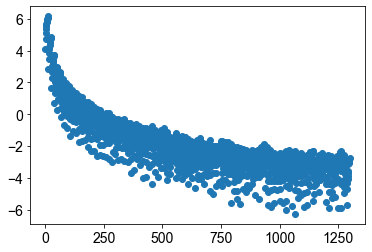

In [86]:
plt.scatter(list(range(np.asarray(self.logs['loss_train']).shape[0])),np.log(np.asarray(self.logs['loss_train'])))

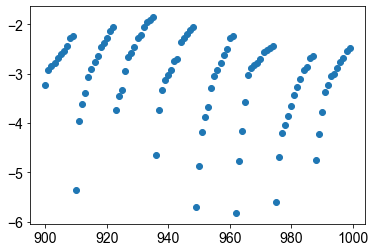

In [87]:
plt.scatter(list(range(900,1000)),np.log(np.asarray(self.logs['loss_train'])[900:1000]))

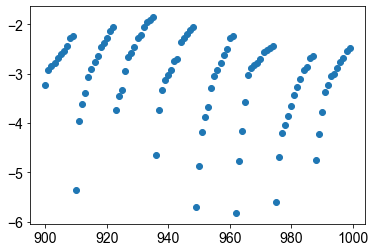

In [90]:
plt.scatter(list(range(900,1000)),np.log(np.asarray(self.logs['loss_train'])[900:1000]))

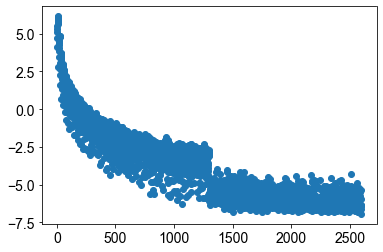

In [91]:
plt.scatter(list(range(np.asarray(self.logs['loss_train']).shape[0])),np.log(np.asarray(self.logs['loss_train'])))

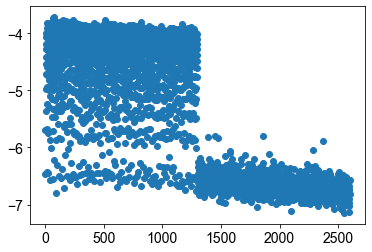

In [93]:
plt.scatter(list(range(np.asarray(self.logs['loss_train']).shape[0])),np.log(np.asarray(self.logs['KL_loss_train'])))

(19, 577)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


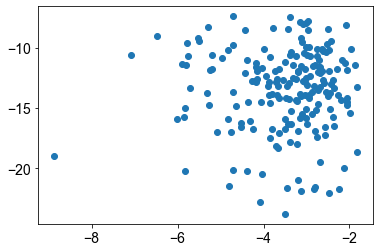

In [113]:
plt.scatter(np.log(recon_x.detach().numpy()[0]  / np.linalg.norm(recon_x.detach().numpy()[0])),np.log(y.detach().numpy()[0]))

7.5169497